Trying to run models on DF containing raw pixel values didn't work very well (best reached accuracy score was about 43% for Random Forest), so we'll try to put more effor in data engineering.
Plan is as follows:
1. Balancing the data:
   1. We'll remove each class which has less than 30 records.
   2. For classes which have 30-119 records we'll forge new records by rotating images, so all those classes will have 120 records.
   3. There is a lot of apples and oranges but we'll let them be for now.
2. Preparing columns from characteristics for every image:
   1. There will be 3x255 columns. In every column there will be number of pixels with this color value, divided by image's size.
   2. Additionally, we'll divide every image into 40 frames, we'll calculate average, median and mode of color in each of those frames, also we will calculate standard deviation for pixel values in each frame and store them as additional variable. It will provide also some spatial information. It will give us 3x4x40 additional variables.
   3. We'll run segmentation on each picture, with 5 centroids. We'll store position of those centroids (X,Y) (scaled by image size), their color and size of segment (scaled). For each picture centorids will be stored four times: firstly sorted by segment color, secondly sorted by segment's size, then sorted by centroid's X position and finally sorted by Y position. This gives us 4x5x(2+3+1) variables. Probably most of them will go away during dimensionality reduction, but we'll see.
   4. We'll run circles detection on every image (HoughCircles from cv2). We'll store: amount of detected circles and Xpos (scaled, 0 if no circles detected), Ypos (scaled, 0 if no circles detected) and radius (scaled, 0 if no circles detected) of the biggest, the smallest and "averaged" circle on the image. it gives us 10 new variables.
   5. We'll run hough transform in order to detect straight lines in images. In DF we'll store amount of lines and max, min, average and mode of rhos' and thetas'. It brings 9 variables to the table.
   6. All above variables will be computed for RGB, HSV, LAB, LUV and YDbDr colorspaces. We will also compute them for grayscale image. It means that we'll have 5x(AMOUNT_FOR_3D_COLORSPACE)+AMOUNT_FOR_GRAYSCALE variables, which is equal to 7394.
3. Clustering data in classes into more homogenous subclasses.
   1. We'll try to run clustering model on every class (Mixtures of Gaussians), using characteristics calculated in previous steps, so we'll hopefully get set of more homogenous classes (for example APPLE class will be divided into APPLE-1, APPLE-2 and so on).
   2. We'll see if dividing classes creates imbalance in data. If so, we'll fix the imbalance and re-merge "overdivided" classes.

In [1]:
color_descr = 3*255+12*40+20*6
space_descr = 10+9
single_cspace = color_descr + space_descr

In [2]:
gray_cspace = color_descr/3 + space_descr
variables_count = single_cspace*5 + gray_cspace
variables_count

7394.0

Let's grab the data:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
rawDF = pd.read_pickle('raw_food_df')
rawDF.describe()

,FullSize2D,Height,Width,Ratio
count,6141.000000,6141.000000,6141.000000,6141.000000
mean,28928.862563,147.234489,193.875916,1.427937
std,9381.904604,41.885839,26.260371,0.214961
min,196.000000,14.000000,14.000000,1.000000
25%,22600.000000,113.000000,200.000000,1.333333
50%,30000.000000,150.000000,200.000000,1.333333
75%,30000.000000,150.000000,200.000000,1.387387
max,139502.000000,373.000000,374.000000,3.400000


In [5]:
rawDF.head()

,Path,FileName,ImageArray,FullSize2D,Height,Width,Ratio,W/o common,ProdName,ImageArray_nump
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]...",22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[113, 112, 108], [102, 101, 99], [106, 105, ...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[206, 210, 222], [207, 211, 223], [206, 210,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[172, 179, 187], [193, 200, 208], [199, 206,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


# Handling imbalance

In [6]:
prodsToDel = rawDF['ProdName'].value_counts()[rawDF['ProdName'].value_counts()<15].index

In [7]:
type(prodsToDel)

pandas.core.indexes.base.Index

In [8]:
(rawDF['ProdName'].value_counts()<15).index

Index(['APPLE', 'ORANGE', 'ONION', 'EGG', 'TOMATO', 'BREAD', 'CHEESE', 'MANGO',
       'BEAN', 'DOUGHNUT', 'SAUCE', 'BANANA', 'PASTA', 'GRAPE', 'LEMON',
       'PEAR', 'PLUM', 'SACHIMA', 'QIWI', 'MOONCAKE', 'PEACH', 'FIRED', 'BUN',
       'LITCHI', 'PEPPER', 'GRAPEFRUIT', 'CARROT', 'WATERMELON', 'CUCUMBER',
       'OLIVE', 'APRICOT', 'POMEGRANATE', 'PAPAYA', 'AVOCADO', 'KIWI', 'DATES',
       'SWEET', 'AUBERGINE', 'RADISH', 'MELON', 'MUSHROOMS', 'COCONUT',
       'GUAVA', 'GARLIC', 'CABBAGE', 'ZUCCHINI', 'PINEAPPLE', 'CHERRY',
       'WHITE', 'CORN', 'CHILI', 'GINGER', 'STRAWBERRY', 'BEETROOT',
       'CAULIFLOWER', 'LENTILS', 'FIG', 'LEEK', 'OKRA', 'FRIEDCHICKEN',
       'RASPBERRY', 'MANDARIN', 'RICE', 'SPINACH'],
      dtype='object')

In [9]:
rawDF = rawDF.drop(rawDF[rawDF['ProdName'].isin(list(prodsToDel))].index,axis=0)

In [10]:
rawDF.head()

,Path,FileName,ImageArray,FullSize2D,Height,Width,Ratio,W/o common,ProdName,ImageArray_nump
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]...",22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[113, 112, 108], [102, 101, 99], [106, 105, ...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[206, 210, 222], [207, 211, 223], [206, 210,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,"[[[172, 179, 187], [193, 200, 208], [199, 206,...",30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


In [11]:
rawDF['ProdName'].value_counts()

APPLE          593
ORANGE         516
ONION          341
EGG            335
TOMATO         332
BREAD          287
CHEESE         244
MANGO          225
BEAN           224
SAUCE          210
DOUGHNUT       210
BANANA         206
PASTA          198
GRAPE          197
LEMON          184
PEAR           178
PLUM           176
SACHIMA        150
QIWI           150
MOONCAKE       134
PEACH          133
FIRED          124
BUN             90
LITCHI          78
PEPPER          61
GRAPEFRUIT      53
CARROT          46
WATERMELON      43
CUCUMBER        40
OLIVE           38
POMEGRANATE     31
APRICOT         31
PAPAYA          29
AVOCADO         24
KIWI            20
DATES           17
AUBERGINE       15
SWEET           15
Name: ProdName, dtype: int64

In [12]:
rawDF['ProdName'].value_counts().describe()

count     38.000000
mean     157.315789
std      136.786894
min       15.000000
25%       40.750000
50%      142.000000
75%      210.000000
max      593.000000
Name: ProdName, dtype: float64

In [13]:
rawDF.shape

(5978, 10)

## Forging new data

If for class with X records, we add "mirror" image for every image and later for every image we add its' copies rotated by 90deg, 180deg and 270deg, we'll receive X*2*4 images. So for 15 images it will be 120 images.
With usage of mirroring and rotating operations we want to increase cardinality of each class with less than 120 records so that it will have 120 records.
We can also artificially dim new images, add some noise or modify contrast.

In [14]:
15*8

120

In [15]:
howMany = (120 - rawDF['ProdName'].value_counts())

In [16]:
type(rawDF['ImageArray'][0])

imageio.core.util.Image

In [17]:
type(rawDF['ImageArray'][0])

imageio.core.util.Image

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 255 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


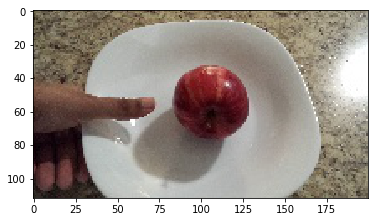

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 146 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 152 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 136 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 132 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\env

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 230 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 182 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 185 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 174 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\env

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 206 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 213 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 205 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\dtype.py:179: UserWarning: Downcasting int32 to uint16 without scaling because max value 190 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\AdamT\Anaconda3\env

In [18]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage import img_as_uint, img_as_float
out = img_as_uint((rawDF['ImageArray'][0].astype(int)))
plt.imshow(out)
plt.show()
#i = cv2.imread(rawDF['Path'][0],cv2.IMREAD_UNCHANGED )
#cv2.imshow('img',i)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#i = Image.open(rawDF['Path'][0])
#i.rotate(45, expand=True).show()
rawDF['SKImage'] = [img_as_uint(x.astype(int)) for x in rawDF['ImageArray']]
#rawDF['CVImage'] = rawDF.apply(lambda x: img_as_float(x['ImageArray'][0]))

In [19]:
(rawDF['SKImage'][0]).shape

(112, 200, 3)

In [20]:
rawDF = rawDF.drop(columns = ['ImageArray'],axis=1)
rawDF.head()

,Path,FileName,FullSize2D,Height,Width,Ratio,W/o common,ProdName,ImageArray_nump,SKImage
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]...","[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...","[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ...","[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,...","[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,...","[[[172, 179, 187], [193, 200, 208], [199, 206,..."


In [21]:
rawDF = rawDF.drop(columns = ['ImageArray_nump'],axis=1)
rawDF.head()

,Path,FileName,FullSize2D,Height,Width,Ratio,W/o common,ProdName,SKImage
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


<class 'numpy.ndarray'>


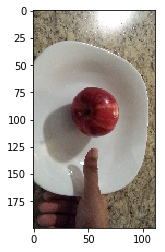

In [22]:
from skimage.transform import rotate
ii = rotate(rawDF['SKImage'][0],90,resize=True,preserve_range=True).astype(int)
print(type(ii[0]))
plt.imshow(ii[:,::-1,:])
#plt.imshow(rawDF['SKImage'][0])
plt.show()

def rotateIm(img,angle):
    return rotate(img,angle,resize=True,preserve_range=True).astype(int)
def mirrorIm(img,axis=1):
    if(axis==0):
        return img[::-1,:,:]
    if(axis==1):
        return img[:,::-1,:]

def rotateChunk(df,angle):
    return df.SKImage.apply(lambda x: rotateIm(x,angle))
def mirrorChunk(df,ax):
    return df.SKImage.apply(lambda x: mirrorIm(x,ax))

In [23]:
rawDF.iloc[:2].SKImage

0    [[[95, 88, 59], [109, 102, 74], [113, 106, 80]...
1    [[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6...
Name: SKImage, dtype: object

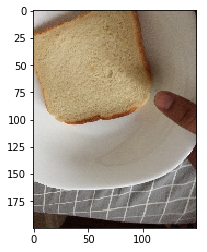

In [24]:
ims = rotateChunk(rawDF.iloc[:2],90)
plt.imshow(ims[1])
plt.show()

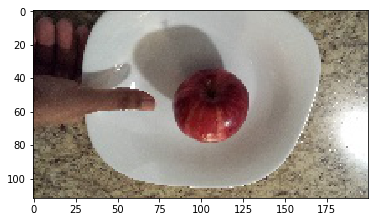

In [25]:
ims = mirrorChunk(rawDF.iloc[:2],0)
plt.imshow(ims[0])
plt.show()

In [26]:
from imageio import imread
from tqdm import tqdm
targetAmount = 120
howMany = (targetAmount - rawDF['ProdName'].value_counts())
for prod in tqdm(rawDF['ProdName'].value_counts()[howMany>0].index):
    amount = rawDF['ProdName'].value_counts()[prod]
    rest = targetAmount%amount
    mainfact = (targetAmount-rest)/amount
    print(prod, "; ", howMany[prod], "; ", mainfact, "*", amount, "+", rest)
    cnt=mainfact
    if mainfact>1:
        tempdf = rawDF[rawDF['ProdName'] == prod]
        tempdf.SKImage = mirrorChunk(tempdf[:],1)
        rawDF = rawDF.append(tempdf, ignore_index=True)
        cnt=cnt-1
    if mainfact>2:
        angles = [90,180,270,45]
        modu = mainfact%2
        print(modu)
        for i in range(int(((mainfact-modu)/2)-1+modu)):
            tempdf = rawDF[rawDF['ProdName'] == prod]
            tempdf.SKImage = rotateChunk(tempdf[:],angles[i])
            rawDF = rawDF.append(tempdf, ignore_index=True)
    if rest>0:
        tempdf = rawDF[rawDF['ProdName'] == prod]
        tempdf = tempdf.sample(n=rest)
        tempdf.SKImage = mirrorChunk(tempdf[:],0)
        print(tempdf.shape)
        rawDF = rawDF.append(tempdf, ignore_index=True)
        
rawDF['ProdName'].value_counts()    
    

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

BUN ;  30 ;  1.0 * 90 + 30
(30, 9)
LITCHI ;  42 ;  1.0 * 78 + 42
(42, 9)
PEPPER ;  59 ;  1.0 * 61 + 59
(59, 9)
GRAPEFRUIT ;  67 ;  2.0 * 53 + 14


C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(14, 9)


 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 31.33it/s]

CARROT ;  74 ;  2.0 * 46 + 28
(28, 9)
WATERMELON ;  77 ;  2.0 * 43 + 34
(34, 9)


 38%|███████████████████████████████▏                                                   | 6/16 [00:00<00:00, 25.38it/s]

CUCUMBER ;  80 ;  3.0 * 40 + 0
1.0
OLIVE ;  82 ;  3.0 * 38 + 6
1.0
(6, 9)


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:01<00:01,  7.70it/s]

POMEGRANATE ;  89 ;  3.0 * 31 + 27
1.0
(27, 9)


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:01<00:01,  6.82it/s]

APRICOT ;  89 ;  3.0 * 31 + 27
1.0
(27, 9)


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:01<00:00,  6.39it/s]

PAPAYA ;  91 ;  4.0 * 29 + 4
0.0
(4, 9)


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:01<00:00,  6.00it/s]

AVOCADO ;  96 ;  5.0 * 24 + 0
1.0


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:02<00:00,  4.96it/s]

KIWI ;  100 ;  6.0 * 20 + 0
0.0


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:02<00:00,  4.53it/s]

DATES ;  103 ;  7.0 * 17 + 1
1.0
(1, 9)


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:03<00:00,  4.01it/s]

AUBERGINE ;  105 ;  8.0 * 15 + 0
0.0


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:04<00:00,  3.49it/s]

SWEET ;  105 ;  8.0 * 15 + 0
0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


APPLE          593
ORANGE         516
ONION          341
EGG            335
TOMATO         332
BREAD          287
DATES          273
CHEESE         244
SWEET          240
AUBERGINE      240
MANGO          225
BEAN           224
DOUGHNUT       210
SAUCE          210
BANANA         206
PASTA          198
GRAPE          197
AVOCADO        192
LEMON          184
PEAR           178
PLUM           176
KIWI           160
CUCUMBER       160
OLIVE          158
POMEGRANATE    151
APRICOT        151
QIWI           150
SACHIMA        150
MOONCAKE       134
PEACH          133
FIRED          124
BUN            120
PEPPER         120
LITCHI         120
CARROT         120
GRAPEFRUIT     120
WATERMELON     120
PAPAYA         120
Name: ProdName, dtype: int64

In [27]:
rawDF.describe()

,FullSize2D,Height,Width,Ratio
count,7912.000000,7912.000000,7912.000000,7912.000000
mean,26852.561426,140.290824,185.358569,1.451295
std,11182.049865,44.925517,41.150899,0.274584
min,304.000000,16.000000,19.000000,1.000000
25%,22400.000000,112.000000,200.000000,1.333333
50%,30000.000000,150.000000,200.000000,1.333333
75%,30000.000000,150.000000,200.000000,1.747573
max,139502.000000,373.000000,374.000000,3.014286


In [28]:
rawDF['ProdName'].value_counts().describe()

count     38.000000
mean     208.210526
std      104.276700
min      120.000000
25%      138.000000
50%      181.000000
75%      236.250000
max      593.000000
Name: ProdName, dtype: float64

In [29]:
rawDF['SKImage'][0].shape

(112, 200, 3)

In [30]:
manhi = np.histogram(rawDF['SKImage'][0][:,:,0],bins=range(257), density = True)

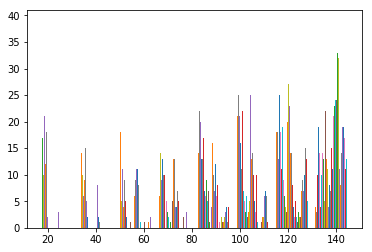

In [31]:
plt.hist(rawDF['SKImage'][0][:,:,0],bins='auto')
plt.show()

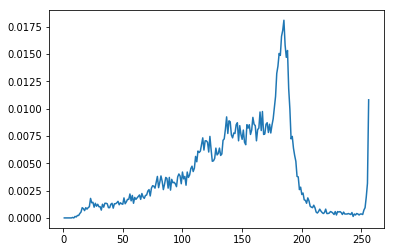

In [33]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()

In [34]:
manhi1 = np.histogram(rawDF['SKImage'][0][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][0][:,:,2],bins=range(257), density = True)

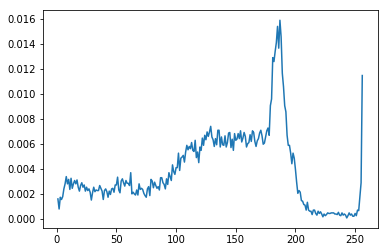

In [35]:
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()

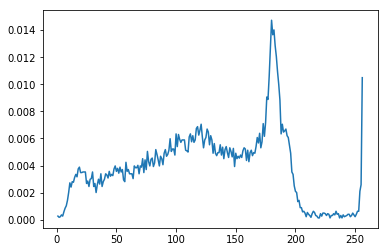

In [36]:
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

In [37]:
rawDF['SKImage'][0][:,:,2]

array([[ 59,  74,  80, ..., 118, 125, 133],
       [ 76,  78,  80, ..., 125, 131, 141],
       [ 50,  78, 108, ..., 116, 147, 154],
       ...,
       [ 28,  42,  36, ...,  94,  75,  66],
       [ 29,  25,  38, ...,  82,  75,  70],
       [ 29,  33,  40, ...,  98, 118,  73]], dtype=uint16)

In [38]:
manhi = np.histogram(rawDF['SKImage'][90][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][90][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][90][:,:,2],bins=range(257), density = True)

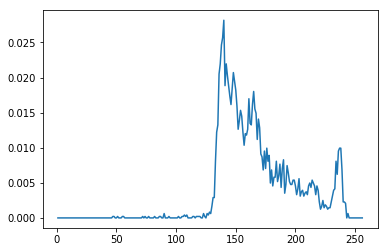

In [39]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()

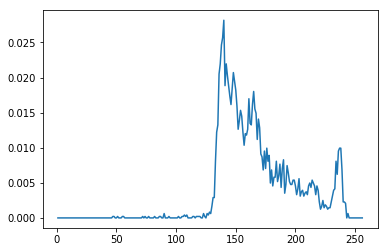

In [40]:
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()

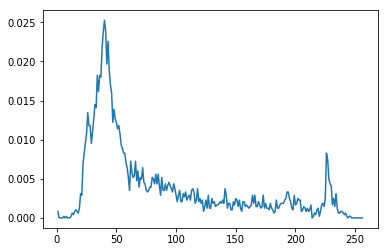

In [41]:
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

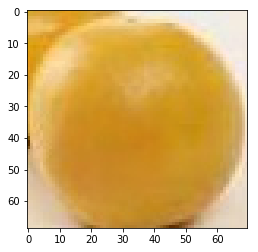

In [42]:
plt.imshow(rawDF['SKImage'][90])
plt.show()

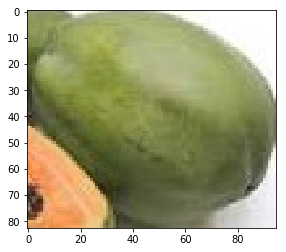

In [43]:
plt.imshow(rawDF['SKImage'][1000])
plt.show()

In [44]:
manhi = np.histogram(rawDF['SKImage'][1000][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][1000][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][1000][:,:,2],bins=range(257), density = True)

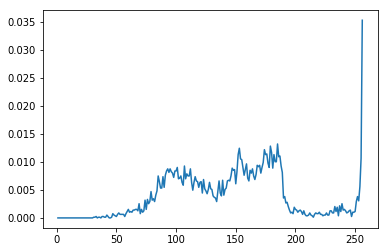

In [45]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()

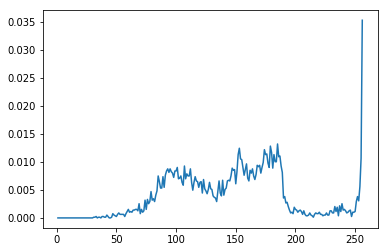

In [46]:
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()

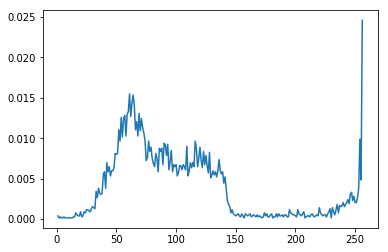

In [47]:
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

In [48]:
manhi = np.histogram(rawDF['SKImage'][10][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][10][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][10][:,:,2],bins=range(257), density = True)

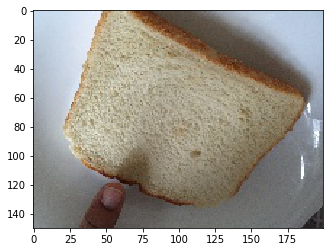

In [49]:
plt.imshow(rawDF['SKImage'][10])
plt.show()

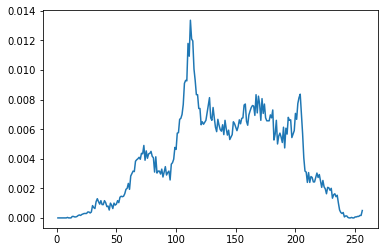

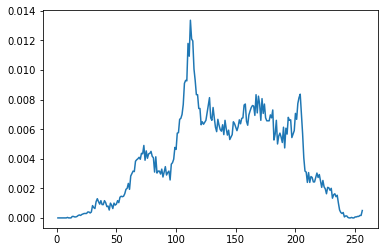

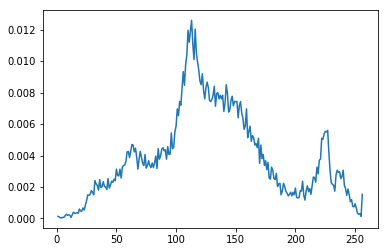

In [50]:
plt.plot(manhi[1][1:],manhi[0])
plt.show()
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

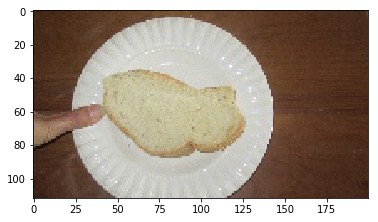

In [51]:
plt.imshow(rawDF['SKImage'][76])
plt.show()

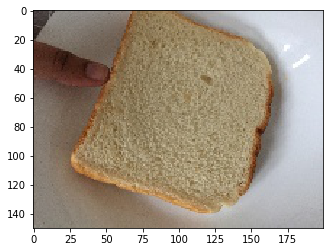

In [52]:
plt.imshow(rawDF['SKImage'][25])
plt.show()

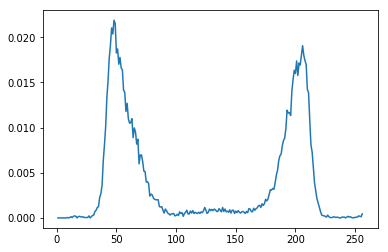

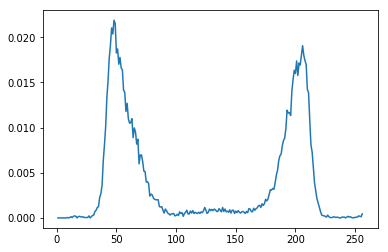

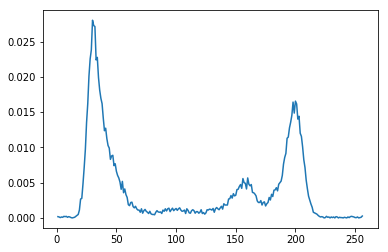

In [53]:
manhi = np.histogram(rawDF['SKImage'][76][:,:,1],bins=range(257), density = True)
manhi1 = np.histogram(rawDF['SKImage'][76][:,:,1],bins=range(257), density = True)
manhi2 = np.histogram(rawDF['SKImage'][76][:,:,2],bins=range(257), density = True)
plt.plot(manhi[1][1:],manhi[0])
plt.show()
plt.plot(manhi1[1][1:],manhi1[0])
plt.show()
plt.plot(manhi2[1][1:],manhi2[0])
plt.show()

In [54]:
#rawDF['SKImageHSV'][25][:,:,1]

In [55]:
#manhi = np.histogram(rawDF['SKImageCIE'][25][:,:,1],bins=50, density = True)
#manhi1 = np.histogram(rawDF['SKImageCIE'][25][:,:,1],bins=50, density = True)
#manhi2 = np.histogram(rawDF['SKImageCIE'][25][:,:,2],bins=50, density = True)
#plt.plot(manhi[1][1:],manhi[0])
#plt.show()
#plt.plot(manhi1[1][1:],manhi1[0])
#plt.show()
#plt.plot(manhi2[1][1:],manhi2[0])
#plt.show()

### Adding images in other colorspaces

In [56]:
from skimage import color as cl
#rawDF['SKImageHED'] = rawDF['SKImage'].apply(cl.rgb2hed)
#rawDF['SKImageXYZ'] = rawDF['SKImage'].apply(cl.rgb2xyz)
#rawDF['SKImageYUV'] = rawDF['SKImage'].apply(cl.rgb2yuv)
#rawDF['SKImageYIQ'] = rawDF['SKImage'].apply(cl.rgb2yiq)
#rawDF['SKImageYPBPR'] = rawDF['SKImage'].apply(cl.rgb2ypbpr)
#rawDF['SKImageYCBCR'] = rawDF['SKImage'].apply(cl.rgb2ycbcr)


#rawDF['SKImageHSV'] = rawDF['SKImage'].apply(cl.rgb2hsv)
#rawDF['SKImageCIE'] = rawDF['SKImage'].apply(cl.rgb2rgbcie)
#rawDF['SKImageYDBDR'] = rawDF['SKImage'].apply(cl.rgb2ydbdr)


#plt.imshow(rawDF['SKImageHSV'][25])
#plt.title('HSV')
#plt.show()
#plt.imshow(rawDF['SKImageCIE'][25])
#plt.title('CIE')
#plt.show()
#plt.imshow(rawDF['SKImageYDBDR'][25])
#plt.title('YDBDR')
#plt.show()

In [57]:
#dim = 2
#plt.imshow(rawDF['SKImageHSV'][25][:,:,dim])
#plt.title('HSV')
#plt.show()
#plt.imshow(rawDF['SKImageCIE'][25][:,:,dim])
#plt.title('CIE')
#plt.show()
#plt.imshow(rawDF['SKImageYDBDR'][25][:,:,dim])
#plt.title('YDBDR')
#plt.show()

### Histogram data extraction

In [58]:
rawDF.rename(columns={'SKImageRGB':'SKImage'}, inplace=True)
rawDF.head()

,Path,FileName,FullSize2D,Height,Width,Ratio,W/o common,ProdName,SKImage
0,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,0_PROGRAMMING_PROJS_FooDMachineLearning_FooDD_...,22400,112,200,1.785714,Apple_1-Samsung-S4-Light__Environment_1__(1)_j...,APPLE,"[[[95, 88, 59], [109, 102, 74], [113, 106, 80]..."
1,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1000_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(60)_jpg3_...,BREAD,"[[[59, 39, 30], [67, 47, 36], [65, 43, 30], [6..."
2,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1001_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(61)_jpg3_...,BREAD,"[[[113, 112, 108], [102, 101, 99], [106, 105, ..."
3,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1002_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(62)_jpg3_...,BREAD,"[[[206, 210, 222], [207, 211, 223], [206, 210,..."
4,D:\PROGRAMMING_PROJS\FooDMachineLearning\compl...,1003_PROGRAMMING_PROJS_FooDMachineLearning_Foo...,30000,150,200,1.333333,Bread_3-IOS-4-Light__Environment_3__(63)_jpg3_...,BREAD,"[[[172, 179, 187], [193, 200, 208], [199, 206,..."


In [59]:
bins = 257
def getHists(x):
    hists = []
    for i in range(3):
        hists.append(np.histogram(x[:,:,i],bins=50, density = True))
    return hists

In [60]:

#rawDF['SKImageHSV'] = rawDF['SKImage'].apply(cl.rgb2hsv)
#rawDF['SKImageCIE'] = rawDF['SKImage'].apply(cl.rgb2rgbcie)
#rawDF['SKImageYDBDR'] = rawDF['SKImage'].apply(cl.rgb2ydbdr)

In [280]:
def genHistArrays(df,csname):
    allpixV = np.zeros((df.shape[0],150))
    hists = rawDF['SKImage'].apply(getHists)
    colrang = range(1,np.size(hists[0][0][1]))
    fullnames = []
    for chs in ['CH1', 'CH2', 'CH3']:
        fullnames.extend([chs+'-'+str(j) for j in colrang])
    fullnames = [csname+'-'+str(j) for j in fullnames]
    for rowi, pArr in enumerate(hists):
        pixVals = pArr[0][0]
        pixVals = np.append(pixVals,pArr[1][0])
        pixVals = np.append(pixVals,pArr[2][0])
        allpixV[rowi,:] = pixVals
        pixVals = None
    return allpixV,fullnames


In [281]:
allpixV,fullnames = genHistArrays(rawDF,'RGB')

In [282]:
allpixV.shape

(7912, 150)

In [283]:
np.size(fullnames)

150

150.0


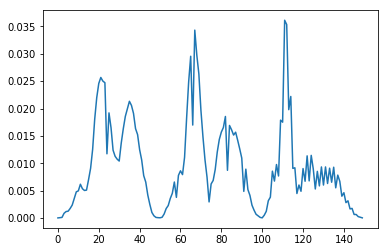

In [63]:
print(np.size(allpixV)/rawDF.shape[0])
plt.plot(list(range(150)),allpixV[100,:])
plt.show()

### Dividing images into series of blocks

In [100]:
from skimage.util import view_as_blocks
from skimage.transform import resize
from scipy.stats import mode

def blocksForImg(img,samplsiz,resc):
    imgr = resize(img,(resc,resc,3))
    y=imgr.shape[0]
    x=imgr.shape[1]
    view = []
    view.append(view_as_blocks(imgr[:,:,0], (samplsiz,samplsiz)))
    view.append(view_as_blocks(imgr[:,:,1], (samplsiz,samplsiz)))
    view.append(view_as_blocks(imgr[:,:,2], (samplsiz,samplsiz)))
    flv = [v.reshape(v.shape[0],v.shape[1],-1) for v in view]
    meanb = np.array([np.mean(f,axis=2) for f in flv])
    #cmode = [mode(f,axis=2) for f in flv]
    stdb = np.array([np.std(f,axis=2) for f in flv])
    meanb = meanb.flatten()
    stdb = stdb.flatten()
    meanbsort = np.sort(meanb)
    stdbsort = np.sort(stdb)
    return np.append(meanb,[stdb,meanbsort,stdbsort])
    #return meanb.append(stdb.append(meanbsort.append(stdbsort)))

def blocksVals(df,ssiz,resc,cspacename='RGB'):
    amountBlocks = np.power(resc/ssiz,2)
    amountBlocks = int(amountBlocks)
    labelnames = []
    for ch in ['CH1','CH2','CH3']:   
        labelnames = np.append(labelnames,[cspacename+'-Mean-Block: ' + str(i) for i in range(1,amountBlocks+1)])
        labelnames = np.append(labelnames,[cspacename+'-Std-Block: ' + str(i) for i in range(1,amountBlocks+1)])
        labelnames = np.append(labelnames,[cspacename+'-Mean_Sorted-Block: ' + str(i) for i in range(1,amountBlocks+1)])
        labelnames = np.append(labelnames,[cspacename+'-Std_Sorted-Block: ' + str(i) for i in range(1,amountBlocks+1)])
    blockDesc = df['SKImage'].apply(lambda x: blocksForImg(x,ssiz,resc))
    return blockDesc,labelnames
#flv1 = view1.reshape(view1.shape[0],view1.shape[1],-1)
#mean1 = np.mean(flv1,axis=2)
#flv2 = view2.reshape(view2.shape[0],view2.shape[1],-1)
#mean2 = np.mean(flv2,axis=2)
#flv3 = view1.reshape(view3.shape[0],view3.shape[1],-1)
#mean3 = np.mean(flv3,axis=2)
#view = np.array([mean1/100,mean2/100,mean3/100])
#print(view.shape)
#plt.imshow(view)
#plt.show()

In [101]:
blocksDecrTupl = blocksVals(rawDF,20,160)

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [104]:
print(np.size(blocksDecrTupl[0][0]))

768


In [103]:
print(np.size(blocksDecrTupl[1]))

768


### Segmenting images with Gaussian Mixture, and extracting information about clusters:

In [181]:
from skimage.filters import gaussian
img = rawDF['SKImage'][25]

In [149]:
img.shape

(150, 200, 3)

In [182]:
imgforSeg = np.zeros((img.shape[0]*img.shape[1],5))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        imgforSeg[(img.shape[0]*j)+i,:] = np.append(img[i][j],[j,i])
Xseg = np.array(imgforSeg)
Xseg.shape

In [183]:
Xseg = np.array(imgforSeg)
Xseg.shape

(30000, 5)

In [184]:
from sklearn import mixture
n_kernels = 5
gmm = mixture.GaussianMixture(n_components=n_kernels, covariance_type='full')
gmm.fit(Xseg)
labels = gmm.predict(Xseg)

In [153]:
labels.shape

(30000,)

In [185]:
img2 = np.zeros(img.shape)

In [186]:
img2 = np.zeros(img.shape)
for i in range(img2.shape[0]):
    for j in range(img2.shape[1]):
        img2[i][j] = labels[j*(img2.shape[0])+i]

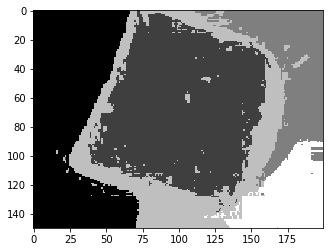

In [187]:
plt.imshow(img2/np.max(img2))
plt.show()

In [188]:
labsDat = pd.DataFrame(data = Xseg)

In [189]:
labsDat.head()

,0,1,2,3,4
0,82.0,73.0,74.0,0.0,0.0
1,77.0,68.0,69.0,0.0,1.0
2,77.0,68.0,69.0,0.0,2.0
3,74.0,65.0,66.0,0.0,3.0
4,75.0,66.0,67.0,0.0,4.0


In [190]:
labsDat = pd.DataFrame(data = Xseg)
labsDat['label'] = labels

In [194]:
labsDat.shape

(30000, 6)

In [216]:
labsDat.head()

,0,1,2,3,4,label
0,82.0,73.0,74.0,0.0,0.000,0
1,77.0,68.0,69.0,0.0,0.005,0
2,77.0,68.0,69.0,0.0,0.010,0
3,74.0,65.0,66.0,0.0,0.015,0
4,75.0,66.0,67.0,0.0,0.020,0


In [193]:
labsDat.loc[labsDat['label']==0,0]

0         82.0
1         77.0
2         77.0
3         74.0
4         75.0
5         63.0
6         68.0
7         60.0
8         62.0
9         72.0
10        87.0
11        45.0
12        47.0
13        43.0
14        45.0
15        43.0
16        45.0
17        40.0
18        40.0
19        30.0
20        59.0
21        68.0
22        86.0
23        86.0
24        83.0
25        74.0
26        66.0
27        74.0
28        64.0
29        75.0
         ...  
10642    140.0
10643    139.0
10644    142.0
10645    142.0
10646    140.0
10647    140.0
10648    141.0
10649    141.0
10780    131.0
10781    133.0
10782    137.0
10783    138.0
10784    138.0
10785    138.0
10786    136.0
10787    136.0
10788    137.0
10789    143.0
10790    136.0
10791    140.0
10792    142.0
10794    140.0
10931    141.0
10933    131.0
10934    137.0
10935    137.0
10936    137.0
10938    139.0
10939    141.0
10940    130.0
Name: 0, Length: 7535, dtype: float64

In [212]:
labsDat = pd.DataFrame(data = Xseg)
labsDat['label'] = labels
labsDat[3] = labsDat[3]/img.shape[0]
labsDat[4] = labsDat[4]/img.shape[1]

In [241]:
labsDat = pd.DataFrame(data = Xseg)
labsDat['label'] = labels
labsDat[3] = labsDat[3]/img.shape[0]
labsDat[4] = labsDat[4]/img.shape[1]
siz = np.zeros(5)
mean = np.zeros((5,5))
for i in range(5):
    siz[i] = labsDat.loc[labsDat['label']==i,0].shape[0]/labsDat.shape[0]
    mean[i,:] = labsDat.loc[labsDat['label']==i].mean(axis=0)[:-1]
centrsDF = pd.DataFrame(data = mean)
centrsDF['size'] = siz

In [242]:
centrsDF = pd.DataFrame(data = mean)
centrsDF['size'] = siz
centrsDF.head()

,0,1,2,3,4,size
0,118.581685,101.335634,88.607432,0.001201,0.001830,0.251167
1,156.119694,139.615296,105.520937,0.004579,0.001675,0.348667
2,202.647154,207.299678,216.062030,0.007835,0.001047,0.124133
3,153.152890,129.242968,101.943917,0.004703,0.002208,0.193167
4,184.769107,186.878922,191.931215,0.007758,0.003166,0.082867


In [243]:
centrsDF = centrsDF.sort_values(by=0).append(centrsDF.sort_values(by=1)).append(
    centrsDF.sort_values(by=2)).append(centrsDF.sort_values(by=3)).append(
    centrsDF.sort_values(by=4)).append(centrsDF.sort_values(by='size'))
centrsDF

,0,1,2,3,4,size
0,118.581685,101.335634,88.607432,0.001201,0.001830,0.251167
3,153.152890,129.242968,101.943917,0.004703,0.002208,0.193167
1,156.119694,139.615296,105.520937,0.004579,0.001675,0.348667
4,184.769107,186.878922,191.931215,0.007758,0.003166,0.082867
2,202.647154,207.299678,216.062030,0.007835,0.001047,0.124133
0,118.581685,101.335634,88.607432,0.001201,0.001830,0.251167
3,153.152890,129.242968,101.943917,0.004703,0.002208,0.193167
1,156.119694,139.615296,105.520937,0.004579,0.001675,0.348667
4,184.769107,186.878922,191.931215,0.007758,0.003166,0.082867
2,202.647154,207.299678,216.062030,0.007835,0.001047,0.124133


In [244]:
centrDataArr = centrsDF.values.flatten()

In [245]:
centrDataArr

array([1.18581685e+02, 1.01335634e+02, 8.86074320e+01, 1.20140382e-03,
       1.83039482e-03, 2.51166667e-01, 1.53152890e+02, 1.29242968e+02,
       1.01943917e+02, 4.70275141e-03, 2.20797239e-03, 1.93166667e-01,
       1.56119694e+02, 1.39615296e+02, 1.05520937e+02, 4.57936265e-03,
       1.67479207e-03, 3.48666667e-01, 1.84769107e+02, 1.86878922e+02,
       1.91931215e+02, 7.75757576e-03, 3.16642196e-03, 8.28666667e-02,
       2.02647154e+02, 2.07299678e+02, 2.16062030e+02, 7.83463420e-03,
       1.04665011e-03, 1.24133333e-01, 1.18581685e+02, 1.01335634e+02,
       8.86074320e+01, 1.20140382e-03, 1.83039482e-03, 2.51166667e-01,
       1.53152890e+02, 1.29242968e+02, 1.01943917e+02, 4.70275141e-03,
       2.20797239e-03, 1.93166667e-01, 1.56119694e+02, 1.39615296e+02,
       1.05520937e+02, 4.57936265e-03, 1.67479207e-03, 3.48666667e-01,
       1.84769107e+02, 1.86878922e+02, 1.91931215e+02, 7.75757576e-03,
       3.16642196e-03, 8.28666667e-02, 2.02647154e+02, 2.07299678e+02,
      

In [239]:
n_kernels = 5
cspace = 'RGB'
cantrDataLabels = []
for i in range(n_kernels):
    for s in ['sortCH1','sortCH2','sortCH3','sortX','sortY','sortSize']:
        cantrDataLabels = np.append(
            cantrDataLabels, ['Kernel: ' + str(i)+' cspace: ' + cspace + '; ' + s + '; ' + var for var in
                             ['CH1', 'CH2', 'CH3', 'X', 'Y', 'SIZE']])

In [240]:
cantrDataLabels

array(['Kernel: 0 cspace: RGB; sortCH1; CH1',
       'Kernel: 0 cspace: RGB; sortCH1; CH2',
       'Kernel: 0 cspace: RGB; sortCH1; CH3',
       'Kernel: 0 cspace: RGB; sortCH1; X',
       'Kernel: 0 cspace: RGB; sortCH1; Y',
       'Kernel: 0 cspace: RGB; sortCH1; SIZE',
       'Kernel: 0 cspace: RGB; sortCH2; CH1',
       'Kernel: 0 cspace: RGB; sortCH2; CH2',
       'Kernel: 0 cspace: RGB; sortCH2; CH3',
       'Kernel: 0 cspace: RGB; sortCH2; X',
       'Kernel: 0 cspace: RGB; sortCH2; Y',
       'Kernel: 0 cspace: RGB; sortCH2; SIZE',
       'Kernel: 0 cspace: RGB; sortCH3; CH1',
       'Kernel: 0 cspace: RGB; sortCH3; CH2',
       'Kernel: 0 cspace: RGB; sortCH3; CH3',
       'Kernel: 0 cspace: RGB; sortCH3; X',
       'Kernel: 0 cspace: RGB; sortCH3; Y',
       'Kernel: 0 cspace: RGB; sortCH3; SIZE',
       'Kernel: 0 cspace: RGB; sortX; CH1',
       'Kernel: 0 cspace: RGB; sortX; CH2',
       'Kernel: 0 cspace: RGB; sortX; CH3',
       'Kernel: 0 cspace: RGB; sortX; X',
       

In [258]:
from sklearn import mixture
from tqdm import tqdm, tqdm_gui
n_kernels = 5
def runGMM(Xseg,n_kernels):
    gmm = mixture.GaussianMixture(n_components=n_kernels, covariance_type='full')
    gmm.fit(Xseg)
    labels = gmm.predict(Xseg)
    return labels
def prepareImg2GaussM(img):
    imgforSeg = np.zeros((img.shape[0]*img.shape[1],5))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            imgforSeg[(img.shape[0]*j)+i,:] = np.append(img[i][j],[j,i])
    Xseg = np.array(imgforSeg)
    return Xseg


def getClustersInfo(img,Xseg,labels,n_kernels):
    labsDat = pd.DataFrame(data = Xseg)
    labsDat['label'] = labels
    labsDat[3] = labsDat[3]/img.shape[0]
    labsDat[4] = labsDat[4]/img.shape[1]
    siz = np.zeros(n_kernels)
    mean = np.zeros((n_kernels,5))
    for i in range(5):
        siz[i] = labsDat.loc[labsDat['label']==i,0].shape[0]/labsDat.shape[0]
        mean[i,:] = labsDat.loc[labsDat['label']==i].mean(axis=0)[:-1]
    centrsDF = pd.DataFrame(data = mean)
    centrsDF['size'] = siz
    centrsDF = centrsDF.sort_values(by=0).append(centrsDF.sort_values(by=1)).append(
    centrsDF.sort_values(by=2)).append(centrsDF.sort_values(by=3)).append(
    centrsDF.sort_values(by=4)).append(centrsDF.sort_values(by='size'))
    centrDataArr = centrsDF.values.flatten()
    return centrDataArr

def prepareLabels(n_kernels,cspace):
    cantrDataLabels = []
    for i in range(n_kernels):
        for s in ['sortCH1','sortCH2','sortCH3','sortX','sortY','sortSize']:
            cantrDataLabels = np.append(
                cantrDataLabels, ['Kernel: ' + str(i)+' cspace: ' + cspace + '; ' + s + '; ' + var for var in
                             ['CH1', 'CH2', 'CH3', 'X', 'Y', 'SIZE']])
    return cantrDataLabels

def processImageGM(img, n_kernels, scale_factor = 1):
    if scale_factor != 1:
        img = resize(img,(int(img.shape[0]/scale_factor),int(img.shape[1]/scale_factor),3))
    data2seg = prepareImg2GaussM(img)
    labels = runGMM(data2seg,n_kernels)
    return getClustersInfo(img,data2seg,labels,n_kernels)
def getSegmentInfo(df,cspace,n_kernels, scale_factor = 1):
    colNames = prepareLabels(n_kernels,cspace)
    tqdm.pandas(ncols=50)
    allImgsSegInfo = df.SKImage.progress_apply(lambda x: processImageGM(x,n_kernels,scale_factor))
    return allImgsSegInfo,colNames

In [262]:
#tqdm.clear(nolock=False)
segData, segCols = getSegmentInfo(rawDF,'RGB',5, 3)



  0%|                    | 0/7912 [00:00<?, ?it/s]C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  0%|            | 2/7912 [00:00<07:49, 16.85it/s]

  0%|            | 3/7912 [00:00<09:34, 13.76it/s]

  0%|            | 5/7912 [00:00<08:41, 15.16it/s]

  0%|            | 7/7912 [00:00<08:16, 15.93it/s]

  0%|            | 9/7912 [00:00<08:03, 16.35it/s]

  0%|           | 11/7912 [00:00<07:57, 16.54it/s]

  0%|           | 13/7912 [00:00<07:50, 16.80it/s]

  0%|           | 16/7912 [00:00<07:01, 18.7

  4%|▍         | 317/7912 [00:21<07:51, 16.11it/s]

  4%|▍         | 319/7912 [00:21<07:26, 16.99it/s]

  4%|▍         | 321/7912 [00:22<07:37, 16.61it/s]

  4%|▍         | 324/7912 [00:22<07:29, 16.89it/s]

  4%|▍         | 326/7912 [00:22<07:38, 16.55it/s]

  4%|▍         | 328/7912 [00:22<08:04, 15.66it/s]

  4%|▍         | 330/7912 [00:22<08:17, 15.23it/s]

  4%|▍         | 332/7912 [00:22<08:17, 15.22it/s]

  4%|▍         | 334/7912 [00:22<07:52, 16.05it/s]

  4%|▍         | 336/7912 [00:23<08:50, 14.28it/s]

  4%|▍         | 338/7912 [00:23<09:15, 13.63it/s]

  4%|▍         | 340/7912 [00:23<09:14, 13.66it/s]

  4%|▍         | 343/7912 [00:23<08:00, 15.74it/s]

  4%|▍         | 345/7912 [00:23<07:54, 15.95it/s]

  4%|▍         | 347/7912 [00:23<08:07, 15.53it/s]

  4%|▍         | 349/7912 [00:23<08:32, 14.75it/s]

  4%|▍         | 351/7912 [00:24<08:29, 14.85it/s]

  4%|▍         | 353/7912 [00:24<08:56, 14.09it/s]

  4%|▍         | 355/7912 [00:24<08:19, 15.12it/s]

  5%|▍      

  9%|▊         | 687/7912 [00:45<06:37, 18.16it/s]

  9%|▊         | 690/7912 [00:45<06:27, 18.62it/s]

  9%|▊         | 692/7912 [00:45<06:40, 18.02it/s]

  9%|▉         | 694/7912 [00:45<07:08, 16.85it/s]

  9%|▉         | 696/7912 [00:45<07:29, 16.04it/s]

  9%|▉         | 698/7912 [00:46<07:27, 16.12it/s]

  9%|▉         | 700/7912 [00:46<07:34, 15.87it/s]

  9%|▉         | 702/7912 [00:46<08:45, 13.73it/s]

  9%|▉         | 704/7912 [00:46<08:04, 14.89it/s]

  9%|▉         | 706/7912 [00:46<08:09, 14.72it/s]

  9%|▉         | 708/7912 [00:46<08:03, 14.89it/s]

  9%|▉         | 711/7912 [00:46<07:21, 16.29it/s]

  9%|▉         | 713/7912 [00:47<07:14, 16.58it/s]

  9%|▉         | 715/7912 [00:47<07:18, 16.40it/s]

  9%|▉         | 717/7912 [00:47<07:30, 15.97it/s]

  9%|▉         | 720/7912 [00:47<06:52, 17.42it/s]

  9%|▉         | 723/7912 [00:47<06:50, 17.50it/s]

  9%|▉         | 725/7912 [00:47<07:29, 15.97it/s]

  9%|▉         | 727/7912 [00:47<08:30, 14.07it/s]

  9%|▉      

 13%|█▏       | 1026/7912 [01:10<08:17, 13.84it/s]

 13%|█▏       | 1028/7912 [01:11<07:36, 15.08it/s]

 13%|█▏       | 1030/7912 [01:11<07:22, 15.54it/s]

 13%|█▏       | 1033/7912 [01:11<07:03, 16.23it/s]

 13%|█▏       | 1036/7912 [01:11<06:54, 16.58it/s]

 13%|█▏       | 1038/7912 [01:11<08:29, 13.49it/s]

 13%|█▏       | 1041/7912 [01:11<07:44, 14.80it/s]

 13%|█▏       | 1043/7912 [01:11<07:23, 15.51it/s]

 13%|█▏       | 1045/7912 [01:12<07:14, 15.81it/s]

 13%|█▏       | 1047/7912 [01:12<07:36, 15.02it/s]

 13%|█▏       | 1049/7912 [01:12<07:48, 14.64it/s]

 13%|█▏       | 1051/7912 [01:12<07:46, 14.71it/s]

 13%|█▏       | 1053/7912 [01:12<07:25, 15.40it/s]

 13%|█▏       | 1056/7912 [01:12<06:52, 16.60it/s]

 13%|█▏       | 1059/7912 [01:12<06:24, 17.81it/s]

 13%|█▏       | 1061/7912 [01:13<06:37, 17.24it/s]

 13%|█▏       | 1063/7912 [01:13<07:09, 15.94it/s]

 13%|█▏       | 1065/7912 [01:13<07:50, 14.54it/s]

 13%|█▏       | 1067/7912 [01:13<08:52, 12.86it/s]

 14%|█▏     

 17%|█▌       | 1362/7912 [01:36<12:53,  8.47it/s]

 17%|█▌       | 1363/7912 [01:36<13:21,  8.17it/s]

 17%|█▌       | 1364/7912 [01:36<13:37,  8.01it/s]

 17%|█▌       | 1366/7912 [01:37<12:21,  8.83it/s]

 17%|█▌       | 1368/7912 [01:37<11:19,  9.63it/s]

 17%|█▌       | 1370/7912 [01:37<10:44, 10.14it/s]

 17%|█▌       | 1372/7912 [01:37<10:09, 10.73it/s]

 17%|█▌       | 1374/7912 [01:37<10:37, 10.26it/s]

 17%|█▌       | 1376/7912 [01:37<10:38, 10.24it/s]

 17%|█▌       | 1378/7912 [01:38<10:21, 10.51it/s]

 17%|█▌       | 1380/7912 [01:38<10:32, 10.33it/s]

 17%|█▌       | 1382/7912 [01:38<09:52, 11.03it/s]

 17%|█▌       | 1384/7912 [01:38<09:04, 11.99it/s]

 18%|█▌       | 1386/7912 [01:38<08:54, 12.22it/s]

 18%|█▌       | 1388/7912 [01:38<08:56, 12.15it/s]

 18%|█▌       | 1390/7912 [01:39<08:27, 12.85it/s]

 18%|█▌       | 1392/7912 [01:39<08:03, 13.48it/s]

 18%|█▌       | 1394/7912 [01:39<08:36, 12.61it/s]

 18%|█▌       | 1396/7912 [01:39<09:04, 11.98it/s]

 18%|█▌     

 21%|█▉       | 1667/7912 [02:02<07:21, 14.13it/s]

 21%|█▉       | 1669/7912 [02:02<07:55, 13.13it/s]

 21%|█▉       | 1672/7912 [02:02<07:15, 14.33it/s]

 21%|█▉       | 1674/7912 [02:02<08:02, 12.92it/s]

 21%|█▉       | 1676/7912 [02:02<10:51,  9.57it/s]

 21%|█▉       | 1678/7912 [02:03<10:47,  9.62it/s]

 21%|█▉       | 1680/7912 [02:03<11:45,  8.84it/s]

 21%|█▉       | 1681/7912 [02:03<14:00,  7.42it/s]

 21%|█▉       | 1682/7912 [02:03<14:57,  6.94it/s]

 21%|█▉       | 1683/7912 [02:03<14:13,  7.30it/s]

 21%|█▉       | 1684/7912 [02:04<13:41,  7.58it/s]

 21%|█▉       | 1685/7912 [02:04<13:25,  7.73it/s]

 21%|█▉       | 1687/7912 [02:04<11:37,  8.92it/s]

 21%|█▉       | 1689/7912 [02:04<10:21, 10.01it/s]

 21%|█▉       | 1691/7912 [02:04<09:55, 10.44it/s]

 21%|█▉       | 1693/7912 [02:04<10:25,  9.94it/s]

 21%|█▉       | 1695/7912 [02:05<11:16,  9.19it/s]

 21%|█▉       | 1696/7912 [02:05<12:41,  8.16it/s]

 21%|█▉       | 1697/7912 [02:05<13:32,  7.65it/s]

 21%|█▉     

 25%|██▏      | 1968/7912 [02:28<09:33, 10.37it/s]

 25%|██▏      | 1970/7912 [02:29<10:41,  9.27it/s]

 25%|██▏      | 1972/7912 [02:29<10:48,  9.16it/s]

 25%|██▏      | 1974/7912 [02:29<09:51, 10.04it/s]

 25%|██▏      | 1976/7912 [02:29<10:10,  9.73it/s]

 25%|██▎      | 1978/7912 [02:29<09:40, 10.22it/s]

 25%|██▎      | 1980/7912 [02:29<09:38, 10.26it/s]

 25%|██▎      | 1982/7912 [02:30<09:43, 10.15it/s]

 25%|██▎      | 1984/7912 [02:30<09:06, 10.86it/s]

 25%|██▎      | 1986/7912 [02:30<09:55,  9.95it/s]

 25%|██▎      | 1988/7912 [02:30<08:54, 11.08it/s]

 25%|██▎      | 1990/7912 [02:30<08:22, 11.78it/s]

 25%|██▎      | 1992/7912 [02:31<08:03, 12.24it/s]

 25%|██▎      | 1994/7912 [02:31<09:59,  9.87it/s]

 25%|██▎      | 1996/7912 [02:31<09:31, 10.35it/s]

 25%|██▎      | 1998/7912 [02:31<09:46, 10.08it/s]

 25%|██▎      | 2000/7912 [02:31<09:15, 10.64it/s]

 25%|██▎      | 2002/7912 [02:32<09:16, 10.62it/s]

 25%|██▎      | 2004/7912 [02:32<10:04,  9.78it/s]

 25%|██▎    

 29%|██▌      | 2288/7912 [02:54<09:14, 10.14it/s]

 29%|██▌      | 2290/7912 [02:54<10:19,  9.08it/s]

 29%|██▌      | 2291/7912 [02:54<10:35,  8.85it/s]

 29%|██▌      | 2292/7912 [02:54<11:51,  7.89it/s]

 29%|██▌      | 2293/7912 [02:55<13:34,  6.90it/s]

 29%|██▌      | 2294/7912 [02:55<13:20,  7.02it/s]

 29%|██▌      | 2295/7912 [02:55<12:36,  7.42it/s]

 29%|██▌      | 2296/7912 [02:55<12:47,  7.32it/s]

 29%|██▌      | 2297/7912 [02:55<11:50,  7.91it/s]

 29%|██▌      | 2298/7912 [02:55<11:30,  8.13it/s]

 29%|██▌      | 2300/7912 [02:55<10:04,  9.28it/s]

 29%|██▌      | 2302/7912 [02:56<09:19, 10.03it/s]

 29%|██▌      | 2304/7912 [02:56<08:33, 10.92it/s]

 29%|██▌      | 2306/7912 [02:56<07:47, 11.99it/s]

 29%|██▋      | 2308/7912 [02:56<08:20, 11.19it/s]

 29%|██▋      | 2310/7912 [02:56<08:13, 11.36it/s]

 29%|██▋      | 2312/7912 [02:56<09:27,  9.88it/s]

 29%|██▋      | 2314/7912 [02:57<09:10, 10.18it/s]

 29%|██▋      | 2316/7912 [02:57<08:39, 10.77it/s]

 29%|██▋    

 33%|██▉      | 2596/7912 [03:19<05:51, 15.13it/s]

 33%|██▉      | 2598/7912 [03:19<06:16, 14.10it/s]

 33%|██▉      | 2600/7912 [03:19<06:23, 13.84it/s]

 33%|██▉      | 2602/7912 [03:19<06:58, 12.68it/s]

 33%|██▉      | 2604/7912 [03:19<06:31, 13.56it/s]

 33%|██▉      | 2606/7912 [03:19<06:20, 13.95it/s]

 33%|██▉      | 2608/7912 [03:19<06:10, 14.30it/s]

 33%|██▉      | 2610/7912 [03:20<05:54, 14.96it/s]

 33%|██▉      | 2612/7912 [03:20<05:48, 15.20it/s]

 33%|██▉      | 2614/7912 [03:20<05:40, 15.55it/s]

 33%|██▉      | 2616/7912 [03:20<06:06, 14.44it/s]

 33%|██▉      | 2618/7912 [03:20<05:53, 14.99it/s]

 33%|██▉      | 2620/7912 [03:20<06:00, 14.68it/s]

 33%|██▉      | 2622/7912 [03:20<05:52, 15.00it/s]

 33%|██▉      | 2624/7912 [03:21<06:56, 12.69it/s]

 33%|██▉      | 2627/7912 [03:21<06:19, 13.94it/s]

 33%|██▉      | 2629/7912 [03:21<06:21, 13.85it/s]

 33%|██▉      | 2631/7912 [03:21<06:09, 14.27it/s]

 33%|██▉      | 2634/7912 [03:21<05:32, 15.90it/s]

 33%|██▉    

 37%|███▎     | 2931/7912 [03:42<06:06, 13.60it/s]

 37%|███▎     | 2934/7912 [03:42<05:35, 14.83it/s]

 37%|███▎     | 2936/7912 [03:42<05:37, 14.74it/s]

 37%|███▎     | 2938/7912 [03:42<05:15, 15.75it/s]

 37%|███▎     | 2940/7912 [03:42<05:11, 15.98it/s]

 37%|███▎     | 2942/7912 [03:42<05:00, 16.56it/s]

 37%|███▎     | 2944/7912 [03:43<04:51, 17.07it/s]

 37%|███▎     | 2946/7912 [03:43<05:10, 15.99it/s]

 37%|███▎     | 2949/7912 [03:43<04:54, 16.88it/s]

 37%|███▎     | 2951/7912 [03:43<04:56, 16.74it/s]

 37%|███▎     | 2954/7912 [03:43<04:50, 17.05it/s]

 37%|███▎     | 2956/7912 [03:43<06:16, 13.15it/s]

 37%|███▎     | 2958/7912 [03:44<06:03, 13.61it/s]

 37%|███▎     | 2960/7912 [03:44<06:52, 12.01it/s]

 37%|███▎     | 2962/7912 [03:44<06:44, 12.23it/s]

 37%|███▎     | 2964/7912 [03:44<06:44, 12.23it/s]

 38%|███▍     | 2967/7912 [03:44<06:48, 12.11it/s]

 38%|███▍     | 2969/7912 [03:44<06:55, 11.91it/s]

 38%|███▍     | 2971/7912 [03:45<06:44, 12.22it/s]

 38%|███▍   

 41%|███▋     | 3262/7912 [04:06<05:19, 14.53it/s]

 41%|███▋     | 3264/7912 [04:06<05:32, 13.99it/s]

 41%|███▋     | 3266/7912 [04:06<05:45, 13.43it/s]

 41%|███▋     | 3268/7912 [04:06<05:48, 13.32it/s]

 41%|███▋     | 3270/7912 [04:06<05:14, 14.75it/s]

 41%|███▋     | 3272/7912 [04:06<05:07, 15.08it/s]

 41%|███▋     | 3274/7912 [04:07<05:06, 15.15it/s]

 41%|███▋     | 3277/7912 [04:07<04:39, 16.59it/s]

 41%|███▋     | 3280/7912 [04:07<04:26, 17.41it/s]

 41%|███▋     | 3282/7912 [04:07<04:16, 18.08it/s]

 42%|███▋     | 3284/7912 [04:07<04:56, 15.63it/s]

 42%|███▋     | 3286/7912 [04:07<04:50, 15.94it/s]

 42%|███▋     | 3288/7912 [04:07<04:57, 15.56it/s]

 42%|███▋     | 3290/7912 [04:08<05:48, 13.27it/s]

 42%|███▋     | 3292/7912 [04:08<05:19, 14.48it/s]

 42%|███▋     | 3294/7912 [04:08<05:36, 13.72it/s]

 42%|███▋     | 3296/7912 [04:08<05:30, 13.96it/s]

 42%|███▊     | 3298/7912 [04:08<06:02, 12.73it/s]

 42%|███▊     | 3300/7912 [04:08<06:31, 11.77it/s]

 42%|███▊   

 45%|████     | 3597/7912 [04:29<05:03, 14.24it/s]

 45%|████     | 3599/7912 [04:29<04:51, 14.79it/s]

 46%|████     | 3601/7912 [04:29<04:40, 15.35it/s]

 46%|████     | 3603/7912 [04:29<04:29, 15.96it/s]

 46%|████     | 3605/7912 [04:29<04:26, 16.18it/s]

 46%|████     | 3607/7912 [04:29<05:00, 14.33it/s]

 46%|████     | 3609/7912 [04:30<04:51, 14.74it/s]

 46%|████     | 3611/7912 [04:30<04:41, 15.28it/s]

 46%|████     | 3613/7912 [04:30<05:04, 14.10it/s]

 46%|████     | 3615/7912 [04:30<04:44, 15.13it/s]

 46%|████     | 3617/7912 [04:30<05:24, 13.23it/s]

 46%|████     | 3619/7912 [04:30<05:06, 14.02it/s]

 46%|████     | 3621/7912 [04:30<05:07, 13.93it/s]

 46%|████     | 3624/7912 [04:31<04:42, 15.15it/s]

 46%|████     | 3626/7912 [04:31<05:16, 13.54it/s]

 46%|████▏    | 3628/7912 [04:31<04:50, 14.73it/s]

 46%|████▏    | 3630/7912 [04:31<04:52, 14.64it/s]

 46%|████▏    | 3632/7912 [04:31<05:10, 13.77it/s]

 46%|████▏    | 3634/7912 [04:31<04:47, 14.89it/s]

 46%|████▏  

 50%|████▍    | 3920/7912 [04:53<04:36, 14.44it/s]

 50%|████▍    | 3922/7912 [04:53<04:45, 13.98it/s]

 50%|████▍    | 3924/7912 [04:53<04:46, 13.91it/s]

 50%|████▍    | 3926/7912 [04:53<05:20, 12.45it/s]

 50%|████▍    | 3929/7912 [04:53<04:55, 13.49it/s]

 50%|████▍    | 3931/7912 [04:54<04:44, 13.98it/s]

 50%|████▍    | 3933/7912 [04:54<04:51, 13.65it/s]

 50%|████▍    | 3935/7912 [04:54<05:07, 12.94it/s]

 50%|████▍    | 3937/7912 [04:54<05:29, 12.07it/s]

 50%|████▍    | 3939/7912 [04:54<05:23, 12.27it/s]

 50%|████▍    | 3941/7912 [04:54<05:20, 12.40it/s]

 50%|████▍    | 3943/7912 [04:55<05:28, 12.09it/s]

 50%|████▍    | 3945/7912 [04:55<04:53, 13.53it/s]

 50%|████▍    | 3947/7912 [04:55<05:30, 11.98it/s]

 50%|████▍    | 3949/7912 [04:55<05:27, 12.10it/s]

 50%|████▍    | 3951/7912 [04:55<05:13, 12.64it/s]

 50%|████▍    | 3953/7912 [04:55<05:02, 13.08it/s]

 50%|████▍    | 3955/7912 [04:56<05:15, 12.55it/s]

 50%|████▌    | 3957/7912 [04:56<05:07, 12.85it/s]

 50%|████▌  

 54%|████▊    | 4242/7912 [05:16<04:33, 13.43it/s]

 54%|████▊    | 4245/7912 [05:16<04:03, 15.06it/s]

 54%|████▊    | 4248/7912 [05:16<03:41, 16.54it/s]

 54%|████▊    | 4251/7912 [05:16<03:23, 18.03it/s]

 54%|████▊    | 4253/7912 [05:17<03:52, 15.71it/s]

 54%|████▊    | 4255/7912 [05:17<04:26, 13.70it/s]

 54%|████▊    | 4257/7912 [05:17<04:52, 12.51it/s]

 54%|████▊    | 4259/7912 [05:17<04:32, 13.39it/s]

 54%|████▊    | 4261/7912 [05:17<04:32, 13.41it/s]

 54%|████▊    | 4263/7912 [05:17<04:46, 12.73it/s]

 54%|████▊    | 4265/7912 [05:18<04:25, 13.74it/s]

 54%|████▊    | 4267/7912 [05:18<04:16, 14.24it/s]

 54%|████▊    | 4269/7912 [05:18<04:01, 15.10it/s]

 54%|████▊    | 4271/7912 [05:18<03:53, 15.59it/s]

 54%|████▊    | 4273/7912 [05:18<03:49, 15.87it/s]

 54%|████▊    | 4275/7912 [05:18<03:52, 15.62it/s]

 54%|████▊    | 4278/7912 [05:18<03:33, 17.02it/s]

 54%|████▊    | 4281/7912 [05:18<03:40, 16.48it/s]

 54%|████▊    | 4283/7912 [05:19<03:45, 16.07it/s]

 54%|████▉  

 58%|█████▏   | 4577/7912 [05:40<04:37, 12.00it/s]

 58%|█████▏   | 4579/7912 [05:40<04:16, 13.01it/s]

 58%|█████▏   | 4581/7912 [05:40<04:05, 13.54it/s]

 58%|█████▏   | 4583/7912 [05:40<04:21, 12.72it/s]

 58%|█████▏   | 4585/7912 [05:40<04:08, 13.40it/s]

 58%|█████▏   | 4587/7912 [05:41<03:55, 14.10it/s]

 58%|█████▏   | 4589/7912 [05:41<03:56, 14.04it/s]

 58%|█████▏   | 4591/7912 [05:41<04:15, 13.00it/s]

 58%|█████▏   | 4593/7912 [05:41<04:19, 12.81it/s]

 58%|█████▏   | 4595/7912 [05:41<04:40, 11.82it/s]

 58%|█████▏   | 4597/7912 [05:41<04:51, 11.35it/s]

 58%|█████▏   | 4599/7912 [05:42<05:24, 10.20it/s]

 58%|█████▏   | 4601/7912 [05:42<05:02, 10.93it/s]

 58%|█████▏   | 4603/7912 [05:42<04:45, 11.57it/s]

 58%|█████▏   | 4605/7912 [05:42<04:13, 13.02it/s]

 58%|█████▏   | 4607/7912 [05:42<04:03, 13.55it/s]

 58%|█████▏   | 4609/7912 [05:42<04:17, 12.82it/s]

 58%|█████▏   | 4611/7912 [05:43<04:20, 12.66it/s]

 58%|█████▏   | 4613/7912 [05:43<04:08, 13.30it/s]

 58%|█████▏ 

 62%|█████▌   | 4893/7912 [06:04<04:03, 12.41it/s]

 62%|█████▌   | 4895/7912 [06:05<03:38, 13.84it/s]

 62%|█████▌   | 4897/7912 [06:05<03:32, 14.22it/s]

 62%|█████▌   | 4899/7912 [06:05<03:27, 14.50it/s]

 62%|█████▌   | 4901/7912 [06:05<04:19, 11.61it/s]

 62%|█████▌   | 4903/7912 [06:05<04:08, 12.11it/s]

 62%|█████▌   | 4905/7912 [06:05<03:46, 13.25it/s]

 62%|█████▌   | 4907/7912 [06:05<03:56, 12.73it/s]

 62%|█████▌   | 4909/7912 [06:06<03:38, 13.77it/s]

 62%|█████▌   | 4911/7912 [06:06<03:27, 14.47it/s]

 62%|█████▌   | 4913/7912 [06:06<03:27, 14.45it/s]

 62%|█████▌   | 4915/7912 [06:06<03:16, 15.23it/s]

 62%|█████▌   | 4917/7912 [06:06<03:06, 16.10it/s]

 62%|█████▌   | 4919/7912 [06:06<03:22, 14.77it/s]

 62%|█████▌   | 4921/7912 [06:06<03:26, 14.47it/s]

 62%|█████▌   | 4923/7912 [06:07<03:19, 15.01it/s]

 62%|█████▌   | 4925/7912 [06:07<03:12, 15.56it/s]

 62%|█████▌   | 4927/7912 [06:07<03:07, 15.96it/s]

 62%|█████▌   | 4929/7912 [06:07<03:44, 13.29it/s]

 62%|█████▌ 

 66%|█████▉   | 5210/7912 [06:30<03:09, 14.25it/s]

 66%|█████▉   | 5212/7912 [06:30<03:12, 14.06it/s]

 66%|█████▉   | 5214/7912 [06:30<03:01, 14.88it/s]

 66%|█████▉   | 5216/7912 [06:30<03:01, 14.84it/s]

 66%|█████▉   | 5219/7912 [06:30<02:51, 15.71it/s]

 66%|█████▉   | 5221/7912 [06:30<02:55, 15.38it/s]

 66%|█████▉   | 5223/7912 [06:31<03:04, 14.55it/s]

 66%|█████▉   | 5225/7912 [06:31<03:08, 14.24it/s]

 66%|█████▉   | 5227/7912 [06:31<03:13, 13.91it/s]

 66%|█████▉   | 5229/7912 [06:31<03:32, 12.60it/s]

 66%|█████▉   | 5231/7912 [06:31<03:27, 12.95it/s]

 66%|█████▉   | 5233/7912 [06:31<03:22, 13.23it/s]

 66%|█████▉   | 5235/7912 [06:31<03:15, 13.70it/s]

 66%|█████▉   | 5237/7912 [06:32<03:11, 13.94it/s]

 66%|█████▉   | 5239/7912 [06:32<04:01, 11.06it/s]

 66%|█████▉   | 5241/7912 [06:32<04:35,  9.70it/s]

 66%|█████▉   | 5243/7912 [06:32<04:07, 10.79it/s]

 66%|█████▉   | 5245/7912 [06:32<03:42, 11.99it/s]

 66%|█████▉   | 5247/7912 [06:33<04:00, 11.10it/s]

 66%|█████▉ 

 70%|██████▎  | 5536/7912 [06:54<02:35, 15.30it/s]

 70%|██████▎  | 5538/7912 [06:54<02:34, 15.34it/s]

 70%|██████▎  | 5540/7912 [06:54<02:47, 14.19it/s]

 70%|██████▎  | 5542/7912 [06:54<03:08, 12.55it/s]

 70%|██████▎  | 5544/7912 [06:54<03:00, 13.11it/s]

 70%|██████▎  | 5546/7912 [06:55<02:53, 13.62it/s]

 70%|██████▎  | 5548/7912 [06:55<02:57, 13.30it/s]

 70%|██████▎  | 5550/7912 [06:55<03:02, 12.91it/s]

 70%|██████▎  | 5552/7912 [06:55<03:04, 12.79it/s]

 70%|██████▎  | 5554/7912 [06:55<03:16, 12.01it/s]

 70%|██████▎  | 5556/7912 [06:55<03:22, 11.61it/s]

 70%|██████▎  | 5558/7912 [06:56<03:21, 11.67it/s]

 70%|██████▎  | 5560/7912 [06:56<03:22, 11.64it/s]

 70%|██████▎  | 5562/7912 [06:56<03:05, 12.69it/s]

 70%|██████▎  | 5564/7912 [06:56<03:05, 12.66it/s]

 70%|██████▎  | 5566/7912 [06:56<03:00, 12.99it/s]

 70%|██████▎  | 5568/7912 [06:56<03:27, 11.31it/s]

 70%|██████▎  | 5570/7912 [06:57<03:31, 11.06it/s]

 70%|██████▎  | 5572/7912 [06:57<03:20, 11.65it/s]

 70%|██████▎

 74%|██████▋  | 5827/7912 [07:20<03:27, 10.07it/s]

 74%|██████▋  | 5829/7912 [07:20<03:48,  9.12it/s]

 74%|██████▋  | 5831/7912 [07:21<03:12, 10.80it/s]

 74%|██████▋  | 5833/7912 [07:21<03:46,  9.19it/s]

 74%|██████▋  | 5835/7912 [07:21<03:52,  8.94it/s]

 74%|██████▋  | 5837/7912 [07:21<03:29,  9.91it/s]

 74%|██████▋  | 5840/7912 [07:21<02:59, 11.55it/s]

 74%|██████▋  | 5842/7912 [07:22<02:40, 12.93it/s]

 74%|██████▋  | 5844/7912 [07:22<02:30, 13.72it/s]

 74%|██████▋  | 5847/7912 [07:22<02:16, 15.17it/s]

 74%|██████▋  | 5850/7912 [07:22<02:10, 15.82it/s]

 74%|██████▋  | 5852/7912 [07:22<02:16, 15.13it/s]

 74%|██████▋  | 5854/7912 [07:22<02:15, 15.22it/s]

 74%|██████▋  | 5856/7912 [07:22<02:15, 15.14it/s]

 74%|██████▋  | 5858/7912 [07:23<02:11, 15.58it/s]

 74%|██████▋  | 5860/7912 [07:23<02:19, 14.75it/s]

 74%|██████▋  | 5862/7912 [07:23<02:15, 15.08it/s]

 74%|██████▋  | 5864/7912 [07:23<02:10, 15.72it/s]

 74%|██████▋  | 5866/7912 [07:23<02:12, 15.41it/s]

 74%|██████▋

 78%|███████  | 6171/7912 [07:45<02:08, 13.55it/s]

 78%|███████  | 6173/7912 [07:45<02:22, 12.21it/s]

 78%|███████  | 6176/7912 [07:46<01:59, 14.58it/s]

 78%|███████  | 6179/7912 [07:46<01:50, 15.66it/s]

 78%|███████  | 6181/7912 [07:46<01:56, 14.89it/s]

 78%|███████  | 6183/7912 [07:46<01:55, 14.91it/s]

 78%|███████  | 6185/7912 [07:46<01:52, 15.37it/s]

 78%|███████  | 6187/7912 [07:46<02:00, 14.30it/s]

 78%|███████  | 6189/7912 [07:46<01:55, 14.88it/s]

 78%|███████  | 6191/7912 [07:47<01:55, 14.94it/s]

 78%|███████  | 6193/7912 [07:47<01:59, 14.37it/s]

 78%|███████  | 6195/7912 [07:47<01:57, 14.67it/s]

 78%|███████  | 6197/7912 [07:47<02:11, 13.08it/s]

 78%|███████  | 6199/7912 [07:47<02:06, 13.51it/s]

 78%|███████  | 6201/7912 [07:47<02:05, 13.63it/s]

 78%|███████  | 6203/7912 [07:47<02:04, 13.72it/s]

 78%|███████  | 6205/7912 [07:48<02:06, 13.50it/s]

 78%|███████  | 6207/7912 [07:48<02:03, 13.82it/s]

 78%|███████  | 6209/7912 [07:48<01:57, 14.45it/s]

 79%|███████

 83%|███████▍ | 6586/7912 [08:10<01:04, 20.69it/s]

 83%|███████▍ | 6589/7912 [08:10<01:04, 20.37it/s]

 83%|███████▍ | 6592/7912 [08:10<01:12, 18.15it/s]

 83%|███████▌ | 6594/7912 [08:10<01:17, 16.97it/s]

 83%|███████▌ | 6596/7912 [08:10<01:32, 14.20it/s]

 83%|███████▌ | 6598/7912 [08:10<01:34, 13.85it/s]

 83%|███████▌ | 6600/7912 [08:11<01:32, 14.14it/s]

 83%|███████▌ | 6604/7912 [08:11<01:17, 16.82it/s]

 84%|███████▌ | 6607/7912 [08:11<01:07, 19.23it/s]

 84%|███████▌ | 6610/7912 [08:11<01:03, 20.51it/s]

 84%|███████▌ | 6614/7912 [08:11<00:56, 23.04it/s]

 84%|███████▌ | 6618/7912 [08:11<00:51, 25.26it/s]

 84%|███████▌ | 6621/7912 [08:11<00:51, 25.20it/s]

 84%|███████▌ | 6624/7912 [08:11<00:53, 24.25it/s]

 84%|███████▌ | 6627/7912 [08:11<00:52, 24.25it/s]

 84%|███████▌ | 6630/7912 [08:12<00:55, 23.18it/s]

 84%|███████▌ | 6634/7912 [08:12<00:50, 25.29it/s]

 84%|███████▌ | 6637/7912 [08:12<00:48, 26.49it/s]

 84%|███████▌ | 6641/7912 [08:12<00:47, 26.99it/s]

 84%|███████

 90%|████████ | 7106/7912 [08:32<00:31, 25.62it/s]

 90%|████████ | 7110/7912 [08:32<00:30, 26.30it/s]

 90%|████████ | 7113/7912 [08:32<00:30, 26.40it/s]

 90%|████████ | 7117/7912 [08:32<00:27, 28.53it/s]

 90%|████████ | 7121/7912 [08:32<00:27, 28.33it/s]

 90%|████████ | 7125/7912 [08:32<00:27, 28.85it/s]

 90%|████████ | 7128/7912 [08:33<00:27, 28.71it/s]

 90%|████████ | 7131/7912 [08:33<00:28, 27.81it/s]

 90%|████████ | 7134/7912 [08:33<00:27, 27.82it/s]

 90%|████████ | 7138/7912 [08:33<00:25, 30.42it/s]

 90%|████████ | 7142/7912 [08:33<00:26, 28.64it/s]

 90%|████████▏| 7146/7912 [08:33<00:25, 29.46it/s]

 90%|████████▏| 7150/7912 [08:33<00:26, 28.80it/s]

 90%|████████▏| 7153/7912 [08:33<00:27, 27.95it/s]

 90%|████████▏| 7157/7912 [08:34<00:25, 29.66it/s]

 91%|████████▏| 7161/7912 [08:34<00:26, 28.59it/s]

 91%|████████▏| 7165/7912 [08:34<00:25, 29.49it/s]

 91%|████████▏| 7168/7912 [08:34<00:25, 29.39it/s]

 91%|████████▏| 7171/7912 [08:34<00:26, 28.16it/s]

 91%|███████

 97%|████████▊| 7699/7912 [08:54<00:15, 14.12it/s]

 97%|████████▊| 7701/7912 [08:54<00:16, 12.89it/s]

 97%|████████▊| 7703/7912 [08:54<00:16, 13.01it/s]

 97%|████████▊| 7706/7912 [08:54<00:13, 15.22it/s]

 97%|████████▊| 7709/7912 [08:54<00:12, 16.82it/s]

 97%|████████▊| 7712/7912 [08:54<00:11, 18.06it/s]

 98%|████████▊| 7715/7912 [08:54<00:10, 18.79it/s]

 98%|████████▊| 7718/7912 [08:55<00:10, 19.34it/s]

 98%|████████▊| 7721/7912 [08:55<00:09, 20.85it/s]

 98%|████████▊| 7724/7912 [08:55<00:08, 21.86it/s]

 98%|████████▊| 7727/7912 [08:55<00:08, 22.03it/s]

 98%|████████▊| 7730/7912 [08:55<00:08, 22.20it/s]

 98%|████████▊| 7733/7912 [08:55<00:08, 21.89it/s]

 98%|████████▊| 7736/7912 [08:55<00:07, 22.45it/s]

 98%|████████▊| 7739/7912 [08:55<00:07, 22.86it/s]

 98%|████████▊| 7742/7912 [08:56<00:07, 22.78it/s]

 98%|████████▊| 7745/7912 [08:56<00:07, 23.81it/s]

 98%|████████▊| 7748/7912 [08:56<00:07, 22.39it/s]

 98%|████████▊| 7751/7912 [08:56<00:07, 22.92it/s]

 98%|███████

In [267]:
segData[0]

array([1.29886372e-03, 1.00447922e-03, 8.61248289e-04, 1.42230536e-01,
       2.81912201e-01, 1.71580672e-01, 2.00962733e-03, 1.74994283e-03,
       1.70217521e-03, 6.65020790e-01, 3.86771562e-01, 2.12940213e-01,
       2.46329058e-03, 2.37777712e-03, 2.21175622e-03, 6.48939888e-01,
       1.07301463e-01, 1.90008190e-01, 2.48890962e-03, 2.43720552e-03,
       2.28225687e-03, 1.37219912e+00, 4.40365190e-01, 1.91646192e-01,
       2.53953277e-03, 2.34429871e-03, 2.17627288e-03, 1.39456619e+00,
       1.59157247e-01, 2.33824734e-01, 1.29886372e-03, 1.00447922e-03,
       8.61248289e-04, 1.42230536e-01, 2.81912201e-01, 1.71580672e-01,
       2.00962733e-03, 1.74994283e-03, 1.70217521e-03, 6.65020790e-01,
       3.86771562e-01, 2.12940213e-01, 2.53953277e-03, 2.34429871e-03,
       2.17627288e-03, 1.39456619e+00, 1.59157247e-01, 2.33824734e-01,
       2.46329058e-03, 2.37777712e-03, 2.21175622e-03, 6.48939888e-01,
       1.07301463e-01, 1.90008190e-01, 2.48890962e-03, 2.43720552e-03,
      

### Taping it all together:

In [288]:
from skimage import color as cl
cspace = 'RGB'
blocksResiz = 160
blocksblSiz = 20
n_clusters = 5
clustResiz = 3
#rawDF['SKImageHSV'] = rawDF['SKImage'].apply(cl.rgb2hsv)
#rawDF['SKImageCIE'] = rawDF['SKImage'].apply(cl.rgb2rgbcie)
#rawDF['SKImageYDBDR'] = rawDF['SKImage'].apply(cl.rgb2ydbdr)
def describeImgs(df,cspace,blocksResiz=160,blocksblSiz=20,n_clusters=5,clustResiz=3):
    histV,histCols = genHistArrays(df,cspace)
    histDF = pd.DataFrame(data = histV, columns = histCols)
    blocksV, blocksCols = blocksVals(df,blocksblSiz,blocksResiz, cspace)
    blocksDF = pd.DataFrame(data = blocksV, columns = blocksCols)
    segV, segCols = getSegmentInfo(df,cspace,n_clusters, clustResiz)
    segDF = pd.DataFrame(data = segV, columns = segCols)
    return pd.concat([histDF,blocksDF,segDF], axis=1)
def extractVarsForML(df,blocksResiz=160,blocksblSiz=20,n_clusters=5,clustResiz=3):
    resDF = describeImgs(df,'RGB',blocksResiz,blocksblSiz,n_clusters,clustResiz)
    cspdict = {'HSV': cl.rgb2hsv, 'CIE': cl.rgb2rgbcie, 'YDBDR': cl.rgb2ydbdr}
    for csp, colFunc in cspdict.items():
        df['SKImage'] = df['SKImage'].apply(colFunc)
        resDF = pd.concat([resDF, describeImgs(df,csp,blocksResiz,blocksblSiz,n_clusters,clustResiz)], axis=1)
    return resDF

In [289]:
THE_PREPROCESSED_ONE = extractVarsForML(rawDF)

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\skimage\util\shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


  0%|                    | 0/7912 [00:00<?, ?it/s]

  0%|            | 2/7912 [00:00<07:49, 16.85it/s]

  0%|            | 3/7912 [00:00<09:58, 13.22it/s]

  0%|            | 4/7912 [00:00<11:02, 11.94it/s]

  0%|     

  3%|▎         | 200/7912 [00:23<16:22,  7.85it/s]

  3%|▎         | 202/7912 [00:24<19:17,  6.66it/s]

  3%|▎         | 203/7912 [00:24<18:22,  6.99it/s]

  3%|▎         | 204/7912 [00:24<18:47,  6.84it/s]

  3%|▎         | 205/7912 [00:24<17:17,  7.43it/s]

  3%|▎         | 206/7912 [00:24<19:12,  6.68it/s]

  3%|▎         | 207/7912 [00:25<17:38,  7.28it/s]

  3%|▎         | 209/7912 [00:25<15:44,  8.16it/s]

  3%|▎         | 210/7912 [00:25<15:23,  8.34it/s]

  3%|▎         | 212/7912 [00:25<14:11,  9.04it/s]

  3%|▎         | 213/7912 [00:25<14:18,  8.97it/s]

  3%|▎         | 215/7912 [00:25<13:18,  9.63it/s]

  3%|▎         | 217/7912 [00:25<12:54,  9.94it/s]

  3%|▎         | 220/7912 [00:26<11:10, 11.47it/s]

  3%|▎         | 222/7912 [00:26<12:01, 10.66it/s]

  3%|▎         | 224/7912 [00:26<12:01, 10.66it/s]

  3%|▎         | 226/7912 [00:26<13:24,  9.55it/s]

  3%|▎         | 228/7912 [00:27<13:38,  9.39it/s]

  3%|▎         | 229/7912 [00:27<14:29,  8.84it/s]

  3%|▎      

  5%|▌         | 426/7912 [00:50<18:41,  6.67it/s]

  5%|▌         | 427/7912 [00:50<17:38,  7.07it/s]

  5%|▌         | 428/7912 [00:50<17:36,  7.08it/s]

  5%|▌         | 431/7912 [00:50<15:42,  7.94it/s]

  5%|▌         | 432/7912 [00:51<15:34,  8.00it/s]

  5%|▌         | 433/7912 [00:51<16:05,  7.75it/s]

  5%|▌         | 434/7912 [00:51<15:32,  8.02it/s]

  5%|▌         | 435/7912 [00:51<16:10,  7.70it/s]

  6%|▌         | 436/7912 [00:51<17:26,  7.15it/s]

  6%|▌         | 437/7912 [00:51<17:25,  7.15it/s]

  6%|▌         | 438/7912 [00:51<18:34,  6.71it/s]

  6%|▌         | 439/7912 [00:52<17:34,  7.09it/s]

  6%|▌         | 440/7912 [00:52<23:24,  5.32it/s]

  6%|▌         | 441/7912 [00:52<20:57,  5.94it/s]

  6%|▌         | 443/7912 [00:52<18:27,  6.75it/s]

  6%|▌         | 444/7912 [00:52<16:45,  7.43it/s]

  6%|▌         | 445/7912 [00:52<16:31,  7.53it/s]

  6%|▌         | 446/7912 [00:52<15:48,  7.87it/s]

  6%|▌         | 448/7912 [00:53<15:21,  8.10it/s]

  6%|▌      

  8%|▊         | 639/7912 [01:16<12:52,  9.41it/s]

  8%|▊         | 641/7912 [01:16<13:53,  8.72it/s]

  8%|▊         | 643/7912 [01:17<12:29,  9.70it/s]

  8%|▊         | 645/7912 [01:17<12:42,  9.53it/s]

  8%|▊         | 647/7912 [01:17<11:41, 10.36it/s]

  8%|▊         | 651/7912 [01:17<09:10, 13.18it/s]

  8%|▊         | 656/7912 [01:17<07:23, 16.38it/s]

  8%|▊         | 659/7912 [01:17<08:37, 14.01it/s]

  8%|▊         | 662/7912 [01:18<09:35, 12.60it/s]

  8%|▊         | 664/7912 [01:18<10:11, 11.84it/s]

  8%|▊         | 669/7912 [01:18<08:01, 15.03it/s]

  8%|▊         | 672/7912 [01:18<08:56, 13.50it/s]

  9%|▊         | 674/7912 [01:19<10:13, 11.80it/s]

  9%|▊         | 676/7912 [01:19<12:01, 10.03it/s]

  9%|▊         | 678/7912 [01:19<11:51, 10.16it/s]

  9%|▊         | 681/7912 [01:19<10:24, 11.58it/s]

  9%|▊         | 683/7912 [01:19<10:46, 11.18it/s]

  9%|▊         | 685/7912 [01:20<11:50, 10.17it/s]

  9%|▊         | 687/7912 [01:20<12:13,  9.85it/s]

  9%|▊      

 11%|█▏        | 891/7912 [01:44<15:57,  7.33it/s]

 11%|█▏        | 892/7912 [01:44<15:26,  7.58it/s]

 11%|█▏        | 893/7912 [01:44<15:19,  7.64it/s]

 11%|█▏        | 894/7912 [01:44<14:19,  8.16it/s]

 11%|█▏        | 895/7912 [01:45<18:50,  6.21it/s]

 11%|█▏        | 896/7912 [01:45<17:25,  6.71it/s]

 11%|█▏        | 898/7912 [01:45<15:16,  7.66it/s]

 11%|█▏        | 899/7912 [01:45<15:32,  7.52it/s]

 11%|█▏        | 900/7912 [01:45<14:47,  7.90it/s]

 11%|█▏        | 901/7912 [01:45<14:08,  8.27it/s]

 11%|█▏        | 902/7912 [01:45<14:40,  7.96it/s]

 11%|█▏        | 903/7912 [01:45<15:16,  7.65it/s]

 11%|█▏        | 904/7912 [01:46<18:03,  6.47it/s]

 11%|█▏        | 905/7912 [01:46<18:41,  6.25it/s]

 11%|█▏        | 906/7912 [01:46<19:09,  6.09it/s]

 11%|█▏        | 907/7912 [01:46<19:54,  5.86it/s]

 11%|█▏        | 908/7912 [01:46<17:44,  6.58it/s]

 11%|█▏        | 909/7912 [01:46<16:32,  7.06it/s]

 12%|█▏        | 910/7912 [01:47<15:58,  7.31it/s]

 12%|█▏     

 14%|█▏       | 1094/7912 [02:11<11:33,  9.83it/s]

 14%|█▏       | 1096/7912 [02:11<11:18, 10.04it/s]

 14%|█▏       | 1098/7912 [02:11<12:49,  8.85it/s]

 14%|█▎       | 1099/7912 [02:12<14:26,  7.86it/s]

 14%|█▎       | 1100/7912 [02:12<15:32,  7.30it/s]

 14%|█▎       | 1102/7912 [02:12<13:50,  8.20it/s]

 14%|█▎       | 1103/7912 [02:12<13:16,  8.54it/s]

 14%|█▎       | 1104/7912 [02:12<15:24,  7.36it/s]

 14%|█▎       | 1105/7912 [02:12<16:31,  6.87it/s]

 14%|█▎       | 1106/7912 [02:13<16:26,  6.90it/s]

 14%|█▎       | 1107/7912 [02:13<17:55,  6.33it/s]

 14%|█▎       | 1109/7912 [02:13<16:22,  6.92it/s]

 14%|█▎       | 1110/7912 [02:13<15:46,  7.19it/s]

 14%|█▎       | 1111/7912 [02:13<17:26,  6.50it/s]

 14%|█▎       | 1112/7912 [02:14<21:24,  5.30it/s]

 14%|█▎       | 1113/7912 [02:14<20:11,  5.61it/s]

 14%|█▎       | 1114/7912 [02:14<19:43,  5.74it/s]

 14%|█▎       | 1115/7912 [02:14<18:02,  6.28it/s]

 14%|█▎       | 1116/7912 [02:14<16:03,  7.06it/s]

 14%|█▎     

 16%|█▍       | 1301/7912 [02:40<18:25,  5.98it/s]

 16%|█▍       | 1303/7912 [02:40<17:13,  6.39it/s]

 16%|█▍       | 1304/7912 [02:41<15:56,  6.91it/s]

 17%|█▍       | 1306/7912 [02:41<14:34,  7.56it/s]

 17%|█▍       | 1308/7912 [02:41<12:49,  8.58it/s]

 17%|█▍       | 1309/7912 [02:41<14:30,  7.58it/s]

 17%|█▍       | 1310/7912 [02:41<13:28,  8.16it/s]

 17%|█▍       | 1312/7912 [02:41<13:39,  8.05it/s]

 17%|█▍       | 1314/7912 [02:42<12:10,  9.03it/s]

 17%|█▍       | 1316/7912 [02:42<11:53,  9.24it/s]

 17%|█▍       | 1317/7912 [02:42<13:37,  8.07it/s]

 17%|█▍       | 1318/7912 [02:42<14:14,  7.72it/s]

 17%|█▌       | 1320/7912 [02:42<12:43,  8.64it/s]

 17%|█▌       | 1322/7912 [02:42<11:33,  9.50it/s]

 17%|█▌       | 1324/7912 [02:43<13:14,  8.30it/s]

 17%|█▌       | 1326/7912 [02:43<11:57,  9.18it/s]

 17%|█▌       | 1328/7912 [02:43<12:04,  9.09it/s]

 17%|█▌       | 1330/7912 [02:43<11:28,  9.56it/s]

 17%|█▌       | 1332/7912 [02:44<11:49,  9.27it/s]

 17%|█▌     

 19%|█▋       | 1483/7912 [03:07<18:14,  5.87it/s]

 19%|█▋       | 1484/7912 [03:07<18:51,  5.68it/s]

 19%|█▋       | 1485/7912 [03:07<20:09,  5.31it/s]

 19%|█▋       | 1486/7912 [03:07<21:41,  4.94it/s]

 19%|█▋       | 1487/7912 [03:07<20:57,  5.11it/s]

 19%|█▋       | 1489/7912 [03:08<19:00,  5.63it/s]

 19%|█▋       | 1490/7912 [03:08<16:49,  6.36it/s]

 19%|█▋       | 1491/7912 [03:08<21:07,  5.07it/s]

 19%|█▋       | 1492/7912 [03:09<26:08,  4.09it/s]

 19%|█▋       | 1493/7912 [03:09<21:43,  4.92it/s]

 19%|█▋       | 1494/7912 [03:09<20:31,  5.21it/s]

 19%|█▋       | 1495/7912 [03:09<19:15,  5.55it/s]

 19%|█▋       | 1496/7912 [03:09<16:57,  6.30it/s]

 19%|█▋       | 1497/7912 [03:09<16:38,  6.43it/s]

 19%|█▋       | 1498/7912 [03:09<16:03,  6.66it/s]

 19%|█▋       | 1499/7912 [03:09<15:06,  7.07it/s]

 19%|█▋       | 1501/7912 [03:10<15:20,  6.97it/s]

 19%|█▋       | 1502/7912 [03:10<14:55,  7.16it/s]

 19%|█▋       | 1503/7912 [03:10<15:54,  6.71it/s]

 19%|█▋     

 21%|█▉       | 1683/7912 [03:33<16:23,  6.34it/s]

 21%|█▉       | 1684/7912 [03:33<17:40,  5.87it/s]

 21%|█▉       | 1685/7912 [03:33<17:37,  5.89it/s]

 21%|█▉       | 1686/7912 [03:33<16:25,  6.32it/s]

 21%|█▉       | 1687/7912 [03:34<18:23,  5.64it/s]

 21%|█▉       | 1688/7912 [03:34<16:22,  6.33it/s]

 21%|█▉       | 1690/7912 [03:34<14:52,  6.97it/s]

 21%|█▉       | 1691/7912 [03:34<18:30,  5.60it/s]

 21%|█▉       | 1692/7912 [03:34<19:11,  5.40it/s]

 21%|█▉       | 1693/7912 [03:35<20:20,  5.09it/s]

 21%|█▉       | 1694/7912 [03:35<20:11,  5.13it/s]

 21%|█▉       | 1695/7912 [03:35<20:29,  5.06it/s]

 21%|█▉       | 1696/7912 [03:35<23:19,  4.44it/s]

 21%|█▉       | 1697/7912 [03:35<20:58,  4.94it/s]

 21%|█▉       | 1698/7912 [03:36<18:59,  5.45it/s]

 21%|█▉       | 1699/7912 [03:36<21:24,  4.84it/s]

 21%|█▉       | 1700/7912 [03:36<23:54,  4.33it/s]

 21%|█▉       | 1701/7912 [03:36<23:10,  4.47it/s]

 22%|█▉       | 1702/7912 [03:37<20:57,  4.94it/s]

 22%|█▉     

 24%|██       | 1865/7912 [04:01<11:06,  9.07it/s]

 24%|██       | 1867/7912 [04:01<09:59, 10.09it/s]

 24%|██▏      | 1869/7912 [04:01<11:04,  9.10it/s]

 24%|██▏      | 1870/7912 [04:02<13:39,  7.37it/s]

 24%|██▏      | 1871/7912 [04:02<13:57,  7.21it/s]

 24%|██▏      | 1873/7912 [04:02<13:29,  7.46it/s]

 24%|██▏      | 1874/7912 [04:02<14:23,  7.00it/s]

 24%|██▏      | 1875/7912 [04:02<13:53,  7.24it/s]

 24%|██▏      | 1877/7912 [04:02<12:03,  8.34it/s]

 24%|██▏      | 1878/7912 [04:03<14:36,  6.89it/s]

 24%|██▏      | 1879/7912 [04:03<13:22,  7.51it/s]

 24%|██▏      | 1880/7912 [04:03<13:38,  7.37it/s]

 24%|██▏      | 1881/7912 [04:03<12:36,  7.97it/s]

 24%|██▏      | 1882/7912 [04:03<11:57,  8.41it/s]

 24%|██▏      | 1883/7912 [04:03<11:45,  8.54it/s]

 24%|██▏      | 1884/7912 [04:03<13:40,  7.35it/s]

 24%|██▏      | 1885/7912 [04:03<12:52,  7.80it/s]

 24%|██▏      | 1886/7912 [04:04<12:22,  8.11it/s]

 24%|██▏      | 1887/7912 [04:04<12:03,  8.33it/s]

 24%|██▏    

 26%|██▎      | 2053/7912 [04:28<11:44,  8.32it/s]

 26%|██▎      | 2054/7912 [04:29<16:16,  6.00it/s]

 26%|██▎      | 2056/7912 [04:29<13:56,  7.00it/s]

 26%|██▎      | 2057/7912 [04:29<13:57,  6.99it/s]

 26%|██▎      | 2059/7912 [04:29<12:45,  7.64it/s]

 26%|██▎      | 2061/7912 [04:29<11:51,  8.22it/s]

 26%|██▎      | 2063/7912 [04:30<10:31,  9.27it/s]

 26%|██▎      | 2065/7912 [04:30<12:14,  7.96it/s]

 26%|██▎      | 2067/7912 [04:30<11:45,  8.28it/s]

 26%|██▎      | 2068/7912 [04:30<12:55,  7.54it/s]

 26%|██▎      | 2069/7912 [04:30<13:19,  7.31it/s]

 26%|██▎      | 2070/7912 [04:30<12:30,  7.79it/s]

 26%|██▎      | 2071/7912 [04:31<12:51,  7.57it/s]

 26%|██▎      | 2073/7912 [04:31<12:04,  8.06it/s]

 26%|██▎      | 2074/7912 [04:31<13:34,  7.17it/s]

 26%|██▎      | 2076/7912 [04:31<12:37,  7.70it/s]

 26%|██▎      | 2078/7912 [04:31<12:38,  7.69it/s]

 26%|██▎      | 2079/7912 [04:32<12:09,  7.99it/s]

 26%|██▎      | 2080/7912 [04:32<12:07,  8.02it/s]

 26%|██▎    

 29%|██▌      | 2264/7912 [04:54<25:18,  3.72it/s]

 29%|██▌      | 2265/7912 [04:54<22:07,  4.25it/s]

 29%|██▌      | 2266/7912 [04:54<20:47,  4.53it/s]

 29%|██▌      | 2267/7912 [04:55<18:17,  5.14it/s]

 29%|██▌      | 2268/7912 [04:55<16:12,  5.80it/s]

 29%|██▌      | 2269/7912 [04:55<15:54,  5.91it/s]

 29%|██▌      | 2271/7912 [04:55<13:36,  6.91it/s]

 29%|██▌      | 2272/7912 [04:55<12:43,  7.39it/s]

 29%|██▌      | 2273/7912 [04:55<11:53,  7.91it/s]

 29%|██▌      | 2274/7912 [04:55<11:12,  8.38it/s]

 29%|██▌      | 2276/7912 [04:56<11:16,  8.33it/s]

 29%|██▌      | 2277/7912 [04:56<10:55,  8.59it/s]

 29%|██▌      | 2278/7912 [04:56<10:45,  8.72it/s]

 29%|██▌      | 2280/7912 [04:56<11:11,  8.38it/s]

 29%|██▌      | 2282/7912 [04:56<11:13,  8.36it/s]

 29%|██▌      | 2283/7912 [04:56<10:53,  8.62it/s]

 29%|██▌      | 2284/7912 [04:57<11:39,  8.05it/s]

 29%|██▌      | 2285/7912 [04:57<13:02,  7.19it/s]

 29%|██▌      | 2286/7912 [04:57<12:04,  7.77it/s]

 29%|██▌    

 31%|██▊      | 2459/7912 [05:20<11:24,  7.96it/s]

 31%|██▊      | 2460/7912 [05:20<10:45,  8.44it/s]

 31%|██▊      | 2461/7912 [05:20<12:20,  7.36it/s]

 31%|██▊      | 2462/7912 [05:20<12:37,  7.19it/s]

 31%|██▊      | 2463/7912 [05:20<12:19,  7.37it/s]

 31%|██▊      | 2465/7912 [05:21<10:37,  8.54it/s]

 31%|██▊      | 2467/7912 [05:21<09:48,  9.25it/s]

 31%|██▊      | 2469/7912 [05:21<09:21,  9.69it/s]

 31%|██▊      | 2471/7912 [05:21<10:42,  8.47it/s]

 31%|██▊      | 2472/7912 [05:22<20:12,  4.49it/s]

 31%|██▊      | 2473/7912 [05:22<17:33,  5.16it/s]

 31%|██▊      | 2475/7912 [05:22<14:23,  6.30it/s]

 31%|██▊      | 2476/7912 [05:22<14:08,  6.41it/s]

 31%|██▊      | 2477/7912 [05:22<13:31,  6.70it/s]

 31%|██▊      | 2478/7912 [05:22<12:36,  7.18it/s]

 31%|██▊      | 2479/7912 [05:22<12:09,  7.45it/s]

 31%|██▊      | 2480/7912 [05:23<13:14,  6.83it/s]

 31%|██▊      | 2481/7912 [05:23<13:28,  6.72it/s]

 31%|██▊      | 2482/7912 [05:23<12:29,  7.25it/s]

 31%|██▊    

 34%|███      | 2655/7912 [05:46<13:23,  6.54it/s]

 34%|███      | 2656/7912 [05:46<13:24,  6.53it/s]

 34%|███      | 2658/7912 [05:47<12:41,  6.90it/s]

 34%|███      | 2659/7912 [05:47<13:22,  6.54it/s]

 34%|███      | 2660/7912 [05:47<12:11,  7.18it/s]

 34%|███      | 2661/7912 [05:47<11:23,  7.68it/s]

 34%|███      | 2662/7912 [05:47<11:39,  7.50it/s]

 34%|███      | 2663/7912 [05:47<11:29,  7.62it/s]

 34%|███      | 2664/7912 [05:47<10:58,  7.97it/s]

 34%|███      | 2665/7912 [05:48<12:18,  7.10it/s]

 34%|███      | 2666/7912 [05:48<12:21,  7.08it/s]

 34%|███      | 2667/7912 [05:48<11:39,  7.50it/s]

 34%|███      | 2668/7912 [05:48<11:12,  7.79it/s]

 34%|███      | 2669/7912 [05:48<10:56,  7.99it/s]

 34%|███      | 2671/7912 [05:48<10:59,  7.94it/s]

 34%|███      | 2672/7912 [05:49<10:59,  7.95it/s]

 34%|███      | 2673/7912 [05:49<11:47,  7.40it/s]

 34%|███      | 2674/7912 [05:49<14:15,  6.12it/s]

 34%|███      | 2675/7912 [05:49<12:41,  6.87it/s]

 34%|███    

 36%|███▏     | 2836/7912 [06:11<12:19,  6.86it/s]

 36%|███▏     | 2837/7912 [06:12<11:59,  7.05it/s]

 36%|███▏     | 2838/7912 [06:12<11:36,  7.29it/s]

 36%|███▏     | 2839/7912 [06:12<11:29,  7.36it/s]

 36%|███▏     | 2841/7912 [06:12<11:25,  7.40it/s]

 36%|███▏     | 2842/7912 [06:12<11:29,  7.36it/s]

 36%|███▏     | 2843/7912 [06:12<12:58,  6.51it/s]

 36%|███▏     | 2845/7912 [06:13<12:15,  6.89it/s]

 36%|███▏     | 2846/7912 [06:13<12:58,  6.51it/s]

 36%|███▏     | 2847/7912 [06:13<12:46,  6.61it/s]

 36%|███▏     | 2848/7912 [06:13<12:10,  6.94it/s]

 36%|███▏     | 2849/7912 [06:13<13:21,  6.31it/s]

 36%|███▏     | 2850/7912 [06:14<17:01,  4.96it/s]

 36%|███▏     | 2851/7912 [06:14<17:23,  4.85it/s]

 36%|███▏     | 2852/7912 [06:14<16:15,  5.19it/s]

 36%|███▏     | 2853/7912 [06:14<15:02,  5.61it/s]

 36%|███▏     | 2854/7912 [06:14<13:49,  6.10it/s]

 36%|███▏     | 2855/7912 [06:14<12:55,  6.52it/s]

 36%|███▏     | 2856/7912 [06:15<12:13,  6.89it/s]

 36%|███▏   

 38%|███▍     | 3022/7912 [06:37<11:40,  6.98it/s]

 38%|███▍     | 3023/7912 [06:37<10:41,  7.63it/s]

 38%|███▍     | 3024/7912 [06:37<11:05,  7.35it/s]

 38%|███▍     | 3025/7912 [06:37<10:35,  7.69it/s]

 38%|███▍     | 3026/7912 [06:37<10:54,  7.46it/s]

 38%|███▍     | 3028/7912 [06:37<09:57,  8.17it/s]C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


 38%|███▍     | 3029/7912 [06:38<17:14,  4.72it/s]

 38%|███▍     | 3030/7912 [06:38<15:21,  5.30it/s]

 38%|███▍     | 3031/7912 [06:38<15:09,  5.37it/s]

 38%|███▍     | 3032/7912 [06:38<15:59,  5.09it/s]

 38%|███▍     | 3033/7912 [06:38<14:57,  5.44it/s]

 38%|███▍     | 3034/7912 [06:39<14:17,  5.69it/s]

 38%|███▍     | 3035/7912 [06:39<12:30,  6.50it/s]

 38%|███▍     | 3036/7912 [06:39<12:18,  6.61it/s]

 38%|██

 40%|███▋     | 3191/7912 [07:01<12:27,  6.32it/s]

 40%|███▋     | 3192/7912 [07:01<12:28,  6.30it/s]

 40%|███▋     | 3193/7912 [07:01<11:51,  6.63it/s]

 40%|███▋     | 3194/7912 [07:01<12:52,  6.11it/s]

 40%|███▋     | 3195/7912 [07:01<11:35,  6.78it/s]

 40%|███▋     | 3197/7912 [07:02<10:24,  7.54it/s]

 40%|███▋     | 3198/7912 [07:02<10:02,  7.83it/s]

 40%|███▋     | 3199/7912 [07:02<09:42,  8.09it/s]

 40%|███▋     | 3201/7912 [07:02<09:14,  8.49it/s]

 40%|███▋     | 3202/7912 [07:02<08:54,  8.81it/s]

 40%|███▋     | 3203/7912 [07:02<09:37,  8.16it/s]

 40%|███▋     | 3204/7912 [07:03<10:11,  7.71it/s]

 41%|███▋     | 3205/7912 [07:03<09:43,  8.06it/s]

 41%|███▋     | 3206/7912 [07:03<10:12,  7.68it/s]

 41%|███▋     | 3207/7912 [07:03<10:16,  7.64it/s]

 41%|███▋     | 3209/7912 [07:03<09:46,  8.02it/s]

 41%|███▋     | 3210/7912 [07:03<09:16,  8.44it/s]

 41%|███▋     | 3211/7912 [07:03<10:38,  7.36it/s]

 41%|███▋     | 3212/7912 [07:04<11:41,  6.70it/s]

 41%|███▋   

 43%|███▊     | 3376/7912 [07:26<09:28,  7.97it/s]

 43%|███▊     | 3377/7912 [07:26<09:35,  7.87it/s]

 43%|███▊     | 3379/7912 [07:27<09:08,  8.27it/s]

 43%|███▊     | 3380/7912 [07:27<11:48,  6.39it/s]

 43%|███▊     | 3381/7912 [07:27<10:48,  6.99it/s]

 43%|███▊     | 3382/7912 [07:27<12:47,  5.90it/s]

 43%|███▊     | 3383/7912 [07:27<12:36,  5.98it/s]

 43%|███▊     | 3384/7912 [07:28<14:06,  5.35it/s]

 43%|███▊     | 3385/7912 [07:28<13:48,  5.47it/s]

 43%|███▊     | 3386/7912 [07:28<12:56,  5.83it/s]

 43%|███▊     | 3387/7912 [07:28<11:46,  6.40it/s]

 43%|███▊     | 3388/7912 [07:28<14:03,  5.36it/s]

 43%|███▊     | 3389/7912 [07:29<16:37,  4.53it/s]

 43%|███▊     | 3390/7912 [07:29<14:38,  5.15it/s]

 43%|███▊     | 3391/7912 [07:29<13:41,  5.50it/s]

 43%|███▊     | 3393/7912 [07:29<11:59,  6.28it/s]

 43%|███▊     | 3394/7912 [07:29<11:53,  6.34it/s]

 43%|███▊     | 3395/7912 [07:29<13:40,  5.50it/s]

 43%|███▊     | 3396/7912 [07:30<12:58,  5.80it/s]

 43%|███▊   

 45%|████     | 3565/7912 [07:53<10:15,  7.06it/s]

 45%|████     | 3566/7912 [07:53<10:28,  6.91it/s]

 45%|████     | 3568/7912 [07:53<09:36,  7.54it/s]

 45%|████     | 3569/7912 [07:54<10:09,  7.12it/s]

 45%|████     | 3570/7912 [07:54<11:17,  6.41it/s]

 45%|████     | 3571/7912 [07:54<10:06,  7.16it/s]

 45%|████     | 3572/7912 [07:54<10:01,  7.22it/s]

 45%|████     | 3573/7912 [07:54<09:58,  7.25it/s]

 45%|████     | 3575/7912 [07:54<09:03,  7.98it/s]

 45%|████     | 3576/7912 [07:55<09:45,  7.41it/s]

 45%|████     | 3577/7912 [07:55<09:00,  8.02it/s]

 45%|████     | 3578/7912 [07:55<11:13,  6.43it/s]

 45%|████     | 3579/7912 [07:55<10:38,  6.78it/s]

 45%|████     | 3580/7912 [07:55<10:31,  6.86it/s]

 45%|████     | 3581/7912 [07:55<11:16,  6.40it/s]

 45%|████     | 3582/7912 [07:56<13:00,  5.55it/s]

 45%|████     | 3583/7912 [07:56<11:38,  6.19it/s]

 45%|████     | 3584/7912 [07:56<10:31,  6.85it/s]

 45%|████     | 3585/7912 [07:56<10:53,  6.63it/s]

 45%|████   

 47%|████▎    | 3749/7912 [08:17<11:32,  6.01it/s]

 47%|████▎    | 3750/7912 [08:18<10:12,  6.79it/s]

 47%|████▎    | 3751/7912 [08:18<11:14,  6.17it/s]

 47%|████▎    | 3752/7912 [08:18<10:57,  6.33it/s]

 47%|████▎    | 3754/7912 [08:18<10:17,  6.73it/s]

 47%|████▎    | 3755/7912 [08:18<10:13,  6.77it/s]

 47%|████▎    | 3756/7912 [08:18<09:26,  7.34it/s]

 47%|████▎    | 3757/7912 [08:19<08:59,  7.70it/s]

 48%|████▎    | 3759/7912 [08:19<07:56,  8.71it/s]

 48%|████▎    | 3761/7912 [08:19<07:08,  9.68it/s]

 48%|████▎    | 3763/7912 [08:19<06:54, 10.00it/s]

 48%|████▎    | 3765/7912 [08:19<07:23,  9.35it/s]

 48%|████▎    | 3767/7912 [08:19<06:50, 10.09it/s]

 48%|████▎    | 3769/7912 [08:20<07:04,  9.75it/s]

 48%|████▎    | 3771/7912 [08:20<06:51, 10.05it/s]

 48%|████▎    | 3773/7912 [08:20<06:47, 10.15it/s]

 48%|████▎    | 3775/7912 [08:20<07:55,  8.69it/s]

 48%|████▎    | 3776/7912 [08:20<07:50,  8.79it/s]

 48%|████▎    | 3777/7912 [08:21<07:41,  8.96it/s]

 48%|████▎  

 50%|████▌    | 3956/7912 [08:44<07:36,  8.67it/s]

 50%|████▌    | 3958/7912 [08:44<07:17,  9.05it/s]

 50%|████▌    | 3959/7912 [08:44<07:08,  9.22it/s]

 50%|████▌    | 3961/7912 [08:44<06:36,  9.97it/s]

 50%|████▌    | 3963/7912 [08:44<06:17, 10.45it/s]

 50%|████▌    | 3965/7912 [08:45<06:13, 10.57it/s]

 50%|████▌    | 3967/7912 [08:45<05:52, 11.18it/s]

 50%|████▌    | 3969/7912 [08:45<06:12, 10.59it/s]

 50%|████▌    | 3971/7912 [08:45<07:25,  8.85it/s]

 50%|████▌    | 3973/7912 [08:46<07:39,  8.58it/s]

 50%|████▌    | 3974/7912 [08:46<07:28,  8.78it/s]

 50%|████▌    | 3976/7912 [08:46<06:37,  9.90it/s]

 50%|████▌    | 3978/7912 [08:46<06:29, 10.09it/s]

 50%|████▌    | 3980/7912 [08:46<06:27, 10.15it/s]

 50%|████▌    | 3982/7912 [08:47<07:25,  8.82it/s]

 50%|████▌    | 3983/7912 [08:47<08:27,  7.75it/s]

 50%|████▌    | 3984/7912 [08:47<08:51,  7.40it/s]

 50%|████▌    | 3986/7912 [08:47<08:00,  8.16it/s]

 50%|████▌    | 3987/7912 [08:47<10:39,  6.14it/s]

 50%|████▌  

 52%|████▋    | 4153/7912 [09:11<08:24,  7.46it/s]

 53%|████▋    | 4154/7912 [09:11<08:04,  7.76it/s]

 53%|████▋    | 4155/7912 [09:11<07:54,  7.91it/s]

 53%|████▋    | 4156/7912 [09:11<08:20,  7.50it/s]

 53%|████▋    | 4157/7912 [09:11<08:36,  7.26it/s]

 53%|████▋    | 4158/7912 [09:11<08:38,  7.23it/s]

 53%|████▋    | 4159/7912 [09:11<08:51,  7.06it/s]

 53%|████▋    | 4160/7912 [09:12<08:55,  7.00it/s]

 53%|████▋    | 4162/7912 [09:12<08:14,  7.58it/s]

 53%|████▋    | 4163/7912 [09:12<08:27,  7.39it/s]

 53%|████▋    | 4164/7912 [09:12<09:57,  6.27it/s]

 53%|████▋    | 4165/7912 [09:12<12:18,  5.07it/s]

 53%|████▋    | 4166/7912 [09:13<11:39,  5.35it/s]

 53%|████▋    | 4168/7912 [09:13<10:04,  6.19it/s]

 53%|████▋    | 4169/7912 [09:13<09:46,  6.38it/s]

 53%|████▋    | 4171/7912 [09:13<08:36,  7.25it/s]

 53%|████▋    | 4173/7912 [09:13<07:27,  8.35it/s]

 53%|████▋    | 4175/7912 [09:13<07:23,  8.42it/s]

 53%|████▊    | 4176/7912 [09:14<07:41,  8.10it/s]

 53%|████▊  

 55%|████▉    | 4355/7912 [09:36<09:36,  6.17it/s]

 55%|████▉    | 4356/7912 [09:36<09:37,  6.16it/s]

 55%|████▉    | 4357/7912 [09:36<09:49,  6.03it/s]

 55%|████▉    | 4358/7912 [09:37<09:47,  6.05it/s]

 55%|████▉    | 4359/7912 [09:37<09:08,  6.48it/s]

 55%|████▉    | 4361/7912 [09:37<07:24,  7.98it/s]

 55%|████▉    | 4366/7912 [09:37<05:44, 10.29it/s]

 55%|████▉    | 4368/7912 [09:37<05:59,  9.87it/s]

 55%|████▉    | 4370/7912 [09:37<06:23,  9.24it/s]

 55%|████▉    | 4372/7912 [09:38<07:38,  7.72it/s]

 55%|████▉    | 4374/7912 [09:38<08:36,  6.85it/s]

 55%|████▉    | 4375/7912 [09:38<08:08,  7.24it/s]

 55%|████▉    | 4376/7912 [09:38<07:59,  7.38it/s]

 55%|████▉    | 4377/7912 [09:39<10:10,  5.79it/s]

 55%|████▉    | 4378/7912 [09:39<09:11,  6.40it/s]

 55%|████▉    | 4379/7912 [09:39<10:01,  5.87it/s]

 55%|████▉    | 4380/7912 [09:39<10:07,  5.82it/s]

 55%|████▉    | 4382/7912 [09:39<09:11,  6.40it/s]

 55%|████▉    | 4383/7912 [09:40<08:18,  7.07it/s]

 55%|████▉  

 57%|█████▏   | 4541/7912 [10:01<06:58,  8.05it/s]

 57%|█████▏   | 4542/7912 [10:01<08:26,  6.65it/s]

 57%|█████▏   | 4543/7912 [10:02<08:25,  6.66it/s]

 57%|█████▏   | 4544/7912 [10:02<07:35,  7.39it/s]

 57%|█████▏   | 4545/7912 [10:02<08:06,  6.93it/s]

 57%|█████▏   | 4546/7912 [10:02<08:01,  7.00it/s]

 57%|█████▏   | 4547/7912 [10:02<08:04,  6.94it/s]

 57%|█████▏   | 4548/7912 [10:02<08:20,  6.72it/s]

 57%|█████▏   | 4549/7912 [10:02<08:09,  6.86it/s]

 58%|█████▏   | 4550/7912 [10:03<08:27,  6.62it/s]

 58%|█████▏   | 4551/7912 [10:03<09:10,  6.11it/s]

 58%|█████▏   | 4552/7912 [10:03<08:42,  6.43it/s]

 58%|█████▏   | 4553/7912 [10:03<08:48,  6.35it/s]

 58%|█████▏   | 4554/7912 [10:03<08:49,  6.34it/s]

 58%|█████▏   | 4556/7912 [10:04<08:23,  6.67it/s]

 58%|█████▏   | 4558/7912 [10:04<07:17,  7.67it/s]

 58%|█████▏   | 4560/7912 [10:04<07:03,  7.91it/s]

 58%|█████▏   | 4561/7912 [10:04<08:31,  6.56it/s]

 58%|█████▏   | 4562/7912 [10:04<08:37,  6.48it/s]

 58%|█████▏ 

 60%|█████▍   | 4728/7912 [10:26<06:11,  8.58it/s]

 60%|█████▍   | 4730/7912 [10:27<05:41,  9.32it/s]

 60%|█████▍   | 4732/7912 [10:27<05:44,  9.23it/s]

 60%|█████▍   | 4733/7912 [10:27<05:40,  9.32it/s]

 60%|█████▍   | 4734/7912 [10:27<05:47,  9.13it/s]

 60%|█████▍   | 4735/7912 [10:27<05:41,  9.31it/s]

 60%|█████▍   | 4736/7912 [10:27<05:39,  9.35it/s]

 60%|█████▍   | 4737/7912 [10:27<05:48,  9.10it/s]

 60%|█████▍   | 4738/7912 [10:28<06:33,  8.07it/s]

 60%|█████▍   | 4739/7912 [10:28<07:11,  7.35it/s]

 60%|█████▍   | 4740/7912 [10:28<07:37,  6.93it/s]

 60%|█████▍   | 4741/7912 [10:28<08:04,  6.54it/s]

 60%|█████▍   | 4742/7912 [10:28<08:07,  6.51it/s]

 60%|█████▍   | 4743/7912 [10:28<08:18,  6.36it/s]

 60%|█████▍   | 4744/7912 [10:29<08:32,  6.18it/s]

 60%|█████▍   | 4745/7912 [10:29<09:33,  5.52it/s]

 60%|█████▍   | 4746/7912 [10:29<08:26,  6.25it/s]

 60%|█████▍   | 4747/7912 [10:29<08:08,  6.48it/s]

 60%|█████▍   | 4748/7912 [10:29<07:37,  6.92it/s]

 60%|█████▍ 

 62%|█████▌   | 4919/7912 [10:53<07:35,  6.57it/s]

 62%|█████▌   | 4920/7912 [10:53<07:16,  6.86it/s]

 62%|█████▌   | 4921/7912 [10:53<08:19,  5.99it/s]

 62%|█████▌   | 4922/7912 [10:53<07:35,  6.57it/s]

 62%|█████▌   | 4923/7912 [10:53<08:11,  6.09it/s]

 62%|█████▌   | 4924/7912 [10:53<07:46,  6.41it/s]

 62%|█████▌   | 4925/7912 [10:54<07:52,  6.32it/s]

 62%|█████▌   | 4926/7912 [10:54<07:43,  6.44it/s]

 62%|█████▌   | 4927/7912 [10:54<08:01,  6.20it/s]

 62%|█████▌   | 4928/7912 [10:54<08:36,  5.78it/s]

 62%|█████▌   | 4930/7912 [10:54<07:39,  6.48it/s]

 62%|█████▌   | 4932/7912 [10:55<06:47,  7.32it/s]

 62%|█████▌   | 4933/7912 [10:55<06:42,  7.40it/s]

 62%|█████▌   | 4934/7912 [10:55<06:37,  7.49it/s]

 62%|█████▌   | 4936/7912 [10:55<06:16,  7.90it/s]

 62%|█████▌   | 4937/7912 [10:55<06:35,  7.53it/s]

 62%|█████▌   | 4938/7912 [10:55<06:34,  7.53it/s]

 62%|█████▌   | 4939/7912 [10:56<07:25,  6.68it/s]

 62%|█████▌   | 4940/7912 [10:56<07:17,  6.80it/s]

 62%|█████▌ 

 65%|█████▊   | 5108/7912 [11:18<05:11,  9.00it/s]

 65%|█████▊   | 5110/7912 [11:18<05:07,  9.11it/s]

 65%|█████▊   | 5111/7912 [11:18<06:03,  7.70it/s]

 65%|█████▊   | 5113/7912 [11:18<05:42,  8.18it/s]

 65%|█████▊   | 5115/7912 [11:18<05:18,  8.79it/s]

 65%|█████▊   | 5117/7912 [11:19<04:56,  9.44it/s]

 65%|█████▊   | 5118/7912 [11:19<04:51,  9.58it/s]

 65%|█████▊   | 5119/7912 [11:19<05:27,  8.52it/s]

 65%|█████▊   | 5121/7912 [11:19<04:56,  9.43it/s]

 65%|█████▊   | 5123/7912 [11:19<05:09,  9.00it/s]

 65%|█████▊   | 5124/7912 [11:19<05:46,  8.04it/s]

 65%|█████▊   | 5125/7912 [11:20<05:41,  8.15it/s]

 65%|█████▊   | 5126/7912 [11:20<06:25,  7.23it/s]

 65%|█████▊   | 5127/7912 [11:20<05:53,  7.87it/s]

 65%|█████▊   | 5129/7912 [11:20<05:51,  7.91it/s]

 65%|█████▊   | 5130/7912 [11:20<06:04,  7.63it/s]

 65%|█████▊   | 5131/7912 [11:20<06:21,  7.29it/s]

 65%|█████▊   | 5132/7912 [11:21<06:43,  6.89it/s]

 65%|█████▊   | 5133/7912 [11:21<06:47,  6.81it/s]

 65%|█████▊ 

 67%|██████   | 5294/7912 [11:43<06:05,  7.16it/s]

 67%|██████   | 5295/7912 [11:43<06:41,  6.52it/s]

 67%|██████   | 5296/7912 [11:43<06:03,  7.19it/s]

 67%|██████   | 5297/7912 [11:43<05:47,  7.52it/s]

 67%|██████   | 5298/7912 [11:44<06:20,  6.86it/s]

 67%|██████   | 5299/7912 [11:44<06:06,  7.13it/s]

 67%|██████   | 5300/7912 [11:44<05:54,  7.37it/s]

 67%|██████   | 5301/7912 [11:44<06:14,  6.97it/s]

 67%|██████   | 5302/7912 [11:44<05:59,  7.26it/s]

 67%|██████   | 5303/7912 [11:44<05:48,  7.49it/s]

 67%|██████   | 5304/7912 [11:44<05:40,  7.66it/s]

 67%|██████   | 5305/7912 [11:45<06:06,  7.12it/s]

 67%|██████   | 5306/7912 [11:45<06:14,  6.95it/s]

 67%|██████   | 5307/7912 [11:45<05:40,  7.64it/s]

 67%|██████   | 5308/7912 [11:45<05:18,  8.17it/s]

 67%|██████   | 5309/7912 [11:45<06:26,  6.73it/s]

 67%|██████   | 5310/7912 [11:45<06:35,  6.59it/s]

 67%|██████   | 5311/7912 [11:45<06:38,  6.52it/s]

 67%|██████   | 5312/7912 [11:46<06:35,  6.57it/s]

 67%|██████ 

 69%|██████▏  | 5481/7912 [12:09<04:47,  8.46it/s]

 69%|██████▏  | 5482/7912 [12:09<04:57,  8.16it/s]

 69%|██████▏  | 5483/7912 [12:09<05:06,  7.93it/s]

 69%|██████▏  | 5485/7912 [12:10<04:52,  8.29it/s]

 69%|██████▏  | 5486/7912 [12:10<04:59,  8.09it/s]

 69%|██████▏  | 5487/7912 [12:10<04:46,  8.48it/s]

 69%|██████▏  | 5488/7912 [12:10<04:56,  8.17it/s]

 69%|██████▏  | 5489/7912 [12:10<05:30,  7.34it/s]

 69%|██████▏  | 5490/7912 [12:10<06:18,  6.41it/s]

 69%|██████▏  | 5491/7912 [12:11<06:13,  6.47it/s]

 69%|██████▏  | 5492/7912 [12:11<06:17,  6.41it/s]

 69%|██████▏  | 5493/7912 [12:11<06:21,  6.34it/s]

 69%|██████▏  | 5494/7912 [12:11<07:01,  5.73it/s]

 69%|██████▎  | 5495/7912 [12:11<06:23,  6.31it/s]

 69%|██████▎  | 5496/7912 [12:11<06:13,  6.46it/s]

 69%|██████▎  | 5497/7912 [12:12<06:33,  6.13it/s]

 69%|██████▎  | 5498/7912 [12:12<07:31,  5.34it/s]

 70%|██████▎  | 5499/7912 [12:12<06:49,  5.89it/s]

 70%|██████▎  | 5500/7912 [12:12<06:13,  6.46it/s]

 70%|██████▎

 71%|██████▍  | 5657/7912 [12:34<04:34,  8.22it/s]

 72%|██████▍  | 5658/7912 [12:34<04:45,  7.91it/s]

 72%|██████▍  | 5659/7912 [12:34<04:41,  8.00it/s]

 72%|██████▍  | 5660/7912 [12:35<05:19,  7.06it/s]

 72%|██████▍  | 5662/7912 [12:35<05:19,  7.04it/s]

 72%|██████▍  | 5663/7912 [12:35<06:17,  5.96it/s]

 72%|██████▍  | 5664/7912 [12:35<05:54,  6.35it/s]

 72%|██████▍  | 5665/7912 [12:35<07:09,  5.23it/s]

 72%|██████▍  | 5666/7912 [12:36<07:13,  5.18it/s]

 72%|██████▍  | 5667/7912 [12:36<06:48,  5.50it/s]

 72%|██████▍  | 5668/7912 [12:36<06:52,  5.44it/s]

 72%|██████▍  | 5669/7912 [12:36<06:31,  5.73it/s]

 72%|██████▍  | 5670/7912 [12:36<06:27,  5.79it/s]

 72%|██████▍  | 5671/7912 [12:37<06:30,  5.73it/s]

 72%|██████▍  | 5673/7912 [12:37<06:09,  6.06it/s]

 72%|██████▍  | 5674/7912 [12:37<06:35,  5.66it/s]

 72%|██████▍  | 5675/7912 [12:37<07:08,  5.22it/s]

 72%|██████▍  | 5676/7912 [12:37<06:50,  5.45it/s]

 72%|██████▍  | 5677/7912 [12:38<05:56,  6.28it/s]

 72%|██████▍

 74%|██████▋  | 5854/7912 [13:02<03:38,  9.40it/s]

 74%|██████▋  | 5856/7912 [13:02<03:30,  9.78it/s]

 74%|██████▋  | 5858/7912 [13:02<03:37,  9.46it/s]

 74%|██████▋  | 5859/7912 [13:02<03:44,  9.15it/s]

 74%|██████▋  | 5861/7912 [13:03<03:29,  9.78it/s]

 74%|██████▋  | 5863/7912 [13:03<03:25,  9.96it/s]

 74%|██████▋  | 5865/7912 [13:03<03:32,  9.65it/s]

 74%|██████▋  | 5867/7912 [13:03<03:21, 10.14it/s]

 74%|██████▋  | 5869/7912 [13:03<02:56, 11.58it/s]

 74%|██████▋  | 5873/7912 [13:03<02:18, 14.67it/s]

 74%|██████▋  | 5876/7912 [13:04<03:08, 10.79it/s]

 74%|██████▋  | 5878/7912 [13:04<03:19, 10.19it/s]

 74%|██████▋  | 5880/7912 [13:04<03:35,  9.44it/s]

 74%|██████▋  | 5882/7912 [13:05<03:42,  9.12it/s]

 74%|██████▋  | 5884/7912 [13:05<04:01,  8.39it/s]

 74%|██████▋  | 5886/7912 [13:05<03:59,  8.45it/s]

 74%|██████▋  | 5888/7912 [13:05<03:53,  8.66it/s]

 74%|██████▋  | 5890/7912 [13:05<03:42,  9.07it/s]

 74%|██████▋  | 5891/7912 [13:06<03:46,  8.94it/s]

 74%|██████▋

 77%|██████▉  | 6077/7912 [13:29<04:03,  7.54it/s]

 77%|██████▉  | 6078/7912 [13:29<04:58,  6.15it/s]

 77%|██████▉  | 6079/7912 [13:29<04:42,  6.49it/s]

 77%|██████▉  | 6081/7912 [13:29<04:07,  7.40it/s]

 77%|██████▉  | 6082/7912 [13:29<04:08,  7.36it/s]

 77%|██████▉  | 6083/7912 [13:29<03:50,  7.92it/s]

 77%|██████▉  | 6084/7912 [13:30<03:49,  7.97it/s]

 77%|██████▉  | 6086/7912 [13:30<03:21,  9.08it/s]

 77%|██████▉  | 6088/7912 [13:30<03:08,  9.70it/s]

 77%|██████▉  | 6090/7912 [13:30<03:07,  9.74it/s]

 77%|██████▉  | 6092/7912 [13:30<02:58, 10.21it/s]

 77%|██████▉  | 6094/7912 [13:31<03:22,  8.96it/s]

 77%|██████▉  | 6095/7912 [13:31<03:26,  8.81it/s]

 77%|██████▉  | 6096/7912 [13:31<03:23,  8.90it/s]

 77%|██████▉  | 6097/7912 [13:31<03:39,  8.26it/s]

 77%|██████▉  | 6098/7912 [13:31<03:28,  8.70it/s]

 77%|██████▉  | 6099/7912 [13:31<03:35,  8.40it/s]

 77%|██████▉  | 6100/7912 [13:31<03:56,  7.65it/s]

 77%|██████▉  | 6102/7912 [13:32<03:40,  8.21it/s]

 77%|██████▉

 80%|███████▏ | 6314/7912 [13:55<04:16,  6.22it/s]

 80%|███████▏ | 6315/7912 [13:55<03:48,  7.00it/s]

 80%|███████▏ | 6316/7912 [13:56<03:34,  7.44it/s]

 80%|███████▏ | 6317/7912 [13:56<03:21,  7.91it/s]

 80%|███████▏ | 6318/7912 [13:56<03:25,  7.74it/s]

 80%|███████▏ | 6319/7912 [13:56<03:25,  7.73it/s]

 80%|███████▏ | 6320/7912 [13:56<03:34,  7.42it/s]

 80%|███████▏ | 6321/7912 [13:56<03:30,  7.57it/s]

 80%|███████▏ | 6322/7912 [13:56<03:34,  7.43it/s]

 80%|███████▏ | 6323/7912 [13:57<03:56,  6.71it/s]

 80%|███████▏ | 6324/7912 [13:57<04:13,  6.26it/s]

 80%|███████▏ | 6326/7912 [13:57<03:42,  7.14it/s]

 80%|███████▏ | 6328/7912 [13:57<03:16,  8.07it/s]

 80%|███████▏ | 6330/7912 [13:57<03:09,  8.33it/s]

 80%|███████▏ | 6331/7912 [13:57<03:32,  7.44it/s]

 80%|███████▏ | 6332/7912 [13:58<03:55,  6.71it/s]

 80%|███████▏ | 6333/7912 [13:58<03:49,  6.89it/s]

 80%|███████▏ | 6334/7912 [13:58<03:34,  7.36it/s]

 80%|███████▏ | 6335/7912 [13:58<05:36,  4.68it/s]

 80%|███████

 83%|███████▍ | 6577/7912 [14:25<02:00, 11.07it/s]

 83%|███████▍ | 6579/7912 [14:25<02:30,  8.84it/s]

 83%|███████▍ | 6581/7912 [14:25<02:16,  9.79it/s]

 83%|███████▍ | 6583/7912 [14:25<02:10, 10.19it/s]

 83%|███████▍ | 6585/7912 [14:26<02:15,  9.83it/s]

 83%|███████▍ | 6587/7912 [14:26<02:12, 10.02it/s]

 83%|███████▍ | 6589/7912 [14:26<01:59, 11.05it/s]

 83%|███████▍ | 6591/7912 [14:26<02:28,  8.88it/s]

 83%|███████▍ | 6593/7912 [14:26<02:14,  9.79it/s]

 83%|███████▌ | 6595/7912 [14:27<02:20,  9.39it/s]

 83%|███████▌ | 6597/7912 [14:27<02:41,  8.16it/s]

 83%|███████▌ | 6598/7912 [14:27<03:24,  6.43it/s]

 83%|███████▌ | 6599/7912 [14:27<03:18,  6.61it/s]

 83%|███████▌ | 6601/7912 [14:28<02:45,  7.94it/s]

 83%|███████▌ | 6603/7912 [14:28<02:22,  9.19it/s]

 83%|███████▌ | 6605/7912 [14:28<02:27,  8.89it/s]

 84%|███████▌ | 6607/7912 [14:28<02:23,  9.09it/s]

 84%|███████▌ | 6609/7912 [14:28<02:12,  9.83it/s]

 84%|███████▌ | 6611/7912 [14:29<02:29,  8.72it/s]

 84%|███████

 87%|███████▊ | 6866/7912 [14:54<02:21,  7.40it/s]

 87%|███████▊ | 6867/7912 [14:54<02:21,  7.37it/s]

 87%|███████▊ | 6868/7912 [14:54<02:18,  7.56it/s]

 87%|███████▊ | 6869/7912 [14:54<02:24,  7.22it/s]

 87%|███████▊ | 6870/7912 [14:54<02:43,  6.38it/s]

 87%|███████▊ | 6871/7912 [14:54<02:33,  6.77it/s]

 87%|███████▊ | 6872/7912 [14:54<02:21,  7.35it/s]

 87%|███████▊ | 6874/7912 [14:55<02:06,  8.22it/s]

 87%|███████▊ | 6877/7912 [14:55<01:38, 10.45it/s]

 87%|███████▊ | 6880/7912 [14:55<01:26, 11.99it/s]

 87%|███████▊ | 6882/7912 [14:55<01:23, 12.37it/s]

 87%|███████▊ | 6884/7912 [14:55<01:42, 10.03it/s]

 87%|███████▊ | 6886/7912 [14:56<01:43,  9.94it/s]

 87%|███████▊ | 6889/7912 [14:56<01:26, 11.84it/s]

 87%|███████▊ | 6891/7912 [14:56<01:21, 12.51it/s]

 87%|███████▊ | 6893/7912 [14:56<01:55,  8.80it/s]

 87%|███████▊ | 6895/7912 [14:57<02:23,  7.10it/s]

 87%|███████▊ | 6896/7912 [14:57<02:29,  6.82it/s]

 87%|███████▊ | 6898/7912 [14:57<02:05,  8.10it/s]

 87%|███████

 90%|████████ | 7122/7912 [15:22<01:24,  9.35it/s]

 90%|████████ | 7124/7912 [15:23<01:30,  8.70it/s]

 90%|████████ | 7125/7912 [15:23<01:37,  8.07it/s]

 90%|████████ | 7127/7912 [15:23<01:35,  8.26it/s]

 90%|████████ | 7129/7912 [15:23<01:19,  9.86it/s]

 90%|████████ | 7131/7912 [15:24<01:33,  8.35it/s]

 90%|████████ | 7133/7912 [15:24<01:28,  8.78it/s]

 90%|████████ | 7134/7912 [15:24<01:35,  8.14it/s]

 90%|████████ | 7136/7912 [15:24<01:23,  9.33it/s]

 90%|████████ | 7138/7912 [15:24<01:11, 10.82it/s]

 90%|████████ | 7140/7912 [15:24<01:30,  8.51it/s]

 90%|████████ | 7142/7912 [15:25<01:26,  8.87it/s]

 90%|████████▏| 7144/7912 [15:25<01:24,  9.06it/s]

 90%|████████▏| 7146/7912 [15:25<01:14, 10.31it/s]

 90%|████████▏| 7148/7912 [15:25<01:19,  9.62it/s]

 90%|████████▏| 7150/7912 [15:25<01:18,  9.75it/s]

 90%|████████▏| 7152/7912 [15:26<01:20,  9.47it/s]

 90%|████████▏| 7153/7912 [15:26<01:34,  8.03it/s]

 90%|████████▏| 7154/7912 [15:26<01:36,  7.84it/s]

 90%|███████

 95%|████████▌| 7478/7912 [15:52<00:53,  8.17it/s]

 95%|████████▌| 7479/7912 [15:52<00:57,  7.59it/s]

 95%|████████▌| 7480/7912 [15:52<00:53,  8.09it/s]

 95%|████████▌| 7481/7912 [15:52<00:50,  8.56it/s]

 95%|████████▌| 7482/7912 [15:52<00:49,  8.75it/s]

 95%|████████▌| 7484/7912 [15:52<00:43,  9.80it/s]

 95%|████████▌| 7486/7912 [15:52<00:48,  8.78it/s]

 95%|████████▌| 7488/7912 [15:53<00:47,  8.91it/s]

 95%|████████▌| 7489/7912 [15:53<00:47,  9.00it/s]

 95%|████████▌| 7491/7912 [15:53<00:45,  9.22it/s]

 95%|████████▌| 7493/7912 [15:53<00:54,  7.69it/s]

 95%|████████▌| 7494/7912 [15:54<01:00,  6.89it/s]

 95%|████████▌| 7495/7912 [15:54<01:01,  6.81it/s]

 95%|████████▌| 7497/7912 [15:54<00:53,  7.70it/s]

 95%|████████▌| 7500/7912 [15:54<00:47,  8.70it/s]

 95%|████████▌| 7502/7912 [15:54<00:41,  9.91it/s]

 95%|████████▌| 7504/7912 [15:54<00:40, 10.14it/s]

 95%|████████▌| 7506/7912 [15:55<00:42,  9.51it/s]

 95%|████████▌| 7508/7912 [15:55<00:54,  7.40it/s]

 95%|███████

 97%|████████▊| 7710/7912 [16:20<00:23,  8.51it/s]

 97%|████████▊| 7711/7912 [16:20<00:24,  8.30it/s]

 97%|████████▊| 7712/7912 [16:20<00:25,  7.92it/s]

 97%|████████▊| 7713/7912 [16:20<00:25,  7.71it/s]

 97%|████████▊| 7714/7912 [16:21<00:24,  8.16it/s]

 98%|████████▊| 7715/7912 [16:21<00:23,  8.39it/s]

 98%|████████▊| 7717/7912 [16:21<00:23,  8.33it/s]

 98%|████████▊| 7719/7912 [16:21<00:23,  8.06it/s]

 98%|████████▊| 7720/7912 [16:21<00:22,  8.35it/s]

 98%|████████▊| 7722/7912 [16:21<00:20,  9.32it/s]

 98%|████████▊| 7723/7912 [16:22<00:19,  9.49it/s]

 98%|████████▊| 7724/7912 [16:22<00:20,  9.20it/s]

 98%|████████▊| 7725/7912 [16:22<00:25,  7.24it/s]

 98%|████████▊| 7726/7912 [16:22<00:26,  7.01it/s]

 98%|████████▊| 7727/7912 [16:22<00:24,  7.51it/s]

 98%|████████▊| 7729/7912 [16:22<00:21,  8.38it/s]

 98%|████████▊| 7731/7912 [16:23<00:20,  8.98it/s]

 98%|████████▊| 7733/7912 [16:23<00:18,  9.49it/s]

 98%|████████▊| 7734/7912 [16:23<00:20,  8.83it/s]

 98%|███████

  0%|            | 4/7912 [00:00<13:46,  9.57it/s]

  0%|            | 5/7912 [00:00<15:38,  8.43it/s]

  0%|            | 6/7912 [00:00<18:09,  7.26it/s]

  0%|            | 8/7912 [00:00<17:14,  7.64it/s]

  0%|            | 9/7912 [00:01<19:14,  6.85it/s]

  0%|           | 10/7912 [00:01<19:36,  6.71it/s]

  0%|           | 11/7912 [00:01<19:40,  6.69it/s]

  0%|           | 12/7912 [00:01<20:09,  6.53it/s]

  0%|           | 13/7912 [00:01<19:46,  6.66it/s]

  0%|           | 14/7912 [00:01<19:07,  6.88it/s]

  0%|           | 15/7912 [00:02<17:35,  7.48it/s]

  0%|           | 17/7912 [00:02<14:46,  8.91it/s]

  0%|           | 19/7912 [00:02<13:48,  9.53it/s]

  0%|           | 21/7912 [00:02<17:30,  7.51it/s]

  0%|           | 22/7912 [00:02<18:54,  6.96it/s]

  0%|           | 23/7912 [00:03<19:59,  6.57it/s]

  0%|           | 24/7912 [00:03<18:33,  7.08it/s]

  0%|           | 25/7912 [00:03<19:07,  6.87it/s]

  0%|           | 26/7912 [00:03<20:42,  6.35it/s]

  0%|       

  3%|▎         | 209/7912 [00:28<21:43,  5.91it/s]

  3%|▎         | 210/7912 [00:28<20:30,  6.26it/s]

  3%|▎         | 211/7912 [00:28<20:41,  6.20it/s]

  3%|▎         | 212/7912 [00:28<20:30,  6.26it/s]

  3%|▎         | 213/7912 [00:29<21:04,  6.09it/s]

  3%|▎         | 214/7912 [00:29<22:53,  5.61it/s]

  3%|▎         | 215/7912 [00:29<24:00,  5.34it/s]

  3%|▎         | 216/7912 [00:29<23:42,  5.41it/s]

  3%|▎         | 217/7912 [00:29<23:00,  5.58it/s]

  3%|▎         | 219/7912 [00:29<18:51,  6.80it/s]

  3%|▎         | 220/7912 [00:30<19:22,  6.62it/s]

  3%|▎         | 221/7912 [00:30<19:55,  6.43it/s]

  3%|▎         | 222/7912 [00:30<18:37,  6.88it/s]

  3%|▎         | 223/7912 [00:30<17:47,  7.20it/s]

  3%|▎         | 224/7912 [00:30<17:42,  7.24it/s]

  3%|▎         | 225/7912 [00:30<16:22,  7.82it/s]

  3%|▎         | 226/7912 [00:30<15:33,  8.23it/s]

  3%|▎         | 227/7912 [00:30<15:11,  8.43it/s]

  3%|▎         | 228/7912 [00:31<15:48,  8.10it/s]

  3%|▎      

  5%|▌         | 426/7912 [00:56<21:28,  5.81it/s]

  5%|▌         | 427/7912 [00:57<22:00,  5.67it/s]

  5%|▌         | 428/7912 [00:57<19:53,  6.27it/s]

  5%|▌         | 430/7912 [00:57<16:34,  7.52it/s]

  5%|▌         | 431/7912 [00:57<17:16,  7.22it/s]

  5%|▌         | 432/7912 [00:57<15:53,  7.84it/s]

  5%|▌         | 433/7912 [00:58<25:26,  4.90it/s]

  5%|▌         | 435/7912 [00:58<20:53,  5.97it/s]

  6%|▌         | 436/7912 [00:58<20:01,  6.22it/s]

  6%|▌         | 437/7912 [00:58<23:49,  5.23it/s]

  6%|▌         | 438/7912 [00:58<22:33,  5.52it/s]

  6%|▌         | 440/7912 [00:58<19:33,  6.37it/s]

  6%|▌         | 442/7912 [00:59<16:38,  7.48it/s]

  6%|▌         | 443/7912 [00:59<17:16,  7.21it/s]

  6%|▌         | 444/7912 [00:59<18:27,  6.74it/s]

  6%|▌         | 445/7912 [00:59<18:50,  6.61it/s]

  6%|▌         | 446/7912 [00:59<17:59,  6.92it/s]

  6%|▌         | 447/7912 [00:59<16:58,  7.33it/s]

  6%|▌         | 448/7912 [01:00<19:30,  6.37it/s]

  6%|▌      

  8%|▊         | 615/7912 [01:23<17:53,  6.80it/s]

  8%|▊         | 619/7912 [01:23<13:50,  8.78it/s]

  8%|▊         | 621/7912 [01:23<11:57, 10.16it/s]

  8%|▊         | 624/7912 [01:23<09:35, 12.66it/s]

  8%|▊         | 627/7912 [01:23<08:10, 14.85it/s]

  8%|▊         | 630/7912 [01:24<10:04, 12.06it/s]

  8%|▊         | 632/7912 [01:24<11:53, 10.20it/s]

  8%|▊         | 634/7912 [01:24<13:41,  8.86it/s]

  8%|▊         | 636/7912 [01:24<14:08,  8.58it/s]

  8%|▊         | 638/7912 [01:25<17:27,  6.95it/s]

  8%|▊         | 639/7912 [01:25<17:39,  6.86it/s]

  8%|▊         | 640/7912 [01:25<17:56,  6.75it/s]

  8%|▊         | 641/7912 [01:25<16:28,  7.36it/s]

  8%|▊         | 643/7912 [01:25<14:25,  8.40it/s]

  8%|▊         | 645/7912 [01:26<13:37,  8.89it/s]

  8%|▊         | 646/7912 [01:26<14:21,  8.43it/s]

  8%|▊         | 650/7912 [01:26<11:06, 10.89it/s]

  8%|▊         | 655/7912 [01:26<08:35, 14.06it/s]

  8%|▊         | 658/7912 [01:26<08:44, 13.83it/s]

  8%|▊      

 11%|█         | 847/7912 [01:51<11:51,  9.92it/s]

 11%|█         | 849/7912 [01:51<12:41,  9.28it/s]

 11%|█         | 851/7912 [01:51<12:31,  9.40it/s]

 11%|█         | 853/7912 [01:51<11:14, 10.46it/s]

 11%|█         | 855/7912 [01:52<11:18, 10.41it/s]

 11%|█         | 857/7912 [01:52<12:09,  9.67it/s]

 11%|█         | 859/7912 [01:52<14:23,  8.17it/s]

 11%|█         | 860/7912 [01:52<18:38,  6.30it/s]

 11%|█         | 861/7912 [01:53<22:30,  5.22it/s]

 11%|█         | 862/7912 [01:53<22:02,  5.33it/s]

 11%|█         | 865/7912 [01:53<16:59,  6.91it/s]

 11%|█         | 868/7912 [01:53<13:38,  8.60it/s]

 11%|█         | 870/7912 [01:53<13:29,  8.70it/s]

 11%|█         | 872/7912 [01:54<17:18,  6.78it/s]

 11%|█         | 873/7912 [01:54<18:38,  6.29it/s]

 11%|█         | 874/7912 [01:54<22:54,  5.12it/s]

 11%|█         | 875/7912 [01:54<20:41,  5.67it/s]

 11%|█         | 876/7912 [01:55<19:57,  5.87it/s]

 11%|█         | 877/7912 [01:55<22:19,  5.25it/s]

 11%|█      

 13%|█▏       | 1048/7912 [02:21<14:55,  7.66it/s]

 13%|█▏       | 1050/7912 [02:21<13:21,  8.56it/s]

 13%|█▏       | 1051/7912 [02:22<14:49,  7.71it/s]

 13%|█▏       | 1052/7912 [02:22<14:47,  7.73it/s]

 13%|█▏       | 1053/7912 [02:22<15:12,  7.52it/s]

 13%|█▏       | 1055/7912 [02:22<13:36,  8.39it/s]

 13%|█▏       | 1057/7912 [02:22<12:29,  9.15it/s]

 13%|█▏       | 1059/7912 [02:22<10:55, 10.46it/s]

 13%|█▏       | 1061/7912 [02:23<10:17, 11.09it/s]

 13%|█▏       | 1063/7912 [02:23<11:43,  9.73it/s]

 13%|█▏       | 1065/7912 [02:23<11:59,  9.51it/s]

 13%|█▏       | 1067/7912 [02:23<13:36,  8.39it/s]

 13%|█▏       | 1068/7912 [02:23<14:15,  8.00it/s]

 14%|█▏       | 1069/7912 [02:24<14:49,  7.69it/s]

 14%|█▏       | 1070/7912 [02:24<14:59,  7.61it/s]

 14%|█▏       | 1071/7912 [02:24<17:18,  6.59it/s]

 14%|█▏       | 1073/7912 [02:24<14:19,  7.95it/s]

 14%|█▏       | 1075/7912 [02:24<13:51,  8.22it/s]

 14%|█▏       | 1076/7912 [02:24<14:30,  7.85it/s]

 14%|█▏     

 16%|█▍       | 1265/7912 [02:51<16:30,  6.71it/s]

 16%|█▍       | 1266/7912 [02:51<15:22,  7.21it/s]

 16%|█▍       | 1267/7912 [02:51<14:10,  7.82it/s]

 16%|█▍       | 1268/7912 [02:52<15:36,  7.09it/s]

 16%|█▍       | 1269/7912 [02:52<17:31,  6.32it/s]

 16%|█▍       | 1270/7912 [02:52<23:27,  4.72it/s]

 16%|█▍       | 1271/7912 [02:52<20:11,  5.48it/s]

 16%|█▍       | 1272/7912 [02:52<19:35,  5.65it/s]

 16%|█▍       | 1273/7912 [02:53<20:36,  5.37it/s]

 16%|█▍       | 1274/7912 [02:53<19:52,  5.56it/s]

 16%|█▍       | 1275/7912 [02:53<20:47,  5.32it/s]

 16%|█▍       | 1276/7912 [02:53<18:13,  6.07it/s]

 16%|█▍       | 1277/7912 [02:53<18:09,  6.09it/s]

 16%|█▍       | 1278/7912 [02:53<18:13,  6.07it/s]

 16%|█▍       | 1279/7912 [02:54<20:16,  5.45it/s]

 16%|█▍       | 1280/7912 [02:54<19:32,  5.66it/s]

 16%|█▍       | 1282/7912 [02:54<17:07,  6.45it/s]

 16%|█▍       | 1283/7912 [02:54<15:23,  7.18it/s]

 16%|█▍       | 1285/7912 [02:54<16:29,  6.70it/s]

 16%|█▍     

 18%|█▋       | 1444/7912 [03:22<20:28,  5.27it/s]

 18%|█▋       | 1445/7912 [03:22<18:15,  5.90it/s]

 18%|█▋       | 1446/7912 [03:22<17:21,  6.21it/s]

 18%|█▋       | 1447/7912 [03:23<17:59,  5.99it/s]

 18%|█▋       | 1448/7912 [03:23<16:06,  6.69it/s]

 18%|█▋       | 1449/7912 [03:23<16:27,  6.54it/s]

 18%|█▋       | 1450/7912 [03:23<17:32,  6.14it/s]

 18%|█▋       | 1451/7912 [03:23<16:57,  6.35it/s]

 18%|█▋       | 1452/7912 [03:23<15:59,  6.73it/s]

 18%|█▋       | 1453/7912 [03:23<15:01,  7.17it/s]

 18%|█▋       | 1454/7912 [03:24<17:18,  6.22it/s]

 18%|█▋       | 1455/7912 [03:24<16:25,  6.55it/s]

 18%|█▋       | 1456/7912 [03:24<15:25,  6.98it/s]

 18%|█▋       | 1457/7912 [03:24<15:10,  7.09it/s]

 18%|█▋       | 1458/7912 [03:24<18:28,  5.82it/s]

 18%|█▋       | 1459/7912 [03:25<20:15,  5.31it/s]

 18%|█▋       | 1460/7912 [03:25<22:36,  4.76it/s]

 18%|█▋       | 1461/7912 [03:25<29:18,  3.67it/s]

 18%|█▋       | 1462/7912 [03:25<27:21,  3.93it/s]

 18%|█▋     

 21%|█▊       | 1623/7912 [03:51<13:19,  7.87it/s]

 21%|█▊       | 1624/7912 [03:51<12:50,  8.17it/s]

 21%|█▊       | 1626/7912 [03:51<12:21,  8.48it/s]

 21%|█▊       | 1627/7912 [03:52<13:26,  7.79it/s]

 21%|█▊       | 1628/7912 [03:52<13:06,  7.99it/s]

 21%|█▊       | 1629/7912 [03:52<18:45,  5.58it/s]

 21%|█▊       | 1630/7912 [03:52<17:19,  6.04it/s]

 21%|█▊       | 1631/7912 [03:52<16:17,  6.43it/s]

 21%|█▊       | 1632/7912 [03:52<15:28,  6.76it/s]

 21%|█▊       | 1633/7912 [03:53<14:12,  7.36it/s]

 21%|█▊       | 1634/7912 [03:53<15:10,  6.90it/s]

 21%|█▊       | 1636/7912 [03:53<13:30,  7.74it/s]

 21%|█▊       | 1637/7912 [03:53<14:37,  7.15it/s]

 21%|█▊       | 1638/7912 [03:53<13:47,  7.58it/s]

 21%|█▊       | 1639/7912 [03:53<16:11,  6.46it/s]

 21%|█▊       | 1640/7912 [03:53<15:25,  6.77it/s]

 21%|█▊       | 1641/7912 [03:54<14:29,  7.21it/s]

 21%|█▊       | 1642/7912 [03:54<15:04,  6.93it/s]

 21%|█▊       | 1643/7912 [03:54<14:37,  7.15it/s]

 21%|█▊     

 23%|██       | 1796/7912 [04:21<14:12,  7.18it/s]

 23%|██       | 1797/7912 [04:21<15:40,  6.50it/s]

 23%|██       | 1798/7912 [04:21<15:01,  6.78it/s]

 23%|██       | 1799/7912 [04:22<16:18,  6.25it/s]

 23%|██       | 1800/7912 [04:22<15:31,  6.56it/s]

 23%|██       | 1801/7912 [04:22<17:30,  5.82it/s]

 23%|██       | 1802/7912 [04:22<16:51,  6.04it/s]

 23%|██       | 1803/7912 [04:22<16:07,  6.31it/s]

 23%|██       | 1804/7912 [04:22<15:12,  6.69it/s]

 23%|██       | 1805/7912 [04:23<16:15,  6.26it/s]

 23%|██       | 1806/7912 [04:23<18:20,  5.55it/s]

 23%|██       | 1807/7912 [04:23<17:22,  5.86it/s]

 23%|██       | 1808/7912 [04:23<16:38,  6.12it/s]

 23%|██       | 1809/7912 [04:23<20:09,  5.04it/s]

 23%|██       | 1810/7912 [04:24<18:22,  5.54it/s]

 23%|██       | 1811/7912 [04:24<23:12,  4.38it/s]

 23%|██       | 1812/7912 [04:24<21:28,  4.73it/s]

 23%|██       | 1813/7912 [04:24<19:18,  5.26it/s]

 23%|██       | 1814/7912 [04:24<19:03,  5.33it/s]

 23%|██     

 25%|██▏      | 1965/7912 [04:47<12:50,  7.72it/s]

 25%|██▏      | 1966/7912 [04:47<12:16,  8.07it/s]

 25%|██▏      | 1967/7912 [04:47<12:48,  7.74it/s]

 25%|██▏      | 1968/7912 [04:48<13:47,  7.18it/s]

 25%|██▏      | 1969/7912 [04:48<12:49,  7.72it/s]

 25%|██▏      | 1970/7912 [04:48<13:48,  7.17it/s]

 25%|██▏      | 1971/7912 [04:48<16:26,  6.02it/s]

 25%|██▏      | 1972/7912 [04:48<15:00,  6.60it/s]

 25%|██▏      | 1973/7912 [04:49<22:01,  4.49it/s]

 25%|██▏      | 1974/7912 [04:49<22:13,  4.45it/s]

 25%|██▏      | 1975/7912 [04:49<23:09,  4.27it/s]

 25%|██▏      | 1976/7912 [04:49<24:40,  4.01it/s]

 25%|██▏      | 1977/7912 [04:50<26:39,  3.71it/s]

 25%|██▎      | 1978/7912 [04:50<23:44,  4.17it/s]

 25%|██▎      | 1979/7912 [04:50<24:20,  4.06it/s]

 25%|██▎      | 1980/7912 [04:50<20:52,  4.73it/s]

 25%|██▎      | 1981/7912 [04:50<18:39,  5.30it/s]

 25%|██▎      | 1982/7912 [04:50<17:03,  5.79it/s]

 25%|██▎      | 1983/7912 [04:51<17:35,  5.62it/s]

 25%|██▎    

 27%|██▍      | 2143/7912 [05:14<15:15,  6.30it/s]

 27%|██▍      | 2144/7912 [05:14<14:19,  6.71it/s]

 27%|██▍      | 2145/7912 [05:14<13:47,  6.97it/s]

 27%|██▍      | 2146/7912 [05:14<14:13,  6.75it/s]

 27%|██▍      | 2147/7912 [05:15<16:53,  5.69it/s]

 27%|██▍      | 2148/7912 [05:15<14:48,  6.49it/s]

 27%|██▍      | 2149/7912 [05:15<13:21,  7.19it/s]

 27%|██▍      | 2150/7912 [05:15<16:38,  5.77it/s]

 27%|██▍      | 2152/7912 [05:15<14:47,  6.49it/s]

 27%|██▍      | 2153/7912 [05:16<14:05,  6.81it/s]

 27%|██▍      | 2154/7912 [05:16<13:18,  7.21it/s]

 27%|██▍      | 2155/7912 [05:16<13:06,  7.32it/s]

 27%|██▍      | 2156/7912 [05:16<13:06,  7.32it/s]

 27%|██▍      | 2158/7912 [05:16<11:45,  8.15it/s]

 27%|██▍      | 2159/7912 [05:16<11:26,  8.38it/s]

 27%|██▍      | 2160/7912 [05:16<12:25,  7.71it/s]

 27%|██▍      | 2162/7912 [05:17<11:09,  8.59it/s]

 27%|██▍      | 2163/7912 [05:17<11:28,  8.34it/s]

 27%|██▍      | 2164/7912 [05:17<11:31,  8.31it/s]

 27%|██▍    

 29%|██▋      | 2322/7912 [05:40<13:30,  6.90it/s]

 29%|██▋      | 2323/7912 [05:40<13:17,  7.01it/s]

 29%|██▋      | 2325/7912 [05:41<12:40,  7.35it/s]

 29%|██▋      | 2326/7912 [05:41<13:28,  6.91it/s]

 29%|██▋      | 2327/7912 [05:41<16:04,  5.79it/s]

 29%|██▋      | 2329/7912 [05:41<14:28,  6.42it/s]

 29%|██▋      | 2330/7912 [05:41<16:18,  5.70it/s]

 29%|██▋      | 2331/7912 [05:42<20:02,  4.64it/s]

 29%|██▋      | 2332/7912 [05:42<21:00,  4.43it/s]

 29%|██▋      | 2333/7912 [05:42<17:51,  5.21it/s]

 29%|██▋      | 2334/7912 [05:42<19:48,  4.69it/s]

 30%|██▋      | 2335/7912 [05:43<20:15,  4.59it/s]

 30%|██▋      | 2336/7912 [05:43<19:41,  4.72it/s]

 30%|██▋      | 2337/7912 [05:43<19:10,  4.85it/s]

 30%|██▋      | 2338/7912 [05:43<16:35,  5.60it/s]

 30%|██▋      | 2339/7912 [05:43<15:01,  6.18it/s]

 30%|██▋      | 2340/7912 [05:43<13:57,  6.65it/s]

 30%|██▋      | 2341/7912 [05:43<13:19,  6.97it/s]

 30%|██▋      | 2342/7912 [05:44<12:46,  7.27it/s]

 30%|██▋    

 32%|██▊      | 2501/7912 [06:07<14:12,  6.35it/s]

 32%|██▊      | 2503/7912 [06:08<12:39,  7.12it/s]

 32%|██▊      | 2504/7912 [06:08<14:42,  6.13it/s]

 32%|██▊      | 2506/7912 [06:08<12:45,  7.06it/s]

 32%|██▊      | 2507/7912 [06:08<16:09,  5.58it/s]

 32%|██▊      | 2508/7912 [06:08<15:25,  5.84it/s]

 32%|██▊      | 2509/7912 [06:09<13:45,  6.54it/s]

 32%|██▊      | 2511/7912 [06:09<12:02,  7.48it/s]

 32%|██▊      | 2512/7912 [06:09<12:18,  7.31it/s]

 32%|██▊      | 2514/7912 [06:09<11:30,  7.82it/s]

 32%|██▊      | 2516/7912 [06:09<11:01,  8.16it/s]

 32%|██▊      | 2517/7912 [06:09<12:15,  7.33it/s]

 32%|██▊      | 2518/7912 [06:10<12:51,  6.99it/s]

 32%|██▊      | 2519/7912 [06:10<13:40,  6.57it/s]

 32%|██▊      | 2521/7912 [06:10<13:30,  6.65it/s]

 32%|██▊      | 2522/7912 [06:10<12:58,  6.92it/s]

 32%|██▊      | 2523/7912 [06:10<13:18,  6.75it/s]

 32%|██▊      | 2524/7912 [06:11<12:31,  7.17it/s]

 32%|██▊      | 2525/7912 [06:11<12:41,  7.07it/s]

 32%|██▊    

 34%|███      | 2682/7912 [06:33<12:33,  6.94it/s]

 34%|███      | 2683/7912 [06:33<11:34,  7.53it/s]

 34%|███      | 2684/7912 [06:33<10:51,  8.02it/s]

 34%|███      | 2685/7912 [06:33<10:42,  8.14it/s]

 34%|███      | 2687/7912 [06:33<09:57,  8.74it/s]

 34%|███      | 2688/7912 [06:34<11:02,  7.89it/s]

 34%|███      | 2689/7912 [06:34<10:37,  8.20it/s]

 34%|███      | 2691/7912 [06:34<10:13,  8.51it/s]

 34%|███      | 2693/7912 [06:34<10:57,  7.94it/s]

 34%|███      | 2694/7912 [06:34<11:32,  7.53it/s]

 34%|███      | 2695/7912 [06:34<11:27,  7.59it/s]

 34%|███      | 2696/7912 [06:35<11:14,  7.73it/s]

 34%|███      | 2697/7912 [06:35<11:10,  7.78it/s]

 34%|███      | 2698/7912 [06:35<12:22,  7.02it/s]

 34%|███      | 2699/7912 [06:35<16:28,  5.27it/s]

 34%|███      | 2700/7912 [06:35<14:31,  5.98it/s]

 34%|███      | 2701/7912 [06:35<13:51,  6.27it/s]

 34%|███      | 2703/7912 [06:36<13:30,  6.43it/s]

 34%|███      | 2704/7912 [06:36<14:33,  5.96it/s]

 34%|███    

 36%|███▎     | 2867/7912 [06:58<10:16,  8.18it/s]

 36%|███▎     | 2868/7912 [06:58<12:01,  6.99it/s]

 36%|███▎     | 2869/7912 [06:58<14:49,  5.67it/s]

 36%|███▎     | 2870/7912 [06:58<14:24,  5.84it/s]

 36%|███▎     | 2871/7912 [06:59<15:34,  5.39it/s]

 36%|███▎     | 2872/7912 [06:59<14:20,  5.85it/s]

 36%|███▎     | 2873/7912 [06:59<13:11,  6.37it/s]

 36%|███▎     | 2874/7912 [06:59<12:55,  6.50it/s]

 36%|███▎     | 2875/7912 [06:59<11:34,  7.25it/s]

 36%|███▎     | 2876/7912 [06:59<13:34,  6.18it/s]

 36%|███▎     | 2877/7912 [06:59<12:23,  6.77it/s]

 36%|███▎     | 2879/7912 [07:00<11:11,  7.49it/s]

 36%|███▎     | 2880/7912 [07:00<10:50,  7.73it/s]

 36%|███▎     | 2881/7912 [07:00<11:13,  7.47it/s]

 36%|███▎     | 2882/7912 [07:00<14:27,  5.80it/s]

 36%|███▎     | 2883/7912 [07:00<14:04,  5.95it/s]

 36%|███▎     | 2884/7912 [07:00<12:26,  6.74it/s]

 36%|███▎     | 2885/7912 [07:01<12:45,  6.56it/s]

 36%|███▎     | 2886/7912 [07:01<12:05,  6.93it/s]

 37%|███▎   

 38%|███▍     | 3038/7912 [07:23<13:14,  6.13it/s]

 38%|███▍     | 3039/7912 [07:24<14:10,  5.73it/s]

 38%|███▍     | 3040/7912 [07:24<14:38,  5.55it/s]

 38%|███▍     | 3041/7912 [07:24<13:57,  5.82it/s]

 38%|███▍     | 3043/7912 [07:24<12:34,  6.45it/s]

 38%|███▍     | 3044/7912 [07:24<11:17,  7.18it/s]

 38%|███▍     | 3046/7912 [07:24<10:03,  8.06it/s]

 39%|███▍     | 3047/7912 [07:24<09:35,  8.45it/s]

 39%|███▍     | 3048/7912 [07:25<10:12,  7.94it/s]

 39%|███▍     | 3049/7912 [07:25<13:18,  6.09it/s]

 39%|███▍     | 3050/7912 [07:25<12:02,  6.73it/s]

 39%|███▍     | 3051/7912 [07:25<12:46,  6.34it/s]

 39%|███▍     | 3052/7912 [07:25<12:09,  6.66it/s]

 39%|███▍     | 3053/7912 [07:25<11:10,  7.25it/s]

 39%|███▍     | 3054/7912 [07:26<10:55,  7.41it/s]

 39%|███▍     | 3055/7912 [07:26<11:00,  7.35it/s]

 39%|███▍     | 3056/7912 [07:26<12:46,  6.34it/s]

 39%|███▍     | 3057/7912 [07:26<14:37,  5.53it/s]

 39%|███▍     | 3058/7912 [07:26<14:10,  5.70it/s]

 39%|███▍   

 41%|███▋     | 3207/7912 [07:48<10:56,  7.17it/s]

 41%|███▋     | 3209/7912 [07:48<10:10,  7.71it/s]

 41%|███▋     | 3210/7912 [07:48<10:42,  7.32it/s]

 41%|███▋     | 3211/7912 [07:48<10:42,  7.32it/s]

 41%|███▋     | 3212/7912 [07:49<10:15,  7.64it/s]

 41%|███▋     | 3214/7912 [07:49<10:14,  7.65it/s]

 41%|███▋     | 3215/7912 [07:49<10:05,  7.76it/s]

 41%|███▋     | 3216/7912 [07:49<10:03,  7.78it/s]

 41%|███▋     | 3217/7912 [07:49<10:07,  7.72it/s]

 41%|███▋     | 3218/7912 [07:49<11:51,  6.59it/s]

 41%|███▋     | 3219/7912 [07:50<11:19,  6.91it/s]

 41%|███▋     | 3220/7912 [07:50<13:08,  5.95it/s]

 41%|███▋     | 3221/7912 [07:50<13:42,  5.70it/s]

 41%|███▋     | 3222/7912 [07:50<13:14,  5.90it/s]

 41%|███▋     | 3223/7912 [07:50<12:43,  6.14it/s]

 41%|███▋     | 3224/7912 [07:50<11:23,  6.86it/s]

 41%|███▋     | 3225/7912 [07:51<10:39,  7.33it/s]

 41%|███▋     | 3226/7912 [07:51<11:04,  7.05it/s]

 41%|███▋     | 3227/7912 [07:51<10:55,  7.14it/s]

 41%|███▋   

 43%|███▊     | 3380/7912 [08:14<12:01,  6.28it/s]

 43%|███▊     | 3381/7912 [08:14<11:40,  6.47it/s]

 43%|███▊     | 3382/7912 [08:14<10:56,  6.90it/s]

 43%|███▊     | 3383/7912 [08:14<10:54,  6.92it/s]

 43%|███▊     | 3384/7912 [08:15<09:57,  7.57it/s]

 43%|███▊     | 3385/7912 [08:15<09:49,  7.69it/s]

 43%|███▊     | 3386/7912 [08:15<09:36,  7.86it/s]

 43%|███▊     | 3388/7912 [08:15<09:16,  8.13it/s]

 43%|███▊     | 3389/7912 [08:15<11:34,  6.52it/s]

 43%|███▊     | 3390/7912 [08:15<11:26,  6.59it/s]

 43%|███▊     | 3391/7912 [08:16<10:42,  7.04it/s]

 43%|███▊     | 3392/7912 [08:16<10:57,  6.87it/s]

 43%|███▊     | 3393/7912 [08:16<12:17,  6.13it/s]

 43%|███▊     | 3394/7912 [08:16<13:57,  5.39it/s]

 43%|███▊     | 3395/7912 [08:16<12:33,  5.99it/s]

 43%|███▊     | 3396/7912 [08:16<13:48,  5.45it/s]

 43%|███▊     | 3397/7912 [08:17<13:24,  5.61it/s]

 43%|███▊     | 3398/7912 [08:17<12:06,  6.21it/s]

 43%|███▊     | 3399/7912 [08:17<11:06,  6.77it/s]

 43%|███▊   

 45%|████     | 3556/7912 [08:39<10:45,  6.75it/s]

 45%|████     | 3557/7912 [08:39<11:11,  6.48it/s]

 45%|████     | 3559/7912 [08:40<09:47,  7.40it/s]

 45%|████     | 3560/7912 [08:40<09:15,  7.83it/s]

 45%|████     | 3561/7912 [08:40<09:58,  7.27it/s]

 45%|████     | 3562/7912 [08:40<10:35,  6.85it/s]

 45%|████     | 3563/7912 [08:40<10:21,  7.00it/s]

 45%|████     | 3564/7912 [08:40<10:41,  6.78it/s]

 45%|████     | 3565/7912 [08:40<10:25,  6.94it/s]

 45%|████     | 3566/7912 [08:40<09:33,  7.58it/s]

 45%|████     | 3567/7912 [08:41<09:15,  7.82it/s]

 45%|████     | 3568/7912 [08:41<08:44,  8.29it/s]

 45%|████     | 3570/7912 [08:41<07:52,  9.20it/s]

 45%|████     | 3571/7912 [08:41<08:12,  8.81it/s]

 45%|████     | 3572/7912 [08:41<08:44,  8.28it/s]

 45%|████     | 3573/7912 [08:41<10:34,  6.84it/s]

 45%|████     | 3574/7912 [08:41<09:53,  7.31it/s]

 45%|████     | 3575/7912 [08:42<09:24,  7.69it/s]

 45%|████     | 3576/7912 [08:42<11:06,  6.51it/s]

 45%|████   

 47%|████▏    | 3733/7912 [09:03<09:33,  7.29it/s]

 47%|████▏    | 3734/7912 [09:04<10:34,  6.58it/s]

 47%|████▏    | 3735/7912 [09:04<11:25,  6.09it/s]

 47%|████▏    | 3736/7912 [09:04<10:23,  6.70it/s]

 47%|████▎    | 3737/7912 [09:04<11:16,  6.17it/s]

 47%|████▎    | 3738/7912 [09:04<10:46,  6.45it/s]

 47%|████▎    | 3739/7912 [09:04<10:06,  6.88it/s]

 47%|████▎    | 3740/7912 [09:05<13:14,  5.25it/s]

 47%|████▎    | 3742/7912 [09:05<10:54,  6.37it/s]

 47%|████▎    | 3743/7912 [09:05<10:42,  6.49it/s]

 47%|████▎    | 3745/7912 [09:05<09:47,  7.09it/s]

 47%|████▎    | 3746/7912 [09:05<09:30,  7.30it/s]

 47%|████▎    | 3747/7912 [09:06<11:21,  6.12it/s]

 47%|████▎    | 3748/7912 [09:06<10:13,  6.79it/s]

 47%|████▎    | 3749/7912 [09:06<11:12,  6.19it/s]

 47%|████▎    | 3750/7912 [09:06<10:47,  6.43it/s]

 47%|████▎    | 3751/7912 [09:06<11:33,  6.00it/s]

 47%|████▎    | 3752/7912 [09:06<11:19,  6.12it/s]

 47%|████▎    | 3754/7912 [09:07<10:09,  6.83it/s]

 47%|████▎  

 49%|████▍    | 3913/7912 [09:28<08:33,  7.79it/s]

 49%|████▍    | 3914/7912 [09:28<08:02,  8.29it/s]

 49%|████▍    | 3915/7912 [09:29<10:59,  6.06it/s]

 49%|████▍    | 3916/7912 [09:29<12:23,  5.37it/s]

 50%|████▍    | 3918/7912 [09:29<10:30,  6.34it/s]

 50%|████▍    | 3919/7912 [09:29<09:22,  7.09it/s]

 50%|████▍    | 3921/7912 [09:29<08:46,  7.58it/s]

 50%|████▍    | 3923/7912 [09:30<08:14,  8.06it/s]

 50%|████▍    | 3924/7912 [09:30<09:00,  7.38it/s]

 50%|████▍    | 3925/7912 [09:30<09:18,  7.14it/s]

 50%|████▍    | 3926/7912 [09:30<09:30,  6.98it/s]

 50%|████▍    | 3927/7912 [09:30<10:39,  6.23it/s]

 50%|████▍    | 3928/7912 [09:31<12:18,  5.40it/s]

 50%|████▍    | 3929/7912 [09:31<12:25,  5.34it/s]

 50%|████▍    | 3931/7912 [09:31<10:44,  6.18it/s]

 50%|████▍    | 3932/7912 [09:31<11:11,  5.93it/s]

 50%|████▍    | 3933/7912 [09:31<10:06,  6.56it/s]

 50%|████▍    | 3934/7912 [09:31<09:20,  7.10it/s]

 50%|████▍    | 3935/7912 [09:31<09:17,  7.13it/s]

 50%|████▍  

 52%|████▋    | 4102/7912 [09:54<07:44,  8.20it/s]

 52%|████▋    | 4103/7912 [09:55<07:50,  8.09it/s]

 52%|████▋    | 4104/7912 [09:55<08:31,  7.44it/s]

 52%|████▋    | 4105/7912 [09:55<08:21,  7.59it/s]

 52%|████▋    | 4106/7912 [09:55<07:52,  8.05it/s]

 52%|████▋    | 4107/7912 [09:55<08:57,  7.09it/s]

 52%|████▋    | 4108/7912 [09:55<09:39,  6.56it/s]

 52%|████▋    | 4109/7912 [09:55<10:03,  6.30it/s]

 52%|████▋    | 4110/7912 [09:56<09:35,  6.60it/s]

 52%|████▋    | 4111/7912 [09:56<09:37,  6.59it/s]

 52%|████▋    | 4112/7912 [09:56<09:44,  6.50it/s]

 52%|████▋    | 4113/7912 [09:56<09:21,  6.77it/s]

 52%|████▋    | 4114/7912 [09:56<08:43,  7.25it/s]

 52%|████▋    | 4115/7912 [09:56<08:35,  7.37it/s]

 52%|████▋    | 4116/7912 [09:56<08:14,  7.68it/s]

 52%|████▋    | 4117/7912 [09:57<08:06,  7.79it/s]

 52%|████▋    | 4118/7912 [09:57<09:24,  6.72it/s]

 52%|████▋    | 4119/7912 [09:57<09:12,  6.86it/s]

 52%|████▋    | 4120/7912 [09:57<08:50,  7.14it/s]

 52%|████▋  

 54%|████▊    | 4273/7912 [10:20<09:02,  6.71it/s]

 54%|████▊    | 4274/7912 [10:20<10:47,  5.62it/s]

 54%|████▊    | 4275/7912 [10:20<10:02,  6.04it/s]

 54%|████▊    | 4276/7912 [10:20<10:54,  5.56it/s]

 54%|████▊    | 4277/7912 [10:20<09:42,  6.24it/s]

 54%|████▊    | 4278/7912 [10:20<08:55,  6.79it/s]

 54%|████▊    | 4279/7912 [10:20<08:33,  7.07it/s]

 54%|████▊    | 4281/7912 [10:21<07:55,  7.63it/s]

 54%|████▊    | 4282/7912 [10:21<08:21,  7.24it/s]

 54%|████▊    | 4283/7912 [10:21<09:08,  6.62it/s]

 54%|████▊    | 4284/7912 [10:21<08:49,  6.86it/s]

 54%|████▊    | 4285/7912 [10:21<09:03,  6.67it/s]

 54%|████▉    | 4286/7912 [10:21<09:13,  6.56it/s]

 54%|████▉    | 4287/7912 [10:22<09:00,  6.71it/s]

 54%|████▉    | 4288/7912 [10:22<09:35,  6.30it/s]

 54%|████▉    | 4289/7912 [10:22<09:27,  6.39it/s]

 54%|████▉    | 4290/7912 [10:22<08:32,  7.06it/s]

 54%|████▉    | 4291/7912 [10:22<09:29,  6.36it/s]

 54%|████▉    | 4292/7912 [10:22<09:09,  6.58it/s]

 54%|████▉  

 56%|█████    | 4459/7912 [10:45<06:59,  8.23it/s]

 56%|█████    | 4461/7912 [10:45<06:16,  9.16it/s]

 56%|█████    | 4463/7912 [10:45<08:26,  6.81it/s]

 56%|█████    | 4464/7912 [10:46<08:05,  7.10it/s]

 56%|█████    | 4465/7912 [10:46<07:44,  7.41it/s]

 56%|█████    | 4466/7912 [10:46<08:24,  6.82it/s]

 56%|█████    | 4467/7912 [10:46<10:11,  5.63it/s]

 56%|█████    | 4468/7912 [10:46<09:09,  6.27it/s]

 56%|█████    | 4469/7912 [10:46<09:42,  5.91it/s]

 56%|█████    | 4470/7912 [10:47<12:21,  4.64it/s]

 57%|█████    | 4471/7912 [10:47<10:46,  5.32it/s]

 57%|█████    | 4472/7912 [10:47<10:42,  5.35it/s]

 57%|█████    | 4473/7912 [10:47<10:24,  5.50it/s]

 57%|█████    | 4474/7912 [10:47<10:59,  5.21it/s]

 57%|█████    | 4475/7912 [10:48<10:57,  5.22it/s]

 57%|█████    | 4476/7912 [10:48<12:14,  4.68it/s]

 57%|█████    | 4477/7912 [10:48<12:08,  4.72it/s]

 57%|█████    | 4478/7912 [10:48<11:29,  4.98it/s]

 57%|█████    | 4479/7912 [10:48<10:49,  5.28it/s]

 57%|█████  

 59%|█████▎   | 4632/7912 [11:11<08:29,  6.43it/s]

 59%|█████▎   | 4633/7912 [11:11<08:14,  6.64it/s]

 59%|█████▎   | 4634/7912 [11:11<08:34,  6.37it/s]

 59%|█████▎   | 4635/7912 [11:11<09:22,  5.82it/s]

 59%|█████▎   | 4636/7912 [11:11<08:43,  6.26it/s]

 59%|█████▎   | 4637/7912 [11:11<08:02,  6.78it/s]

 59%|█████▎   | 4638/7912 [11:12<10:03,  5.43it/s]

 59%|█████▎   | 4639/7912 [11:12<09:53,  5.51it/s]

 59%|█████▎   | 4640/7912 [11:12<11:04,  4.93it/s]

 59%|█████▎   | 4641/7912 [11:12<10:40,  5.10it/s]

 59%|█████▎   | 4642/7912 [11:12<10:26,  5.22it/s]

 59%|█████▎   | 4643/7912 [11:13<09:22,  5.81it/s]

 59%|█████▎   | 4644/7912 [11:13<09:10,  5.94it/s]

 59%|█████▎   | 4645/7912 [11:13<09:04,  6.00it/s]

 59%|█████▎   | 4646/7912 [11:13<09:04,  6.00it/s]

 59%|█████▎   | 4647/7912 [11:13<08:28,  6.42it/s]

 59%|█████▎   | 4648/7912 [11:13<07:51,  6.93it/s]

 59%|█████▎   | 4649/7912 [11:13<07:33,  7.19it/s]

 59%|█████▎   | 4650/7912 [11:14<08:28,  6.41it/s]

 59%|█████▎ 

 61%|█████▍   | 4801/7912 [11:35<07:18,  7.09it/s]

 61%|█████▍   | 4802/7912 [11:35<07:14,  7.16it/s]

 61%|█████▍   | 4803/7912 [11:36<07:18,  7.10it/s]

 61%|█████▍   | 4804/7912 [11:36<08:24,  6.16it/s]

 61%|█████▍   | 4805/7912 [11:36<07:54,  6.54it/s]

 61%|█████▍   | 4806/7912 [11:36<07:21,  7.03it/s]

 61%|█████▍   | 4807/7912 [11:36<07:16,  7.11it/s]

 61%|█████▍   | 4808/7912 [11:36<07:33,  6.85it/s]

 61%|█████▍   | 4809/7912 [11:37<07:12,  7.18it/s]

 61%|█████▍   | 4810/7912 [11:37<06:56,  7.45it/s]

 61%|█████▍   | 4811/7912 [11:37<07:06,  7.28it/s]

 61%|█████▍   | 4812/7912 [11:37<09:25,  5.48it/s]

 61%|█████▍   | 4814/7912 [11:37<09:20,  5.53it/s]

 61%|█████▍   | 4815/7912 [11:38<08:28,  6.10it/s]

 61%|█████▍   | 4816/7912 [11:38<08:40,  5.95it/s]

 61%|█████▍   | 4817/7912 [11:38<10:33,  4.88it/s]

 61%|█████▍   | 4818/7912 [11:38<09:43,  5.31it/s]

 61%|█████▍   | 4819/7912 [11:38<11:24,  4.52it/s]

 61%|█████▍   | 4820/7912 [11:39<12:06,  4.26it/s]

 61%|█████▍ 

 63%|█████▋   | 4978/7912 [12:01<07:27,  6.56it/s]

 63%|█████▋   | 4979/7912 [12:02<07:18,  6.69it/s]

 63%|█████▋   | 4980/7912 [12:02<06:59,  6.98it/s]

 63%|█████▋   | 4981/7912 [12:02<07:45,  6.29it/s]

 63%|█████▋   | 4982/7912 [12:02<07:38,  6.39it/s]

 63%|█████▋   | 4984/7912 [12:02<06:39,  7.33it/s]

 63%|█████▋   | 4985/7912 [12:02<07:03,  6.90it/s]

 63%|█████▋   | 4986/7912 [12:03<07:36,  6.40it/s]

 63%|█████▋   | 4987/7912 [12:03<06:53,  7.08it/s]

 63%|█████▋   | 4988/7912 [12:03<07:17,  6.68it/s]

 63%|█████▋   | 4989/7912 [12:03<06:54,  7.06it/s]

 63%|█████▋   | 4990/7912 [12:03<07:10,  6.79it/s]

 63%|█████▋   | 4991/7912 [12:03<07:05,  6.87it/s]

 63%|█████▋   | 4992/7912 [12:03<06:53,  7.06it/s]

 63%|█████▋   | 4993/7912 [12:03<06:23,  7.62it/s]

 63%|█████▋   | 4994/7912 [12:04<05:56,  8.19it/s]

 63%|█████▋   | 4996/7912 [12:04<05:41,  8.53it/s]

 63%|█████▋   | 4997/7912 [12:04<06:08,  7.92it/s]

 63%|█████▋   | 4998/7912 [12:04<07:08,  6.80it/s]

 63%|█████▋ 

 65%|█████▊   | 5160/7912 [12:27<06:40,  6.87it/s]

 65%|█████▊   | 5162/7912 [12:27<06:06,  7.51it/s]

 65%|█████▊   | 5163/7912 [12:27<07:14,  6.32it/s]

 65%|█████▊   | 5164/7912 [12:28<07:53,  5.80it/s]

 65%|█████▉   | 5165/7912 [12:28<08:00,  5.72it/s]

 65%|█████▉   | 5166/7912 [12:28<07:31,  6.08it/s]

 65%|█████▉   | 5167/7912 [12:28<06:45,  6.77it/s]

 65%|█████▉   | 5168/7912 [12:28<06:56,  6.60it/s]

 65%|█████▉   | 5169/7912 [12:28<06:56,  6.58it/s]

 65%|█████▉   | 5170/7912 [12:28<06:28,  7.06it/s]

 65%|█████▉   | 5171/7912 [12:29<07:26,  6.14it/s]

 65%|█████▉   | 5172/7912 [12:29<07:13,  6.32it/s]

 65%|█████▉   | 5173/7912 [12:29<06:33,  6.96it/s]

 65%|█████▉   | 5174/7912 [12:29<06:38,  6.87it/s]

 65%|█████▉   | 5175/7912 [12:29<06:13,  7.32it/s]

 65%|█████▉   | 5176/7912 [12:29<06:16,  7.26it/s]

 65%|█████▉   | 5177/7912 [12:29<06:00,  7.59it/s]

 65%|█████▉   | 5178/7912 [12:30<06:11,  7.36it/s]

 65%|█████▉   | 5179/7912 [12:30<07:15,  6.27it/s]

 65%|█████▉ 

 67%|██████   | 5328/7912 [12:52<06:08,  7.02it/s]

 67%|██████   | 5329/7912 [12:52<07:05,  6.07it/s]

 67%|██████   | 5330/7912 [12:52<06:31,  6.60it/s]

 67%|██████   | 5331/7912 [12:52<06:35,  6.52it/s]

 67%|██████   | 5332/7912 [12:52<07:01,  6.11it/s]

 67%|██████   | 5333/7912 [12:52<06:16,  6.85it/s]

 67%|██████   | 5334/7912 [12:53<06:06,  7.03it/s]

 67%|██████   | 5335/7912 [12:53<06:57,  6.17it/s]

 67%|██████   | 5336/7912 [12:53<07:28,  5.74it/s]

 67%|██████   | 5337/7912 [12:53<07:11,  5.97it/s]

 67%|██████   | 5338/7912 [12:53<06:51,  6.25it/s]

 67%|██████   | 5339/7912 [12:53<06:45,  6.35it/s]

 67%|██████   | 5340/7912 [12:54<07:20,  5.84it/s]

 68%|██████   | 5341/7912 [12:54<07:42,  5.55it/s]

 68%|██████   | 5342/7912 [12:54<07:16,  5.88it/s]

 68%|██████   | 5343/7912 [12:54<06:31,  6.57it/s]

 68%|██████   | 5345/7912 [12:54<06:15,  6.83it/s]

 68%|██████   | 5346/7912 [12:54<05:45,  7.44it/s]

 68%|██████   | 5347/7912 [12:55<06:00,  7.12it/s]

 68%|██████ 

 70%|██████▎  | 5505/7912 [13:17<06:16,  6.40it/s]

 70%|██████▎  | 5506/7912 [13:18<05:52,  6.82it/s]

 70%|██████▎  | 5507/7912 [13:18<05:32,  7.24it/s]

 70%|██████▎  | 5509/7912 [13:18<05:11,  7.72it/s]

 70%|██████▎  | 5510/7912 [13:18<05:11,  7.70it/s]

 70%|██████▎  | 5511/7912 [13:18<04:52,  8.22it/s]

 70%|██████▎  | 5512/7912 [13:18<04:59,  8.00it/s]

 70%|██████▎  | 5513/7912 [13:18<04:47,  8.35it/s]

 70%|██████▎  | 5514/7912 [13:19<05:48,  6.87it/s]

 70%|██████▎  | 5515/7912 [13:19<05:24,  7.39it/s]

 70%|██████▎  | 5516/7912 [13:19<05:44,  6.95it/s]

 70%|██████▎  | 5517/7912 [13:19<05:44,  6.96it/s]

 70%|██████▎  | 5518/7912 [13:19<05:31,  7.21it/s]

 70%|██████▎  | 5519/7912 [13:19<05:26,  7.32it/s]

 70%|██████▎  | 5520/7912 [13:19<05:24,  7.37it/s]

 70%|██████▎  | 5521/7912 [13:20<05:44,  6.94it/s]

 70%|██████▎  | 5522/7912 [13:20<05:47,  6.88it/s]

 70%|██████▎  | 5524/7912 [13:20<05:04,  7.83it/s]

 70%|██████▎  | 5525/7912 [13:20<04:53,  8.14it/s]

 70%|██████▎

 72%|██████▍  | 5684/7912 [13:43<06:32,  5.68it/s]

 72%|██████▍  | 5685/7912 [13:43<05:57,  6.24it/s]

 72%|██████▍  | 5686/7912 [13:43<06:19,  5.86it/s]

 72%|██████▍  | 5687/7912 [13:43<06:26,  5.76it/s]

 72%|██████▍  | 5688/7912 [13:43<06:09,  6.01it/s]

 72%|██████▍  | 5689/7912 [13:44<06:44,  5.50it/s]

 72%|██████▍  | 5690/7912 [13:44<05:51,  6.32it/s]

 72%|██████▍  | 5691/7912 [13:44<05:44,  6.44it/s]

 72%|██████▍  | 5692/7912 [13:44<05:31,  6.71it/s]

 72%|██████▍  | 5694/7912 [13:44<05:19,  6.94it/s]

 72%|██████▍  | 5695/7912 [13:44<05:36,  6.58it/s]

 72%|██████▍  | 5696/7912 [13:45<06:14,  5.92it/s]

 72%|██████▍  | 5697/7912 [13:45<06:17,  5.87it/s]

 72%|██████▍  | 5699/7912 [13:45<05:29,  6.73it/s]

 72%|██████▍  | 5700/7912 [13:45<05:54,  6.24it/s]

 72%|██████▍  | 5701/7912 [13:45<05:50,  6.32it/s]

 72%|██████▍  | 5702/7912 [13:46<06:47,  5.42it/s]

 72%|██████▍  | 5703/7912 [13:46<07:13,  5.09it/s]

 72%|██████▍  | 5704/7912 [13:46<07:54,  4.65it/s]

 72%|██████▍

 74%|██████▋  | 5891/7912 [14:13<04:24,  7.65it/s]

 74%|██████▋  | 5892/7912 [14:14<05:23,  6.25it/s]

 74%|██████▋  | 5893/7912 [14:14<05:54,  5.70it/s]

 74%|██████▋  | 5894/7912 [14:14<06:32,  5.15it/s]

 75%|██████▋  | 5895/7912 [14:14<07:13,  4.65it/s]

 75%|██████▋  | 5896/7912 [14:15<07:52,  4.27it/s]

 75%|██████▋  | 5897/7912 [14:15<06:59,  4.80it/s]

 75%|██████▋  | 5898/7912 [14:15<06:16,  5.34it/s]

 75%|██████▋  | 5899/7912 [14:15<05:46,  5.82it/s]

 75%|██████▋  | 5901/7912 [14:15<05:44,  5.83it/s]

 75%|██████▋  | 5903/7912 [14:16<06:26,  5.20it/s]

 75%|██████▋  | 5905/7912 [14:16<05:52,  5.70it/s]

 75%|██████▋  | 5907/7912 [14:16<05:11,  6.44it/s]

 75%|██████▋  | 5908/7912 [14:17<04:53,  6.82it/s]

 75%|██████▋  | 5910/7912 [14:17<04:43,  7.05it/s]

 75%|██████▋  | 5911/7912 [14:17<05:13,  6.38it/s]

 75%|██████▋  | 5912/7912 [14:17<04:51,  6.87it/s]

 75%|██████▋  | 5913/7912 [14:17<04:45,  7.00it/s]

 75%|██████▋  | 5914/7912 [14:17<05:27,  6.11it/s]

 75%|██████▋

 77%|██████▉  | 6086/7912 [14:41<04:05,  7.43it/s]

 77%|██████▉  | 6088/7912 [14:41<03:41,  8.23it/s]

 77%|██████▉  | 6089/7912 [14:42<04:12,  7.23it/s]

 77%|██████▉  | 6091/7912 [14:42<03:50,  7.89it/s]

 77%|██████▉  | 6092/7912 [14:42<04:16,  7.10it/s]

 77%|██████▉  | 6093/7912 [14:42<04:27,  6.79it/s]

 77%|██████▉  | 6094/7912 [14:42<04:04,  7.45it/s]

 77%|██████▉  | 6095/7912 [14:42<03:46,  8.01it/s]

 77%|██████▉  | 6096/7912 [14:42<03:42,  8.15it/s]

 77%|██████▉  | 6097/7912 [14:43<04:03,  7.46it/s]

 77%|██████▉  | 6098/7912 [14:43<04:07,  7.34it/s]

 77%|██████▉  | 6100/7912 [14:43<03:44,  8.06it/s]

 77%|██████▉  | 6102/7912 [14:43<03:19,  9.08it/s]

 77%|██████▉  | 6104/7912 [14:43<03:21,  8.98it/s]

 77%|██████▉  | 6105/7912 [14:43<04:24,  6.84it/s]

 77%|██████▉  | 6106/7912 [14:44<04:53,  6.16it/s]

 77%|██████▉  | 6107/7912 [14:44<04:34,  6.58it/s]

 77%|██████▉  | 6108/7912 [14:44<04:14,  7.10it/s]

 77%|██████▉  | 6109/7912 [14:44<03:58,  7.55it/s]

 77%|██████▉

 80%|███████▏ | 6310/7912 [15:09<03:48,  7.02it/s]

 80%|███████▏ | 6312/7912 [15:09<03:21,  7.96it/s]

 80%|███████▏ | 6314/7912 [15:09<03:12,  8.28it/s]

 80%|███████▏ | 6316/7912 [15:09<03:00,  8.84it/s]

 80%|███████▏ | 6317/7912 [15:09<03:26,  7.73it/s]

 80%|███████▏ | 6318/7912 [15:09<04:13,  6.29it/s]

 80%|███████▏ | 6319/7912 [15:10<04:31,  5.86it/s]

 80%|███████▏ | 6320/7912 [15:10<04:02,  6.56it/s]

 80%|███████▏ | 6322/7912 [15:10<03:43,  7.12it/s]

 80%|███████▏ | 6323/7912 [15:10<03:49,  6.93it/s]

 80%|███████▏ | 6324/7912 [15:10<03:54,  6.78it/s]

 80%|███████▏ | 6325/7912 [15:10<03:55,  6.74it/s]

 80%|███████▏ | 6326/7912 [15:11<03:51,  6.86it/s]

 80%|███████▏ | 6327/7912 [15:11<04:02,  6.54it/s]

 80%|███████▏ | 6328/7912 [15:11<03:40,  7.19it/s]

 80%|███████▏ | 6329/7912 [15:11<03:23,  7.77it/s]

 80%|███████▏ | 6330/7912 [15:11<03:50,  6.87it/s]

 80%|███████▏ | 6331/7912 [15:11<03:30,  7.50it/s]

 80%|███████▏ | 6332/7912 [15:11<03:23,  7.76it/s]

 80%|███████

 83%|███████▍ | 6577/7912 [15:40<01:33, 14.22it/s]

 83%|███████▍ | 6579/7912 [15:40<01:50, 12.08it/s]

 83%|███████▍ | 6581/7912 [15:40<01:46, 12.54it/s]

 83%|███████▍ | 6583/7912 [15:40<01:51, 11.95it/s]

 83%|███████▍ | 6585/7912 [15:41<02:14,  9.87it/s]

 83%|███████▍ | 6587/7912 [15:41<01:59, 11.12it/s]

 83%|███████▍ | 6589/7912 [15:41<02:01, 10.87it/s]

 83%|███████▍ | 6591/7912 [15:41<02:04, 10.59it/s]

 83%|███████▍ | 6593/7912 [15:41<02:15,  9.73it/s]

 83%|███████▌ | 6595/7912 [15:42<02:45,  7.94it/s]

 83%|███████▌ | 6596/7912 [15:42<02:50,  7.72it/s]

 83%|███████▌ | 6597/7912 [15:42<02:59,  7.33it/s]

 83%|███████▌ | 6598/7912 [15:42<03:27,  6.33it/s]

 83%|███████▌ | 6599/7912 [15:43<03:42,  5.90it/s]

 83%|███████▌ | 6601/7912 [15:43<02:59,  7.32it/s]

 83%|███████▌ | 6603/7912 [15:43<02:25,  8.98it/s]

 83%|███████▌ | 6605/7912 [15:43<02:09, 10.08it/s]

 84%|███████▌ | 6607/7912 [15:43<02:05, 10.39it/s]

 84%|███████▌ | 6609/7912 [15:43<01:54, 11.38it/s]

 84%|███████

 87%|███████▊ | 6888/7912 [16:09<01:31, 11.16it/s]

 87%|███████▊ | 6890/7912 [16:09<01:29, 11.42it/s]

 87%|███████▊ | 6892/7912 [16:09<02:05,  8.10it/s]

 87%|███████▊ | 6894/7912 [16:10<02:59,  5.67it/s]

 87%|███████▊ | 6895/7912 [16:10<02:39,  6.38it/s]

 87%|███████▊ | 6896/7912 [16:10<02:25,  7.00it/s]

 87%|███████▊ | 6898/7912 [16:10<02:12,  7.65it/s]

 87%|███████▊ | 6900/7912 [16:10<02:04,  8.16it/s]

 87%|███████▊ | 6901/7912 [16:11<02:29,  6.75it/s]

 87%|███████▊ | 6902/7912 [16:11<02:31,  6.68it/s]

 87%|███████▊ | 6903/7912 [16:11<02:47,  6.04it/s]

 87%|███████▊ | 6904/7912 [16:11<02:59,  5.61it/s]

 87%|███████▊ | 6906/7912 [16:11<02:28,  6.75it/s]

 87%|███████▊ | 6907/7912 [16:12<02:25,  6.91it/s]

 87%|███████▊ | 6908/7912 [16:12<02:23,  7.02it/s]

 87%|███████▊ | 6909/7912 [16:12<02:15,  7.40it/s]

 87%|███████▊ | 6910/7912 [16:12<02:12,  7.54it/s]

 87%|███████▊ | 6911/7912 [16:12<02:09,  7.73it/s]

 87%|███████▊ | 6913/7912 [16:12<01:45,  9.47it/s]

 87%|███████

 91%|████████▏| 7197/7912 [16:40<00:56, 12.70it/s]

 91%|████████▏| 7199/7912 [16:40<00:54, 13.12it/s]

 91%|████████▏| 7201/7912 [16:40<01:06, 10.67it/s]

 91%|████████▏| 7203/7912 [16:40<00:57, 12.23it/s]

 91%|████████▏| 7205/7912 [16:40<00:58, 12.07it/s]

 91%|████████▏| 7207/7912 [16:40<01:05, 10.84it/s]

 91%|████████▏| 7209/7912 [16:41<01:27,  8.07it/s]

 91%|████████▏| 7211/7912 [16:41<01:22,  8.54it/s]

 91%|████████▏| 7212/7912 [16:41<01:36,  7.26it/s]

 91%|████████▏| 7215/7912 [16:41<01:16,  9.11it/s]

 91%|████████▏| 7218/7912 [16:42<01:01, 11.27it/s]

 91%|████████▏| 7220/7912 [16:42<00:57, 12.00it/s]

 91%|████████▏| 7223/7912 [16:42<00:48, 14.20it/s]

 91%|████████▏| 7225/7912 [16:42<00:57, 11.97it/s]

 91%|████████▏| 7227/7912 [16:42<01:08, 10.01it/s]

 91%|████████▏| 7229/7912 [16:43<01:25,  7.97it/s]

 91%|████████▏| 7232/7912 [16:43<01:08,  9.99it/s]

 91%|████████▏| 7235/7912 [16:43<00:54, 12.39it/s]

 91%|████████▏| 7237/7912 [16:43<00:51, 13.06it/s]

 92%|███████

 95%|████████▌| 7534/7912 [17:09<00:57,  6.58it/s]

 95%|████████▌| 7536/7912 [17:10<00:53,  7.02it/s]

 95%|████████▌| 7537/7912 [17:10<00:57,  6.58it/s]

 95%|████████▌| 7538/7912 [17:10<01:00,  6.18it/s]

 95%|████████▌| 7539/7912 [17:10<01:02,  5.94it/s]

 95%|████████▌| 7540/7912 [17:10<01:07,  5.47it/s]

 95%|████████▌| 7541/7912 [17:10<01:07,  5.49it/s]

 95%|████████▌| 7543/7912 [17:11<00:58,  6.34it/s]

 95%|████████▌| 7545/7912 [17:11<00:58,  6.27it/s]

 95%|████████▌| 7546/7912 [17:11<00:51,  7.05it/s]

 95%|████████▌| 7548/7912 [17:11<00:47,  7.65it/s]

 95%|████████▌| 7549/7912 [17:12<00:57,  6.29it/s]

 95%|████████▌| 7550/7912 [17:12<00:57,  6.24it/s]

 95%|████████▌| 7551/7912 [17:12<01:00,  6.01it/s]

 95%|████████▌| 7552/7912 [17:12<00:52,  6.82it/s]

 95%|████████▌| 7553/7912 [17:12<01:02,  5.75it/s]

 95%|████████▌| 7554/7912 [17:12<01:07,  5.27it/s]

 95%|████████▌| 7555/7912 [17:13<01:05,  5.49it/s]

 96%|████████▌| 7556/7912 [17:13<00:57,  6.20it/s]

 96%|███████

 98%|████████▊| 7731/7912 [17:37<00:19,  9.32it/s]

 98%|████████▊| 7733/7912 [17:37<00:17,  9.98it/s]

 98%|████████▊| 7735/7912 [17:37<00:19,  9.11it/s]

 98%|████████▊| 7737/7912 [17:37<00:16, 10.46it/s]

 98%|████████▊| 7739/7912 [17:37<00:18,  9.21it/s]

 98%|████████▊| 7741/7912 [17:38<00:17,  9.59it/s]

 98%|████████▊| 7743/7912 [17:38<00:19,  8.82it/s]

 98%|████████▊| 7744/7912 [17:38<00:21,  7.75it/s]

 98%|████████▊| 7745/7912 [17:38<00:20,  7.98it/s]

 98%|████████▊| 7747/7912 [17:38<00:18,  8.74it/s]

 98%|████████▊| 7748/7912 [17:38<00:19,  8.56it/s]

 98%|████████▊| 7749/7912 [17:39<00:24,  6.79it/s]

 98%|████████▊| 7751/7912 [17:39<00:20,  7.98it/s]

 98%|████████▊| 7753/7912 [17:39<00:17,  9.03it/s]

 98%|████████▊| 7755/7912 [17:39<00:18,  8.50it/s]

 98%|████████▊| 7756/7912 [17:39<00:18,  8.46it/s]

 98%|████████▊| 7758/7912 [17:40<00:18,  8.45it/s]

 98%|████████▊| 7759/7912 [17:40<00:18,  8.44it/s]

 98%|████████▊| 7760/7912 [17:40<00:18,  8.15it/s]

 98%|███████

  1%|           | 71/7912 [00:07<15:21,  8.51it/s]

  1%|           | 72/7912 [00:07<15:59,  8.17it/s]

  1%|           | 73/7912 [00:08<15:57,  8.19it/s]

  1%|           | 74/7912 [00:08<16:52,  7.74it/s]

  1%|           | 75/7912 [00:08<18:25,  7.09it/s]

  1%|           | 77/7912 [00:08<16:18,  8.01it/s]

  1%|           | 79/7912 [00:08<14:29,  9.00it/s]

  1%|           | 81/7912 [00:08<12:52, 10.13it/s]

  1%|           | 83/7912 [00:08<12:39, 10.30it/s]

  1%|           | 85/7912 [00:09<12:15, 10.64it/s]

  1%|           | 87/7912 [00:09<12:20, 10.57it/s]

  1%|           | 89/7912 [00:09<16:33,  7.87it/s]

  1%|▏          | 90/7912 [00:09<16:11,  8.05it/s]

  1%|▏          | 93/7912 [00:10<13:04,  9.97it/s]

  1%|▏          | 96/7912 [00:10<12:17, 10.60it/s]

  1%|▏          | 98/7912 [00:10<12:45, 10.21it/s]

  1%|▏         | 100/7912 [00:10<12:57, 10.05it/s]

  1%|▏         | 102/7912 [00:10<12:49, 10.15it/s]

  1%|▏         | 104/7912 [00:11<15:22,  8.46it/s]

  1%|▏      

  4%|▎         | 285/7912 [00:34<15:42,  8.09it/s]

  4%|▎         | 286/7912 [00:35<15:53,  7.99it/s]

  4%|▎         | 288/7912 [00:35<13:18,  9.55it/s]

  4%|▎         | 290/7912 [00:35<12:11, 10.42it/s]

  4%|▎         | 292/7912 [00:35<15:33,  8.16it/s]

  4%|▎         | 293/7912 [00:35<20:18,  6.25it/s]

  4%|▎         | 294/7912 [00:36<22:25,  5.66it/s]

  4%|▎         | 296/7912 [00:36<19:29,  6.51it/s]

  4%|▍         | 297/7912 [00:36<17:58,  7.06it/s]

  4%|▍         | 298/7912 [00:36<17:10,  7.39it/s]

  4%|▍         | 299/7912 [00:36<17:51,  7.10it/s]

  4%|▍         | 300/7912 [00:36<17:12,  7.37it/s]

  4%|▍         | 302/7912 [00:37<14:05,  9.00it/s]

  4%|▍         | 304/7912 [00:37<14:45,  8.59it/s]

  4%|▍         | 306/7912 [00:37<14:26,  8.78it/s]

  4%|▍         | 307/7912 [00:37<17:43,  7.15it/s]

  4%|▍         | 309/7912 [00:37<15:31,  8.17it/s]

  4%|▍         | 310/7912 [00:38<16:41,  7.59it/s]

  4%|▍         | 311/7912 [00:38<19:34,  6.47it/s]

  4%|▍      

  6%|▋         | 502/7912 [01:01<19:12,  6.43it/s]

  6%|▋         | 503/7912 [01:01<17:34,  7.02it/s]

  6%|▋         | 505/7912 [01:02<18:53,  6.53it/s]

  6%|▋         | 506/7912 [01:02<22:07,  5.58it/s]

  6%|▋         | 507/7912 [01:02<26:20,  4.69it/s]

  6%|▋         | 508/7912 [01:02<22:34,  5.47it/s]

  6%|▋         | 509/7912 [01:03<21:22,  5.77it/s]

  6%|▋         | 510/7912 [01:03<19:21,  6.38it/s]

  6%|▋         | 511/7912 [01:03<19:42,  6.26it/s]

  6%|▋         | 512/7912 [01:03<22:21,  5.52it/s]

  6%|▋         | 513/7912 [01:03<21:08,  5.83it/s]

  6%|▋         | 514/7912 [01:03<20:59,  5.87it/s]

  7%|▋         | 515/7912 [01:03<18:51,  6.54it/s]

  7%|▋         | 517/7912 [01:04<16:25,  7.50it/s]

  7%|▋         | 518/7912 [01:04<21:07,  5.83it/s]

  7%|▋         | 520/7912 [01:04<17:31,  7.03it/s]

  7%|▋         | 522/7912 [01:04<14:12,  8.67it/s]

  7%|▋         | 524/7912 [01:04<13:22,  9.20it/s]

  7%|▋         | 526/7912 [01:05<12:12, 10.09it/s]

  7%|▋      

 10%|▉         | 757/7912 [01:30<19:34,  6.09it/s]

 10%|▉         | 758/7912 [01:30<19:04,  6.25it/s]

 10%|▉         | 759/7912 [01:30<19:12,  6.21it/s]

 10%|▉         | 760/7912 [01:30<18:11,  6.55it/s]

 10%|▉         | 762/7912 [01:30<15:13,  7.83it/s]

 10%|▉         | 764/7912 [01:30<13:01,  9.15it/s]

 10%|▉         | 766/7912 [01:30<12:58,  9.18it/s]

 10%|▉         | 768/7912 [01:31<15:09,  7.86it/s]

 10%|▉         | 769/7912 [01:31<16:22,  7.27it/s]

 10%|▉         | 771/7912 [01:31<14:56,  7.97it/s]

 10%|▉         | 772/7912 [01:31<15:28,  7.69it/s]

 10%|▉         | 773/7912 [01:31<15:33,  7.64it/s]

 10%|▉         | 774/7912 [01:32<15:14,  7.81it/s]

 10%|▉         | 776/7912 [01:32<13:25,  8.86it/s]

 10%|▉         | 778/7912 [01:32<15:05,  7.88it/s]

 10%|▉         | 780/7912 [01:32<13:49,  8.60it/s]

 10%|▉         | 781/7912 [01:32<13:46,  8.63it/s]

 10%|▉         | 782/7912 [01:32<13:30,  8.80it/s]

 10%|▉         | 783/7912 [01:33<13:15,  8.96it/s]

 10%|▉      

 12%|█▏        | 968/7912 [01:56<18:39,  6.20it/s]

 12%|█▏        | 969/7912 [01:56<19:23,  5.97it/s]

 12%|█▏        | 970/7912 [01:57<20:48,  5.56it/s]

 12%|█▏        | 973/7912 [01:57<16:00,  7.22it/s]

 12%|█▏        | 976/7912 [01:57<12:41,  9.11it/s]

 12%|█▏        | 978/7912 [01:57<12:16,  9.42it/s]

 12%|█▏        | 980/7912 [01:57<13:40,  8.45it/s]

 12%|█▏        | 982/7912 [01:58<14:24,  8.02it/s]

 12%|█▏        | 984/7912 [01:58<15:14,  7.57it/s]

 12%|█▏        | 985/7912 [01:58<18:34,  6.21it/s]

 12%|█▏        | 986/7912 [01:58<19:23,  5.95it/s]

 12%|█▏        | 987/7912 [01:59<17:28,  6.60it/s]

 12%|█▏        | 988/7912 [01:59<18:59,  6.07it/s]

 12%|█▎        | 989/7912 [01:59<18:22,  6.28it/s]

 13%|█▎        | 991/7912 [01:59<15:49,  7.29it/s]

 13%|█▎        | 992/7912 [01:59<15:25,  7.48it/s]

 13%|█▎        | 994/7912 [01:59<14:35,  7.90it/s]

 13%|█▎        | 995/7912 [02:00<14:18,  8.05it/s]

 13%|█▎        | 996/7912 [02:00<14:42,  7.84it/s]

 13%|█▎     

 15%|█▎       | 1205/7912 [02:25<13:47,  8.11it/s]

 15%|█▎       | 1206/7912 [02:25<13:55,  8.02it/s]

 15%|█▎       | 1208/7912 [02:25<12:12,  9.16it/s]

 15%|█▍       | 1209/7912 [02:25<13:05,  8.54it/s]

 15%|█▍       | 1210/7912 [02:25<13:16,  8.42it/s]

 15%|█▍       | 1211/7912 [02:25<13:09,  8.48it/s]

 15%|█▍       | 1213/7912 [02:25<11:51,  9.42it/s]

 15%|█▍       | 1215/7912 [02:26<11:22,  9.81it/s]

 15%|█▍       | 1217/7912 [02:26<10:03, 11.10it/s]

 15%|█▍       | 1219/7912 [02:26<09:43, 11.47it/s]

 15%|█▍       | 1221/7912 [02:26<08:35, 12.99it/s]

 15%|█▍       | 1223/7912 [02:26<08:52, 12.56it/s]

 15%|█▍       | 1225/7912 [02:26<08:46, 12.69it/s]

 16%|█▍       | 1227/7912 [02:27<10:25, 10.68it/s]

 16%|█▍       | 1229/7912 [02:27<13:18,  8.37it/s]

 16%|█▍       | 1230/7912 [02:27<16:00,  6.95it/s]

 16%|█▍       | 1231/7912 [02:27<15:56,  6.99it/s]

 16%|█▍       | 1232/7912 [02:27<16:11,  6.88it/s]

 16%|█▍       | 1233/7912 [02:28<15:01,  7.41it/s]

 16%|█▍     

 18%|█▌       | 1389/7912 [02:52<14:16,  7.61it/s]

 18%|█▌       | 1390/7912 [02:52<14:05,  7.71it/s]

 18%|█▌       | 1391/7912 [02:53<14:07,  7.70it/s]

 18%|█▌       | 1392/7912 [02:53<13:49,  7.86it/s]

 18%|█▌       | 1393/7912 [02:53<15:39,  6.94it/s]

 18%|█▌       | 1394/7912 [02:53<17:00,  6.39it/s]

 18%|█▌       | 1395/7912 [02:53<16:48,  6.46it/s]

 18%|█▌       | 1396/7912 [02:53<17:01,  6.38it/s]

 18%|█▌       | 1397/7912 [02:53<16:04,  6.75it/s]

 18%|█▌       | 1398/7912 [02:54<15:24,  7.05it/s]

 18%|█▌       | 1399/7912 [02:54<16:00,  6.78it/s]

 18%|█▌       | 1400/7912 [02:54<15:45,  6.89it/s]

 18%|█▌       | 1401/7912 [02:54<17:35,  6.17it/s]

 18%|█▌       | 1402/7912 [02:54<15:48,  6.86it/s]

 18%|█▌       | 1403/7912 [02:54<14:55,  7.27it/s]

 18%|█▌       | 1405/7912 [02:55<14:13,  7.62it/s]

 18%|█▌       | 1406/7912 [02:55<14:45,  7.35it/s]

 18%|█▌       | 1407/7912 [02:55<15:27,  7.01it/s]

 18%|█▌       | 1408/7912 [02:55<14:38,  7.40it/s]

 18%|█▌     

 20%|█▊       | 1568/7912 [03:19<17:18,  6.11it/s]

 20%|█▊       | 1569/7912 [03:19<18:14,  5.79it/s]

 20%|█▊       | 1571/7912 [03:19<15:44,  6.71it/s]

 20%|█▊       | 1572/7912 [03:19<15:45,  6.71it/s]

 20%|█▊       | 1573/7912 [03:19<15:57,  6.62it/s]

 20%|█▊       | 1574/7912 [03:19<17:01,  6.21it/s]

 20%|█▊       | 1576/7912 [03:20<14:45,  7.16it/s]

 20%|█▊       | 1577/7912 [03:20<18:19,  5.76it/s]

 20%|█▊       | 1578/7912 [03:20<18:15,  5.78it/s]

 20%|█▊       | 1579/7912 [03:20<16:50,  6.26it/s]

 20%|█▊       | 1580/7912 [03:20<15:04,  7.00it/s]

 20%|█▊       | 1582/7912 [03:21<15:33,  6.78it/s]

 20%|█▊       | 1583/7912 [03:21<14:42,  7.17it/s]

 20%|█▊       | 1585/7912 [03:21<13:55,  7.58it/s]

 20%|█▊       | 1586/7912 [03:21<14:49,  7.11it/s]

 20%|█▊       | 1587/7912 [03:21<14:37,  7.21it/s]

 20%|█▊       | 1588/7912 [03:21<15:28,  6.81it/s]

 20%|█▊       | 1589/7912 [03:21<14:40,  7.18it/s]

 20%|█▊       | 1590/7912 [03:22<14:18,  7.36it/s]

 20%|█▊     

 22%|█▉       | 1755/7912 [03:45<12:14,  8.39it/s]

 22%|█▉       | 1756/7912 [03:45<13:35,  7.54it/s]

 22%|█▉       | 1757/7912 [03:45<13:24,  7.65it/s]

 22%|██       | 1759/7912 [03:45<12:22,  8.28it/s]

 22%|██       | 1760/7912 [03:45<12:18,  8.33it/s]

 22%|██       | 1761/7912 [03:45<12:36,  8.13it/s]

 22%|██       | 1763/7912 [03:46<10:53,  9.41it/s]

 22%|██       | 1765/7912 [03:46<12:51,  7.96it/s]

 22%|██       | 1767/7912 [03:46<12:58,  7.90it/s]

 22%|██       | 1768/7912 [03:46<13:45,  7.44it/s]

 22%|██       | 1769/7912 [03:46<12:54,  7.93it/s]

 22%|██       | 1770/7912 [03:47<13:12,  7.75it/s]

 22%|██       | 1771/7912 [03:47<13:11,  7.76it/s]

 22%|██       | 1773/7912 [03:47<12:29,  8.19it/s]

 22%|██       | 1774/7912 [03:47<13:53,  7.37it/s]

 22%|██       | 1775/7912 [03:47<15:06,  6.77it/s]

 22%|██       | 1776/7912 [03:47<16:15,  6.29it/s]

 22%|██       | 1777/7912 [03:48<17:22,  5.88it/s]

 22%|██       | 1778/7912 [03:48<19:48,  5.16it/s]

 22%|██     

 25%|██▏      | 1950/7912 [04:11<15:04,  6.59it/s]

 25%|██▏      | 1951/7912 [04:11<16:33,  6.00it/s]

 25%|██▏      | 1953/7912 [04:11<15:18,  6.48it/s]

 25%|██▏      | 1954/7912 [04:12<14:58,  6.63it/s]

 25%|██▏      | 1955/7912 [04:12<18:40,  5.32it/s]

 25%|██▏      | 1956/7912 [04:12<19:50,  5.00it/s]

 25%|██▏      | 1957/7912 [04:12<20:32,  4.83it/s]

 25%|██▏      | 1958/7912 [04:13<18:30,  5.36it/s]

 25%|██▏      | 1959/7912 [04:13<21:49,  4.55it/s]

 25%|██▏      | 1960/7912 [04:13<19:18,  5.14it/s]

 25%|██▏      | 1961/7912 [04:13<16:30,  6.01it/s]

 25%|██▏      | 1962/7912 [04:13<16:23,  6.05it/s]

 25%|██▏      | 1963/7912 [04:13<14:49,  6.69it/s]

 25%|██▏      | 1965/7912 [04:13<12:47,  7.75it/s]

 25%|██▏      | 1966/7912 [04:14<12:07,  8.17it/s]

 25%|██▏      | 1967/7912 [04:14<11:39,  8.50it/s]

 25%|██▏      | 1968/7912 [04:14<13:54,  7.12it/s]

 25%|██▏      | 1969/7912 [04:14<12:57,  7.64it/s]

 25%|██▏      | 1970/7912 [04:14<15:56,  6.21it/s]

 25%|██▏    

 27%|██▍      | 2137/7912 [04:36<15:49,  6.08it/s]

 27%|██▍      | 2138/7912 [04:36<16:53,  5.70it/s]

 27%|██▍      | 2139/7912 [04:37<15:14,  6.31it/s]

 27%|██▍      | 2140/7912 [04:37<14:00,  6.87it/s]

 27%|██▍      | 2141/7912 [04:37<13:44,  7.00it/s]

 27%|██▍      | 2142/7912 [04:37<13:37,  7.06it/s]

 27%|██▍      | 2143/7912 [04:37<12:34,  7.64it/s]

 27%|██▍      | 2144/7912 [04:37<11:46,  8.17it/s]

 27%|██▍      | 2145/7912 [04:37<12:10,  7.89it/s]

 27%|██▍      | 2146/7912 [04:37<11:30,  8.35it/s]

 27%|██▍      | 2148/7912 [04:38<10:59,  8.74it/s]

 27%|██▍      | 2150/7912 [04:38<11:51,  8.10it/s]

 27%|██▍      | 2151/7912 [04:38<11:56,  8.04it/s]

 27%|██▍      | 2152/7912 [04:38<11:27,  8.38it/s]

 27%|██▍      | 2154/7912 [04:38<11:40,  8.21it/s]

 27%|██▍      | 2155/7912 [04:39<11:20,  8.47it/s]

 27%|██▍      | 2156/7912 [04:39<11:34,  8.29it/s]

 27%|██▍      | 2157/7912 [04:39<12:00,  7.99it/s]

 27%|██▍      | 2158/7912 [04:39<12:37,  7.60it/s]

 27%|██▍    

 29%|██▋      | 2317/7912 [05:01<13:24,  6.96it/s]

 29%|██▋      | 2318/7912 [05:01<13:13,  7.05it/s]

 29%|██▋      | 2319/7912 [05:02<13:43,  6.79it/s]

 29%|██▋      | 2320/7912 [05:02<12:26,  7.49it/s]

 29%|██▋      | 2321/7912 [05:02<12:23,  7.52it/s]

 29%|██▋      | 2322/7912 [05:02<13:53,  6.71it/s]

 29%|██▋      | 2323/7912 [05:02<14:03,  6.62it/s]

 29%|██▋      | 2324/7912 [05:02<13:36,  6.84it/s]

 29%|██▋      | 2325/7912 [05:02<14:00,  6.65it/s]

 29%|██▋      | 2326/7912 [05:03<15:09,  6.14it/s]

 29%|██▋      | 2327/7912 [05:03<14:25,  6.46it/s]

 29%|██▋      | 2328/7912 [05:03<13:22,  6.96it/s]

 29%|██▋      | 2329/7912 [05:03<15:52,  5.86it/s]

 29%|██▋      | 2330/7912 [05:03<17:00,  5.47it/s]

 29%|██▋      | 2331/7912 [05:04<16:21,  5.69it/s]

 29%|██▋      | 2332/7912 [05:04<15:34,  5.97it/s]

 29%|██▋      | 2333/7912 [05:04<14:22,  6.47it/s]

 29%|██▋      | 2334/7912 [05:04<13:03,  7.12it/s]

 30%|██▋      | 2335/7912 [05:04<12:25,  7.48it/s]

 30%|██▋    

 32%|██▊      | 2526/7912 [05:29<15:26,  5.81it/s]

 32%|██▉      | 2528/7912 [05:30<13:14,  6.78it/s]

 32%|██▉      | 2529/7912 [05:30<13:35,  6.60it/s]

 32%|██▉      | 2531/7912 [05:30<12:12,  7.34it/s]

 32%|██▉      | 2532/7912 [05:30<11:50,  7.57it/s]

 32%|██▉      | 2533/7912 [05:30<12:14,  7.33it/s]

 32%|██▉      | 2534/7912 [05:30<13:02,  6.87it/s]

 32%|██▉      | 2535/7912 [05:31<14:24,  6.22it/s]

 32%|██▉      | 2536/7912 [05:31<14:01,  6.39it/s]

 32%|██▉      | 2537/7912 [05:31<13:11,  6.79it/s]

 32%|██▉      | 2539/7912 [05:31<11:35,  7.73it/s]

 32%|██▉      | 2540/7912 [05:31<12:06,  7.40it/s]

 32%|██▉      | 2541/7912 [05:31<11:18,  7.92it/s]

 32%|██▉      | 2542/7912 [05:31<11:30,  7.78it/s]

 32%|██▉      | 2543/7912 [05:32<11:59,  7.47it/s]

 32%|██▉      | 2544/7912 [05:32<13:18,  6.72it/s]

 32%|██▉      | 2545/7912 [05:32<12:09,  7.36it/s]

 32%|██▉      | 2547/7912 [05:32<11:18,  7.91it/s]

 32%|██▉      | 2548/7912 [05:32<12:30,  7.15it/s]

 32%|██▉    

 34%|███      | 2714/7912 [05:53<13:51,  6.25it/s]

 34%|███      | 2716/7912 [05:53<12:09,  7.12it/s]

 34%|███      | 2717/7912 [05:54<11:37,  7.45it/s]

 34%|███      | 2718/7912 [05:54<11:59,  7.22it/s]

 34%|███      | 2719/7912 [05:54<13:07,  6.59it/s]

 34%|███      | 2721/7912 [05:54<11:33,  7.49it/s]

 34%|███      | 2722/7912 [05:54<12:06,  7.15it/s]

 34%|███      | 2724/7912 [05:54<10:43,  8.07it/s]

 34%|███      | 2725/7912 [05:55<12:45,  6.78it/s]

 34%|███      | 2727/7912 [05:55<11:11,  7.73it/s]

 34%|███      | 2728/7912 [05:55<11:12,  7.70it/s]

 34%|███      | 2729/7912 [05:55<11:40,  7.40it/s]

 35%|███      | 2730/7912 [05:55<10:56,  7.90it/s]

 35%|███      | 2731/7912 [05:55<10:43,  8.05it/s]

 35%|███      | 2732/7912 [05:55<10:31,  8.20it/s]

 35%|███      | 2734/7912 [05:56<10:17,  8.38it/s]

 35%|███      | 2735/7912 [05:56<10:50,  7.95it/s]

 35%|███      | 2736/7912 [05:56<11:43,  7.36it/s]

 35%|███      | 2737/7912 [05:56<12:32,  6.88it/s]

 35%|███    

 37%|███▎     | 2906/7912 [06:17<11:38,  7.17it/s]

 37%|███▎     | 2908/7912 [06:17<10:04,  8.28it/s]

 37%|███▎     | 2910/7912 [06:18<09:54,  8.41it/s]

 37%|███▎     | 2911/7912 [06:18<11:35,  7.19it/s]

 37%|███▎     | 2912/7912 [06:18<11:05,  7.52it/s]

 37%|███▎     | 2913/7912 [06:18<14:15,  5.84it/s]

 37%|███▎     | 2914/7912 [06:18<13:55,  5.98it/s]

 37%|███▎     | 2916/7912 [06:19<12:27,  6.68it/s]

 37%|███▎     | 2917/7912 [06:19<11:34,  7.19it/s]

 37%|███▎     | 2918/7912 [06:19<10:58,  7.59it/s]

 37%|███▎     | 2920/7912 [06:19<09:44,  8.54it/s]

 37%|███▎     | 2922/7912 [06:19<09:53,  8.41it/s]

 37%|███▎     | 2923/7912 [06:19<11:49,  7.03it/s]

 37%|███▎     | 2924/7912 [06:20<12:15,  6.78it/s]

 37%|███▎     | 2926/7912 [06:20<10:41,  7.78it/s]

 37%|███▎     | 2927/7912 [06:20<10:06,  8.21it/s]

 37%|███▎     | 2928/7912 [06:20<11:09,  7.45it/s]

 37%|███▎     | 2929/7912 [06:20<13:38,  6.09it/s]

 37%|███▎     | 2930/7912 [06:21<19:21,  4.29it/s]

 37%|███▎   

 39%|███▌     | 3099/7912 [06:42<13:31,  5.93it/s]

 39%|███▌     | 3100/7912 [06:43<11:59,  6.69it/s]

 39%|███▌     | 3102/7912 [06:43<10:47,  7.43it/s]

 39%|███▌     | 3103/7912 [06:43<11:03,  7.25it/s]

 39%|███▌     | 3104/7912 [06:43<11:56,  6.71it/s]

 39%|███▌     | 3105/7912 [06:43<11:39,  6.87it/s]

 39%|███▌     | 3106/7912 [06:43<12:04,  6.64it/s]

 39%|███▌     | 3107/7912 [06:43<11:49,  6.77it/s]

 39%|███▌     | 3108/7912 [06:44<11:01,  7.26it/s]

 39%|███▌     | 3109/7912 [06:44<10:18,  7.77it/s]

 39%|███▌     | 3110/7912 [06:44<11:02,  7.25it/s]

 39%|███▌     | 3111/7912 [06:44<10:18,  7.76it/s]

 39%|███▌     | 3113/7912 [06:44<09:41,  8.25it/s]

 39%|███▌     | 3114/7912 [06:44<09:33,  8.36it/s]

 39%|███▌     | 3115/7912 [06:44<10:12,  7.83it/s]

 39%|███▌     | 3116/7912 [06:45<10:16,  7.78it/s]

 39%|███▌     | 3117/7912 [06:45<10:36,  7.53it/s]

 39%|███▌     | 3118/7912 [06:45<10:06,  7.91it/s]

 39%|███▌     | 3119/7912 [06:45<10:06,  7.90it/s]

 39%|███▌   

 42%|███▊     | 3302/7912 [07:08<08:43,  8.81it/s]

 42%|███▊     | 3304/7912 [07:08<08:25,  9.12it/s]

 42%|███▊     | 3305/7912 [07:08<08:16,  9.27it/s]

 42%|███▊     | 3307/7912 [07:08<07:39, 10.03it/s]

 42%|███▊     | 3309/7912 [07:09<08:12,  9.35it/s]

 42%|███▊     | 3311/7912 [07:09<07:46,  9.87it/s]

 42%|███▊     | 3313/7912 [07:09<07:34, 10.11it/s]

 42%|███▊     | 3315/7912 [07:09<07:41,  9.97it/s]

 42%|███▊     | 3317/7912 [07:10<09:59,  7.67it/s]

 42%|███▊     | 3318/7912 [07:10<09:34,  8.00it/s]

 42%|███▊     | 3319/7912 [07:10<09:10,  8.34it/s]

 42%|███▊     | 3320/7912 [07:10<09:25,  8.12it/s]

 42%|███▊     | 3321/7912 [07:10<10:16,  7.44it/s]

 42%|███▊     | 3322/7912 [07:10<09:45,  7.84it/s]

 42%|███▊     | 3323/7912 [07:10<10:06,  7.57it/s]

 42%|███▊     | 3325/7912 [07:10<08:58,  8.52it/s]

 42%|███▊     | 3326/7912 [07:11<11:10,  6.84it/s]

 42%|███▊     | 3328/7912 [07:11<09:47,  7.81it/s]

 42%|███▊     | 3330/7912 [07:11<08:49,  8.65it/s]

 42%|███▊   

 44%|███▉     | 3495/7912 [07:33<10:50,  6.79it/s]

 44%|███▉     | 3496/7912 [07:33<10:07,  7.27it/s]

 44%|███▉     | 3497/7912 [07:33<10:36,  6.94it/s]

 44%|███▉     | 3498/7912 [07:33<09:44,  7.56it/s]

 44%|███▉     | 3499/7912 [07:33<09:10,  8.02it/s]

 44%|███▉     | 3500/7912 [07:33<09:27,  7.78it/s]

 44%|███▉     | 3502/7912 [07:33<08:32,  8.60it/s]

 44%|███▉     | 3503/7912 [07:34<08:58,  8.19it/s]

 44%|███▉     | 3504/7912 [07:34<08:48,  8.34it/s]

 44%|███▉     | 3505/7912 [07:34<08:37,  8.52it/s]

 44%|███▉     | 3506/7912 [07:34<08:43,  8.42it/s]

 44%|███▉     | 3507/7912 [07:34<08:56,  8.22it/s]

 44%|███▉     | 3508/7912 [07:34<11:51,  6.19it/s]

 44%|███▉     | 3509/7912 [07:34<10:51,  6.75it/s]

 44%|███▉     | 3510/7912 [07:35<11:59,  6.12it/s]

 44%|███▉     | 3511/7912 [07:35<11:01,  6.65it/s]

 44%|███▉     | 3512/7912 [07:35<10:17,  7.13it/s]

 44%|███▉     | 3514/7912 [07:35<09:10,  7.99it/s]

 44%|███▉     | 3516/7912 [07:35<08:56,  8.20it/s]

 44%|████   

 47%|████▏    | 3688/7912 [07:57<10:49,  6.50it/s]

 47%|████▏    | 3689/7912 [07:58<10:07,  6.95it/s]

 47%|████▏    | 3690/7912 [07:58<10:34,  6.65it/s]

 47%|████▏    | 3691/7912 [07:58<09:33,  7.37it/s]

 47%|████▏    | 3692/7912 [07:58<08:49,  7.96it/s]

 47%|████▏    | 3693/7912 [07:58<09:25,  7.46it/s]

 47%|████▏    | 3695/7912 [07:58<08:32,  8.23it/s]

 47%|████▏    | 3697/7912 [07:58<07:43,  9.10it/s]

 47%|████▏    | 3699/7912 [07:59<07:07,  9.84it/s]

 47%|████▏    | 3701/7912 [07:59<07:11,  9.75it/s]

 47%|████▏    | 3703/7912 [07:59<07:31,  9.33it/s]

 47%|████▏    | 3705/7912 [07:59<07:10,  9.78it/s]

 47%|████▏    | 3707/7912 [08:00<08:52,  7.90it/s]

 47%|████▏    | 3708/7912 [08:00<08:43,  8.03it/s]

 47%|████▏    | 3709/7912 [08:00<08:24,  8.33it/s]

 47%|████▏    | 3710/7912 [08:00<08:09,  8.59it/s]

 47%|████▏    | 3711/7912 [08:00<07:52,  8.88it/s]

 47%|████▏    | 3712/7912 [08:00<07:54,  8.86it/s]

 47%|████▏    | 3713/7912 [08:00<07:45,  9.03it/s]

 47%|████▏  

 49%|████▍    | 3914/7912 [08:24<08:04,  8.25it/s]

 49%|████▍    | 3915/7912 [08:24<08:27,  7.87it/s]

 50%|████▍    | 3917/7912 [08:24<07:50,  8.50it/s]

 50%|████▍    | 3918/7912 [08:24<07:47,  8.54it/s]

 50%|████▍    | 3920/7912 [08:25<07:13,  9.21it/s]

 50%|████▍    | 3921/7912 [08:25<07:18,  9.11it/s]

 50%|████▍    | 3923/7912 [08:25<06:39,  9.98it/s]

 50%|████▍    | 3925/7912 [08:25<07:18,  9.10it/s]

 50%|████▍    | 3926/7912 [08:25<08:17,  8.01it/s]

 50%|████▍    | 3927/7912 [08:25<08:22,  7.94it/s]

 50%|████▍    | 3929/7912 [08:26<07:56,  8.36it/s]

 50%|████▍    | 3930/7912 [08:26<09:29,  6.99it/s]

 50%|████▍    | 3931/7912 [08:26<08:38,  7.68it/s]

 50%|████▍    | 3932/7912 [08:26<08:10,  8.12it/s]

 50%|████▍    | 3933/7912 [08:26<07:55,  8.37it/s]

 50%|████▍    | 3935/7912 [08:26<07:22,  9.00it/s]

 50%|████▍    | 3937/7912 [08:27<06:42,  9.89it/s]

 50%|████▍    | 3939/7912 [08:27<07:14,  9.15it/s]

 50%|████▍    | 3941/7912 [08:27<07:00,  9.45it/s]

 50%|████▍  

 52%|████▋    | 4112/7912 [08:49<12:00,  5.27it/s]

 52%|████▋    | 4113/7912 [08:49<10:40,  5.93it/s]

 52%|████▋    | 4114/7912 [08:49<10:29,  6.04it/s]

 52%|████▋    | 4116/7912 [08:50<09:08,  6.92it/s]

 52%|████▋    | 4117/7912 [08:50<08:27,  7.47it/s]

 52%|████▋    | 4118/7912 [08:50<11:14,  5.63it/s]

 52%|████▋    | 4119/7912 [08:50<11:32,  5.48it/s]

 52%|████▋    | 4120/7912 [08:50<10:30,  6.01it/s]

 52%|████▋    | 4121/7912 [08:50<10:38,  5.94it/s]

 52%|████▋    | 4122/7912 [08:51<09:30,  6.64it/s]

 52%|████▋    | 4124/7912 [08:51<08:21,  7.55it/s]

 52%|████▋    | 4126/7912 [08:51<07:27,  8.46it/s]

 52%|████▋    | 4127/7912 [08:51<08:41,  7.26it/s]

 52%|████▋    | 4128/7912 [08:51<08:06,  7.79it/s]

 52%|████▋    | 4129/7912 [08:51<10:43,  5.88it/s]

 52%|████▋    | 4130/7912 [08:52<11:22,  5.54it/s]

 52%|████▋    | 4131/7912 [08:52<11:30,  5.48it/s]

 52%|████▋    | 4132/7912 [08:52<10:13,  6.17it/s]

 52%|████▋    | 4133/7912 [08:52<09:13,  6.83it/s]

 52%|████▋  

 54%|████▉    | 4301/7912 [09:13<08:19,  7.23it/s]

 54%|████▉    | 4302/7912 [09:14<09:05,  6.61it/s]

 54%|████▉    | 4303/7912 [09:14<08:19,  7.22it/s]

 54%|████▉    | 4304/7912 [09:14<08:02,  7.48it/s]

 54%|████▉    | 4305/7912 [09:14<07:53,  7.62it/s]

 54%|████▉    | 4306/7912 [09:14<07:25,  8.09it/s]

 54%|████▉    | 4308/7912 [09:14<07:24,  8.12it/s]

 54%|████▉    | 4309/7912 [09:14<06:59,  8.59it/s]

 54%|████▉    | 4310/7912 [09:14<06:54,  8.69it/s]

 54%|████▉    | 4312/7912 [09:15<07:05,  8.46it/s]

 55%|████▉    | 4313/7912 [09:15<08:27,  7.09it/s]

 55%|████▉    | 4314/7912 [09:15<09:28,  6.33it/s]

 55%|████▉    | 4315/7912 [09:15<09:07,  6.57it/s]

 55%|████▉    | 4316/7912 [09:15<09:10,  6.53it/s]

 55%|████▉    | 4317/7912 [09:16<08:35,  6.97it/s]

 55%|████▉    | 4318/7912 [09:16<08:20,  7.18it/s]

 55%|████▉    | 4319/7912 [09:16<07:50,  7.63it/s]

 55%|████▉    | 4320/7912 [09:16<07:18,  8.20it/s]

 55%|████▉    | 4322/7912 [09:16<06:44,  8.88it/s]

 55%|████▉  

 57%|█████    | 4505/7912 [09:39<08:43,  6.51it/s]

 57%|█████▏   | 4506/7912 [09:39<08:51,  6.41it/s]

 57%|█████▏   | 4507/7912 [09:39<08:54,  6.37it/s]

 57%|█████▏   | 4508/7912 [09:39<08:12,  6.91it/s]

 57%|█████▏   | 4509/7912 [09:39<08:41,  6.52it/s]

 57%|█████▏   | 4511/7912 [09:39<07:34,  7.49it/s]

 57%|█████▏   | 4512/7912 [09:40<07:50,  7.23it/s]

 57%|█████▏   | 4513/7912 [09:40<07:18,  7.74it/s]

 57%|█████▏   | 4514/7912 [09:40<07:17,  7.77it/s]

 57%|█████▏   | 4515/7912 [09:40<06:54,  8.19it/s]

 57%|█████▏   | 4516/7912 [09:40<08:24,  6.73it/s]

 57%|█████▏   | 4517/7912 [09:40<07:49,  7.22it/s]

 57%|█████▏   | 4518/7912 [09:40<07:51,  7.21it/s]

 57%|█████▏   | 4519/7912 [09:40<07:12,  7.85it/s]

 57%|█████▏   | 4520/7912 [09:41<07:36,  7.43it/s]

 57%|█████▏   | 4521/7912 [09:41<07:54,  7.14it/s]

 57%|█████▏   | 4522/7912 [09:41<08:19,  6.78it/s]

 57%|█████▏   | 4523/7912 [09:41<08:27,  6.67it/s]

 57%|█████▏   | 4524/7912 [09:41<07:52,  7.16it/s]

 57%|█████▏ 

 59%|█████▎   | 4699/7912 [10:04<07:27,  7.19it/s]

 59%|█████▎   | 4700/7912 [10:04<07:05,  7.55it/s]

 59%|█████▎   | 4702/7912 [10:04<07:00,  7.64it/s]

 59%|█████▎   | 4704/7912 [10:04<06:49,  7.84it/s]

 59%|█████▎   | 4705/7912 [10:05<07:03,  7.57it/s]

 59%|█████▎   | 4706/7912 [10:05<07:40,  6.96it/s]

 59%|█████▎   | 4707/7912 [10:05<07:28,  7.14it/s]

 60%|█████▎   | 4708/7912 [10:05<07:45,  6.88it/s]

 60%|█████▎   | 4709/7912 [10:05<07:21,  7.25it/s]

 60%|█████▎   | 4710/7912 [10:05<08:09,  6.55it/s]

 60%|█████▎   | 4712/7912 [10:06<07:35,  7.02it/s]

 60%|█████▎   | 4713/7912 [10:06<07:42,  6.92it/s]

 60%|█████▎   | 4714/7912 [10:06<08:11,  6.51it/s]

 60%|█████▎   | 4715/7912 [10:06<08:24,  6.34it/s]

 60%|█████▎   | 4717/7912 [10:06<07:08,  7.46it/s]

 60%|█████▎   | 4718/7912 [10:06<06:41,  7.96it/s]

 60%|█████▎   | 4720/7912 [10:06<06:07,  8.68it/s]

 60%|█████▎   | 4721/7912 [10:07<07:11,  7.40it/s]

 60%|█████▎   | 4722/7912 [10:07<07:48,  6.80it/s]

 60%|█████▎ 

 62%|█████▌   | 4916/7912 [10:30<06:32,  7.63it/s]

 62%|█████▌   | 4917/7912 [10:30<06:56,  7.19it/s]

 62%|█████▌   | 4919/7912 [10:30<06:24,  7.78it/s]

 62%|█████▌   | 4920/7912 [10:30<06:29,  7.69it/s]

 62%|█████▌   | 4921/7912 [10:30<06:45,  7.37it/s]

 62%|█████▌   | 4922/7912 [10:31<06:34,  7.57it/s]

 62%|█████▌   | 4923/7912 [10:31<06:16,  7.94it/s]

 62%|█████▌   | 4924/7912 [10:31<07:19,  6.80it/s]

 62%|█████▌   | 4925/7912 [10:31<06:54,  7.20it/s]

 62%|█████▌   | 4926/7912 [10:31<07:35,  6.55it/s]

 62%|█████▌   | 4927/7912 [10:31<07:38,  6.52it/s]

 62%|█████▌   | 4928/7912 [10:31<07:00,  7.10it/s]

 62%|█████▌   | 4929/7912 [10:32<06:28,  7.69it/s]

 62%|█████▌   | 4930/7912 [10:32<06:46,  7.34it/s]

 62%|█████▌   | 4931/7912 [10:32<06:50,  7.25it/s]

 62%|█████▌   | 4933/7912 [10:32<06:18,  7.86it/s]

 62%|█████▌   | 4934/7912 [10:32<05:59,  8.28it/s]

 62%|█████▌   | 4936/7912 [10:32<05:40,  8.74it/s]

 62%|█████▌   | 4937/7912 [10:32<06:13,  7.96it/s]

 62%|█████▌ 

 65%|█████▊   | 5113/7912 [10:55<05:49,  8.02it/s]

 65%|█████▊   | 5115/7912 [10:55<05:30,  8.46it/s]

 65%|█████▊   | 5116/7912 [10:55<05:16,  8.83it/s]

 65%|█████▊   | 5118/7912 [10:55<04:46,  9.75it/s]

 65%|█████▊   | 5120/7912 [10:55<04:56,  9.40it/s]

 65%|█████▊   | 5121/7912 [10:55<05:14,  8.87it/s]

 65%|█████▊   | 5122/7912 [10:56<05:05,  9.14it/s]

 65%|█████▊   | 5124/7912 [10:56<05:12,  8.91it/s]

 65%|█████▊   | 5125/7912 [10:56<05:23,  8.62it/s]

 65%|█████▊   | 5126/7912 [10:56<06:01,  7.71it/s]

 65%|█████▊   | 5127/7912 [10:56<07:04,  6.56it/s]

 65%|█████▊   | 5128/7912 [10:56<07:06,  6.52it/s]

 65%|█████▊   | 5129/7912 [10:57<09:42,  4.78it/s]

 65%|█████▊   | 5131/7912 [10:57<08:22,  5.53it/s]

 65%|█████▊   | 5132/7912 [10:57<07:46,  5.96it/s]

 65%|█████▊   | 5134/7912 [10:57<06:44,  6.87it/s]

 65%|█████▊   | 5135/7912 [10:57<06:14,  7.42it/s]

 65%|█████▊   | 5136/7912 [10:58<06:05,  7.59it/s]

 65%|█████▊   | 5137/7912 [10:58<06:12,  7.46it/s]

 65%|█████▊ 

 67%|██████   | 5306/7912 [11:20<05:32,  7.84it/s]

 67%|██████   | 5308/7912 [11:21<05:12,  8.34it/s]

 67%|██████   | 5309/7912 [11:21<06:24,  6.77it/s]

 67%|██████   | 5310/7912 [11:21<06:35,  6.57it/s]

 67%|██████   | 5312/7912 [11:21<06:02,  7.17it/s]

 67%|██████   | 5314/7912 [11:22<05:40,  7.64it/s]

 67%|██████   | 5316/7912 [11:22<05:58,  7.24it/s]

 67%|██████   | 5317/7912 [11:22<06:07,  7.06it/s]

 67%|██████   | 5318/7912 [11:22<06:01,  7.17it/s]

 67%|██████   | 5319/7912 [11:22<05:56,  7.28it/s]

 67%|██████   | 5320/7912 [11:22<05:41,  7.59it/s]

 67%|██████   | 5321/7912 [11:22<05:32,  7.78it/s]

 67%|██████   | 5322/7912 [11:23<05:22,  8.04it/s]

 67%|██████   | 5324/7912 [11:23<05:25,  7.96it/s]

 67%|██████   | 5325/7912 [11:23<06:23,  6.75it/s]

 67%|██████   | 5326/7912 [11:23<06:17,  6.86it/s]

 67%|██████   | 5327/7912 [11:23<05:57,  7.23it/s]

 67%|██████   | 5328/7912 [11:23<06:07,  7.03it/s]

 67%|██████   | 5329/7912 [11:24<06:10,  6.98it/s]

 67%|██████ 

 70%|██████▎  | 5502/7912 [11:46<04:55,  8.15it/s]

 70%|██████▎  | 5503/7912 [11:46<05:50,  6.86it/s]

 70%|██████▎  | 5504/7912 [11:47<05:22,  7.46it/s]

 70%|██████▎  | 5505/7912 [11:47<05:07,  7.84it/s]

 70%|██████▎  | 5507/7912 [11:47<04:50,  8.29it/s]

 70%|██████▎  | 5509/7912 [11:47<04:45,  8.41it/s]

 70%|██████▎  | 5511/7912 [11:47<04:35,  8.72it/s]

 70%|██████▎  | 5513/7912 [11:48<04:34,  8.74it/s]

 70%|██████▎  | 5514/7912 [11:48<05:10,  7.73it/s]

 70%|██████▎  | 5515/7912 [11:48<04:56,  8.10it/s]

 70%|██████▎  | 5516/7912 [11:48<05:11,  7.70it/s]

 70%|██████▎  | 5518/7912 [11:48<04:44,  8.41it/s]

 70%|██████▎  | 5520/7912 [11:48<04:28,  8.91it/s]

 70%|██████▎  | 5522/7912 [11:49<04:38,  8.59it/s]

 70%|██████▎  | 5523/7912 [11:49<04:26,  8.95it/s]

 70%|██████▎  | 5525/7912 [11:49<04:17,  9.26it/s]

 70%|██████▎  | 5526/7912 [11:49<04:29,  8.85it/s]

 70%|██████▎  | 5527/7912 [11:49<04:33,  8.72it/s]

 70%|██████▎  | 5528/7912 [11:49<04:31,  8.79it/s]

 70%|██████▎

 72%|██████▍  | 5697/7912 [12:12<04:43,  7.80it/s]

 72%|██████▍  | 5698/7912 [12:12<04:46,  7.72it/s]

 72%|██████▍  | 5699/7912 [12:12<05:10,  7.13it/s]

 72%|██████▍  | 5700/7912 [12:12<04:54,  7.50it/s]

 72%|██████▍  | 5701/7912 [12:13<05:07,  7.19it/s]

 72%|██████▍  | 5703/7912 [12:13<04:41,  7.86it/s]

 72%|██████▍  | 5704/7912 [12:13<04:24,  8.34it/s]

 72%|██████▍  | 5705/7912 [12:13<05:31,  6.65it/s]

 72%|██████▍  | 5706/7912 [12:13<05:25,  6.78it/s]

 72%|██████▍  | 5707/7912 [12:13<05:08,  7.16it/s]

 72%|██████▍  | 5708/7912 [12:14<07:06,  5.17it/s]

 72%|██████▍  | 5709/7912 [12:14<06:30,  5.64it/s]

 72%|██████▍  | 5710/7912 [12:14<06:45,  5.43it/s]

 72%|██████▍  | 5711/7912 [12:14<06:11,  5.93it/s]

 72%|██████▍  | 5712/7912 [12:14<06:00,  6.11it/s]

 72%|██████▍  | 5713/7912 [12:14<06:06,  6.00it/s]

 72%|██████▍  | 5714/7912 [12:15<05:24,  6.77it/s]

 72%|██████▌  | 5715/7912 [12:15<05:17,  6.92it/s]

 72%|██████▌  | 5716/7912 [12:15<05:12,  7.02it/s]

 72%|██████▌

 75%|██████▋  | 5918/7912 [12:41<05:03,  6.57it/s]

 75%|██████▋  | 5919/7912 [12:42<06:25,  5.16it/s]

 75%|██████▋  | 5920/7912 [12:42<05:33,  5.97it/s]

 75%|██████▋  | 5922/7912 [12:42<04:55,  6.75it/s]

 75%|██████▋  | 5923/7912 [12:42<04:40,  7.10it/s]

 75%|██████▋  | 5924/7912 [12:42<04:39,  7.10it/s]

 75%|██████▋  | 5925/7912 [12:42<04:47,  6.90it/s]

 75%|██████▋  | 5926/7912 [12:43<04:51,  6.82it/s]

 75%|██████▋  | 5927/7912 [12:43<04:35,  7.22it/s]

 75%|██████▋  | 5928/7912 [12:43<04:55,  6.72it/s]

 75%|██████▋  | 5929/7912 [12:43<05:20,  6.18it/s]

 75%|██████▋  | 5930/7912 [12:43<05:43,  5.78it/s]

 75%|██████▋  | 5931/7912 [12:43<06:02,  5.46it/s]

 75%|██████▋  | 5932/7912 [12:44<05:24,  6.10it/s]

 75%|██████▋  | 5933/7912 [12:44<04:58,  6.63it/s]

 75%|██████▊  | 5934/7912 [12:44<04:52,  6.77it/s]

 75%|██████▊  | 5935/7912 [12:44<04:34,  7.19it/s]

 75%|██████▊  | 5936/7912 [12:44<04:32,  7.24it/s]

 75%|██████▊  | 5937/7912 [12:44<04:55,  6.69it/s]

 75%|██████▊

 77%|██████▉  | 6125/7912 [13:07<02:42, 10.99it/s]

 77%|██████▉  | 6127/7912 [13:07<02:34, 11.55it/s]

 77%|██████▉  | 6129/7912 [13:07<02:39, 11.19it/s]

 77%|██████▉  | 6131/7912 [13:07<02:35, 11.46it/s]

 78%|██████▉  | 6133/7912 [13:08<02:44, 10.80it/s]

 78%|██████▉  | 6135/7912 [13:08<02:30, 11.82it/s]

 78%|██████▉  | 6137/7912 [13:08<02:23, 12.41it/s]

 78%|██████▉  | 6139/7912 [13:08<02:08, 13.84it/s]

 78%|██████▉  | 6142/7912 [13:08<01:59, 14.80it/s]

 78%|██████▉  | 6144/7912 [13:08<02:10, 13.50it/s]

 78%|██████▉  | 6146/7912 [13:08<02:04, 14.18it/s]

 78%|██████▉  | 6148/7912 [13:09<02:26, 12.04it/s]

 78%|██████▉  | 6150/7912 [13:09<02:28, 11.84it/s]

 78%|██████▉  | 6152/7912 [13:09<03:00,  9.73it/s]

 78%|███████  | 6154/7912 [13:09<03:45,  7.79it/s]

 78%|███████  | 6156/7912 [13:10<03:32,  8.27it/s]

 78%|███████  | 6158/7912 [13:10<03:14,  9.03it/s]

 78%|███████  | 6160/7912 [13:10<02:57,  9.86it/s]

 78%|███████  | 6162/7912 [13:10<02:45, 10.57it/s]

 78%|███████

 80%|███████▏ | 6347/7912 [13:33<03:47,  6.88it/s]

 80%|███████▏ | 6348/7912 [13:33<03:33,  7.33it/s]

 80%|███████▏ | 6349/7912 [13:33<03:25,  7.62it/s]

 80%|███████▏ | 6351/7912 [13:34<03:33,  7.31it/s]

 80%|███████▏ | 6352/7912 [13:34<04:56,  5.25it/s]

 80%|███████▏ | 6353/7912 [13:34<04:21,  5.95it/s]

 80%|███████▏ | 6354/7912 [13:34<04:17,  6.06it/s]

 80%|███████▏ | 6355/7912 [13:34<03:59,  6.51it/s]

 80%|███████▏ | 6356/7912 [13:35<03:44,  6.93it/s]

 80%|███████▏ | 6357/7912 [13:35<04:52,  5.32it/s]

 80%|███████▏ | 6358/7912 [13:35<04:30,  5.75it/s]

 80%|███████▏ | 6359/7912 [13:35<04:01,  6.43it/s]

 80%|███████▏ | 6360/7912 [13:35<03:39,  7.08it/s]

 80%|███████▏ | 6362/7912 [13:35<03:15,  7.92it/s]

 80%|███████▏ | 6364/7912 [13:36<03:13,  7.98it/s]

 80%|███████▏ | 6365/7912 [13:36<03:54,  6.60it/s]

 80%|███████▏ | 6366/7912 [13:36<04:04,  6.33it/s]

 80%|███████▏ | 6367/7912 [13:36<04:58,  5.17it/s]

 80%|███████▏ | 6368/7912 [13:37<04:44,  5.43it/s]

 80%|███████

 84%|███████▌ | 6634/7912 [14:01<01:57, 10.87it/s]

 84%|███████▌ | 6636/7912 [14:01<01:42, 12.39it/s]

 84%|███████▌ | 6638/7912 [14:01<01:37, 13.09it/s]

 84%|███████▌ | 6640/7912 [14:02<01:36, 13.17it/s]

 84%|███████▌ | 6642/7912 [14:02<01:59, 10.64it/s]

 84%|███████▌ | 6644/7912 [14:02<01:50, 11.51it/s]

 84%|███████▌ | 6646/7912 [14:02<01:58, 10.65it/s]

 84%|███████▌ | 6648/7912 [14:02<01:48, 11.64it/s]

 84%|███████▌ | 6650/7912 [14:03<01:46, 11.89it/s]

 84%|███████▌ | 6652/7912 [14:03<01:37, 12.87it/s]

 84%|███████▌ | 6654/7912 [14:03<01:37, 12.97it/s]

 84%|███████▌ | 6656/7912 [14:03<01:53, 11.07it/s]

 84%|███████▌ | 6658/7912 [14:03<02:24,  8.68it/s]

 84%|███████▌ | 6660/7912 [14:04<02:33,  8.14it/s]

 84%|███████▌ | 6661/7912 [14:04<02:38,  7.90it/s]

 84%|███████▌ | 6663/7912 [14:04<02:11,  9.53it/s]

 84%|███████▌ | 6665/7912 [14:04<01:53, 10.97it/s]

 84%|███████▌ | 6667/7912 [14:04<01:46, 11.66it/s]

 84%|███████▌ | 6669/7912 [14:04<02:08,  9.64it/s]

 84%|███████

 88%|███████▉ | 6954/7912 [14:29<01:52,  8.52it/s]

 88%|███████▉ | 6956/7912 [14:30<01:55,  8.30it/s]

 88%|███████▉ | 6958/7912 [14:30<01:50,  8.65it/s]

 88%|███████▉ | 6960/7912 [14:30<01:36,  9.85it/s]

 88%|███████▉ | 6962/7912 [14:30<01:24, 11.21it/s]

 88%|███████▉ | 6964/7912 [14:30<01:18, 12.10it/s]

 88%|███████▉ | 6966/7912 [14:30<01:22, 11.47it/s]

 88%|███████▉ | 6968/7912 [14:31<01:15, 12.57it/s]

 88%|███████▉ | 6971/7912 [14:31<01:05, 14.34it/s]

 88%|███████▉ | 6973/7912 [14:31<01:37,  9.58it/s]

 88%|███████▉ | 6975/7912 [14:32<02:06,  7.43it/s]

 88%|███████▉ | 6977/7912 [14:32<01:52,  8.33it/s]

 88%|███████▉ | 6979/7912 [14:32<01:39,  9.39it/s]

 88%|███████▉ | 6981/7912 [14:32<01:36,  9.66it/s]

 88%|███████▉ | 6983/7912 [14:32<01:33,  9.92it/s]

 88%|███████▉ | 6985/7912 [14:32<01:20, 11.52it/s]

 88%|███████▉ | 6987/7912 [14:32<01:14, 12.35it/s]

 88%|███████▉ | 6989/7912 [14:33<01:18, 11.71it/s]

 88%|███████▉ | 6991/7912 [14:33<01:16, 12.01it/s]

 88%|███████

 92%|████████▎| 7293/7912 [14:59<01:05,  9.41it/s]

 92%|████████▎| 7295/7912 [14:59<01:06,  9.33it/s]

 92%|████████▎| 7297/7912 [14:59<01:22,  7.45it/s]

 92%|████████▎| 7300/7912 [14:59<01:04,  9.49it/s]

 92%|████████▎| 7303/7912 [14:59<00:53, 11.48it/s]

 92%|████████▎| 7305/7912 [14:59<00:47, 12.89it/s]

 92%|████████▎| 7308/7912 [15:00<00:39, 15.49it/s]

 92%|████████▎| 7311/7912 [15:00<00:52, 11.47it/s]

 92%|████████▎| 7313/7912 [15:00<00:55, 10.85it/s]

 92%|████████▎| 7315/7912 [15:00<01:00,  9.89it/s]

 92%|████████▎| 7318/7912 [15:01<00:48, 12.33it/s]

 93%|████████▎| 7320/7912 [15:01<00:43, 13.63it/s]

 93%|████████▎| 7323/7912 [15:01<00:37, 15.59it/s]

 93%|████████▎| 7326/7912 [15:01<00:33, 17.53it/s]

 93%|████████▎| 7329/7912 [15:01<00:54, 10.74it/s]

 93%|████████▎| 7331/7912 [15:02<01:18,  7.37it/s]

 93%|████████▎| 7334/7912 [15:02<01:03,  9.16it/s]

 93%|████████▎| 7337/7912 [15:02<00:50, 11.44it/s]

 93%|████████▎| 7339/7912 [15:02<00:47, 12.04it/s]

 93%|███████

 96%|████████▋| 7596/7912 [15:28<00:38,  8.11it/s]

 96%|████████▋| 7597/7912 [15:28<00:43,  7.24it/s]

 96%|████████▋| 7598/7912 [15:28<00:53,  5.90it/s]

 96%|████████▋| 7599/7912 [15:28<00:53,  5.85it/s]

 96%|████████▋| 7600/7912 [15:29<00:53,  5.89it/s]

 96%|████████▋| 7601/7912 [15:29<00:53,  5.80it/s]

 96%|████████▋| 7603/7912 [15:29<00:42,  7.26it/s]

 96%|████████▋| 7604/7912 [15:29<00:39,  7.86it/s]

 96%|████████▋| 7605/7912 [15:29<00:40,  7.58it/s]

 96%|████████▋| 7606/7912 [15:29<00:38,  8.04it/s]

 96%|████████▋| 7608/7912 [15:29<00:35,  8.64it/s]

 96%|████████▋| 7609/7912 [15:29<00:34,  8.66it/s]

 96%|████████▋| 7610/7912 [15:30<00:35,  8.52it/s]

 96%|████████▋| 7611/7912 [15:30<00:38,  7.89it/s]

 96%|████████▋| 7612/7912 [15:30<00:37,  8.10it/s]

 96%|████████▋| 7613/7912 [15:30<00:46,  6.42it/s]

 96%|████████▋| 7614/7912 [15:30<00:45,  6.59it/s]

 96%|████████▋| 7615/7912 [15:30<00:44,  6.69it/s]

 96%|████████▋| 7617/7912 [15:31<00:37,  7.86it/s]

 96%|███████

 99%|████████▉| 7830/7912 [15:55<00:08, 10.12it/s]

 99%|████████▉| 7832/7912 [15:55<00:08,  9.47it/s]

 99%|████████▉| 7834/7912 [15:55<00:08,  9.18it/s]

 99%|████████▉| 7836/7912 [15:55<00:07,  9.86it/s]

 99%|████████▉| 7838/7912 [15:55<00:07, 10.32it/s]

 99%|████████▉| 7840/7912 [15:56<00:06, 10.49it/s]

 99%|████████▉| 7842/7912 [15:56<00:05, 11.96it/s]

 99%|████████▉| 7844/7912 [15:56<00:06, 11.17it/s]

 99%|████████▉| 7846/7912 [15:56<00:07,  9.34it/s]

 99%|████████▉| 7848/7912 [15:56<00:07,  8.46it/s]

 99%|████████▉| 7850/7912 [15:57<00:07,  8.38it/s]

 99%|████████▉| 7852/7912 [15:57<00:06,  9.33it/s]

 99%|████████▉| 7854/7912 [15:57<00:06,  8.52it/s]

 99%|████████▉| 7855/7912 [15:57<00:06,  8.76it/s]

 99%|████████▉| 7857/7912 [15:57<00:05,  9.78it/s]

 99%|████████▉| 7859/7912 [15:58<00:05, 10.33it/s]

 99%|████████▉| 7861/7912 [15:58<00:05,  9.28it/s]

 99%|████████▉| 7862/7912 [15:58<00:06,  7.81it/s]

 99%|████████▉| 7864/7912 [15:58<00:05,  8.27it/s]

 99%|███████

  2%|▏         | 162/7912 [00:18<21:09,  6.10it/s]

  2%|▏         | 163/7912 [00:19<20:59,  6.15it/s]

  2%|▏         | 164/7912 [00:19<22:02,  5.86it/s]

  2%|▏         | 165/7912 [00:19<19:24,  6.65it/s]

  2%|▏         | 166/7912 [00:19<20:27,  6.31it/s]

  2%|▏         | 167/7912 [00:19<19:20,  6.68it/s]

  2%|▏         | 169/7912 [00:19<18:14,  7.07it/s]

  2%|▏         | 170/7912 [00:20<20:41,  6.24it/s]

  2%|▏         | 171/7912 [00:20<29:43,  4.34it/s]

  2%|▏         | 172/7912 [00:20<25:33,  5.05it/s]

  2%|▏         | 173/7912 [00:20<23:03,  5.59it/s]

  2%|▏         | 174/7912 [00:21<22:27,  5.74it/s]

  2%|▏         | 175/7912 [00:21<19:58,  6.46it/s]

  2%|▏         | 176/7912 [00:21<19:10,  6.72it/s]

  2%|▏         | 178/7912 [00:21<18:04,  7.13it/s]

  2%|▏         | 179/7912 [00:21<19:46,  6.51it/s]

  2%|▏         | 180/7912 [00:21<18:58,  6.79it/s]

  2%|▏         | 181/7912 [00:22<22:57,  5.61it/s]

  2%|▏         | 183/7912 [00:22<19:18,  6.67it/s]

  2%|▏      

  5%|▍         | 377/7912 [00:46<19:49,  6.34it/s]

  5%|▍         | 379/7912 [00:46<17:30,  7.17it/s]

  5%|▍         | 380/7912 [00:47<20:22,  6.16it/s]

  5%|▍         | 381/7912 [00:47<18:09,  6.91it/s]

  5%|▍         | 383/7912 [00:47<16:06,  7.79it/s]

  5%|▍         | 384/7912 [00:47<15:31,  8.09it/s]

  5%|▍         | 386/7912 [00:47<14:06,  8.89it/s]

  5%|▍         | 387/7912 [00:47<13:46,  9.10it/s]

  5%|▍         | 389/7912 [00:47<11:41, 10.73it/s]

  5%|▍         | 391/7912 [00:48<10:13, 12.26it/s]

  5%|▍         | 393/7912 [00:48<14:30,  8.64it/s]

  5%|▍         | 395/7912 [00:48<17:25,  7.19it/s]

  5%|▌         | 396/7912 [00:49<20:10,  6.21it/s]

  5%|▌         | 397/7912 [00:49<22:21,  5.60it/s]

  5%|▌         | 398/7912 [00:49<21:29,  5.83it/s]

  5%|▌         | 399/7912 [00:49<19:28,  6.43it/s]

  5%|▌         | 400/7912 [00:49<18:02,  6.94it/s]

  5%|▌         | 404/7912 [00:49<13:43,  9.12it/s]

  5%|▌         | 408/7912 [00:49<10:41, 11.70it/s]

  5%|▌      

  7%|▋         | 583/7912 [01:13<15:54,  7.68it/s]

  7%|▋         | 584/7912 [01:13<17:01,  7.18it/s]

  7%|▋         | 586/7912 [01:13<16:11,  7.54it/s]

  7%|▋         | 587/7912 [01:13<15:16,  7.99it/s]

  7%|▋         | 588/7912 [01:13<17:09,  7.12it/s]

  7%|▋         | 590/7912 [01:14<15:28,  7.89it/s]

  7%|▋         | 591/7912 [01:14<14:37,  8.34it/s]

  7%|▋         | 592/7912 [01:14<16:44,  7.29it/s]

  7%|▋         | 593/7912 [01:14<15:32,  7.85it/s]

  8%|▊         | 594/7912 [01:14<16:38,  7.33it/s]

  8%|▊         | 595/7912 [01:14<16:28,  7.41it/s]

  8%|▊         | 596/7912 [01:14<15:56,  7.65it/s]

  8%|▊         | 597/7912 [01:14<15:14,  8.00it/s]

  8%|▊         | 598/7912 [01:15<15:33,  7.84it/s]

  8%|▊         | 600/7912 [01:15<15:28,  7.87it/s]

  8%|▊         | 602/7912 [01:15<14:39,  8.31it/s]

  8%|▊         | 604/7912 [01:15<14:01,  8.68it/s]

  8%|▊         | 605/7912 [01:15<16:03,  7.59it/s]

  8%|▊         | 606/7912 [01:16<16:17,  7.47it/s]

  8%|▊      

 10%|█         | 818/7912 [01:39<14:25,  8.20it/s]

 10%|█         | 820/7912 [01:39<13:34,  8.71it/s]

 10%|█         | 821/7912 [01:39<16:51,  7.01it/s]

 10%|█         | 823/7912 [01:40<15:20,  7.70it/s]

 10%|█         | 824/7912 [01:40<16:42,  7.07it/s]

 10%|█         | 825/7912 [01:40<15:56,  7.41it/s]

 10%|█         | 826/7912 [01:40<15:40,  7.53it/s]

 10%|█         | 827/7912 [01:40<17:09,  6.88it/s]

 10%|█         | 828/7912 [01:40<18:15,  6.47it/s]

 10%|█         | 830/7912 [01:41<16:13,  7.28it/s]

 11%|█         | 832/7912 [01:41<15:34,  7.58it/s]

 11%|█         | 833/7912 [01:41<15:16,  7.72it/s]

 11%|█         | 834/7912 [01:41<17:13,  6.85it/s]

 11%|█         | 836/7912 [01:41<16:04,  7.34it/s]

 11%|█         | 837/7912 [01:42<17:12,  6.85it/s]

 11%|█         | 839/7912 [01:42<15:15,  7.73it/s]

 11%|█         | 841/7912 [01:42<13:08,  8.97it/s]

 11%|█         | 845/7912 [01:42<10:14, 11.51it/s]

 11%|█         | 847/7912 [01:42<09:25, 12.50it/s]

 11%|█      

 13%|█▏       | 1039/7912 [02:08<16:49,  6.81it/s]

 13%|█▏       | 1040/7912 [02:08<15:20,  7.47it/s]

 13%|█▏       | 1041/7912 [02:08<17:23,  6.59it/s]

 13%|█▏       | 1043/7912 [02:08<16:33,  6.92it/s]

 13%|█▏       | 1044/7912 [02:08<17:05,  6.69it/s]

 13%|█▏       | 1046/7912 [02:09<15:19,  7.47it/s]

 13%|█▏       | 1048/7912 [02:09<14:30,  7.89it/s]

 13%|█▏       | 1050/7912 [02:09<12:31,  9.13it/s]

 13%|█▏       | 1052/7912 [02:09<13:15,  8.62it/s]

 13%|█▏       | 1053/7912 [02:09<13:02,  8.76it/s]

 13%|█▏       | 1055/7912 [02:10<12:11,  9.37it/s]

 13%|█▏       | 1057/7912 [02:10<10:54, 10.48it/s]

 13%|█▏       | 1059/7912 [02:10<09:48, 11.65it/s]

 13%|█▏       | 1061/7912 [02:10<09:18, 12.27it/s]

 13%|█▏       | 1063/7912 [02:10<10:42, 10.66it/s]

 13%|█▏       | 1065/7912 [02:10<10:32, 10.83it/s]

 13%|█▏       | 1067/7912 [02:11<12:27,  9.16it/s]

 14%|█▏       | 1069/7912 [02:11<11:18, 10.08it/s]

 14%|█▏       | 1071/7912 [02:11<11:11, 10.19it/s]

 14%|█▏     

 16%|█▍       | 1271/7912 [02:35<16:03,  6.89it/s]

 16%|█▍       | 1272/7912 [02:35<15:50,  6.99it/s]

 16%|█▍       | 1273/7912 [02:36<15:19,  7.22it/s]

 16%|█▍       | 1274/7912 [02:36<14:41,  7.53it/s]

 16%|█▍       | 1275/7912 [02:36<15:58,  6.92it/s]

 16%|█▍       | 1276/7912 [02:36<17:30,  6.32it/s]

 16%|█▍       | 1277/7912 [02:36<19:25,  5.69it/s]

 16%|█▍       | 1278/7912 [02:36<17:57,  6.15it/s]

 16%|█▍       | 1280/7912 [02:37<15:27,  7.15it/s]

 16%|█▍       | 1282/7912 [02:37<13:44,  8.04it/s]

 16%|█▍       | 1283/7912 [02:37<16:00,  6.90it/s]

 16%|█▍       | 1284/7912 [02:37<14:48,  7.46it/s]

 16%|█▍       | 1285/7912 [02:37<16:48,  6.57it/s]

 16%|█▍       | 1286/7912 [02:37<16:29,  6.70it/s]

 16%|█▍       | 1287/7912 [02:38<17:52,  6.17it/s]

 16%|█▍       | 1288/7912 [02:38<17:18,  6.38it/s]

 16%|█▍       | 1289/7912 [02:38<16:52,  6.54it/s]

 16%|█▍       | 1290/7912 [02:38<20:17,  5.44it/s]

 16%|█▍       | 1291/7912 [02:39<26:01,  4.24it/s]

 16%|█▍     

 18%|█▋       | 1443/7912 [03:03<14:32,  7.41it/s]

 18%|█▋       | 1444/7912 [03:03<19:35,  5.50it/s]

 18%|█▋       | 1446/7912 [03:04<17:43,  6.08it/s]

 18%|█▋       | 1447/7912 [03:04<17:33,  6.13it/s]

 18%|█▋       | 1448/7912 [03:04<16:17,  6.61it/s]

 18%|█▋       | 1449/7912 [03:04<18:37,  5.78it/s]

 18%|█▋       | 1450/7912 [03:04<16:52,  6.39it/s]

 18%|█▋       | 1451/7912 [03:04<15:13,  7.07it/s]

 18%|█▋       | 1452/7912 [03:04<15:54,  6.77it/s]

 18%|█▋       | 1453/7912 [03:05<15:42,  6.85it/s]

 18%|█▋       | 1454/7912 [03:05<17:31,  6.14it/s]

 18%|█▋       | 1455/7912 [03:05<16:15,  6.62it/s]

 18%|█▋       | 1456/7912 [03:05<15:06,  7.12it/s]

 18%|█▋       | 1457/7912 [03:05<14:41,  7.32it/s]

 18%|█▋       | 1458/7912 [03:05<16:29,  6.52it/s]

 18%|█▋       | 1459/7912 [03:06<16:20,  6.58it/s]

 18%|█▋       | 1460/7912 [03:06<16:44,  6.42it/s]

 18%|█▋       | 1461/7912 [03:06<17:09,  6.27it/s]

 18%|█▋       | 1462/7912 [03:06<21:56,  4.90it/s]

 18%|█▋     

 21%|█▊       | 1632/7912 [03:30<15:17,  6.85it/s]

 21%|█▊       | 1633/7912 [03:30<15:04,  6.94it/s]

 21%|█▊       | 1634/7912 [03:30<15:56,  6.56it/s]

 21%|█▊       | 1636/7912 [03:31<13:58,  7.49it/s]

 21%|█▊       | 1637/7912 [03:31<16:05,  6.50it/s]

 21%|█▊       | 1638/7912 [03:31<14:59,  6.98it/s]

 21%|█▊       | 1640/7912 [03:31<13:43,  7.62it/s]

 21%|█▊       | 1641/7912 [03:31<14:40,  7.12it/s]

 21%|█▊       | 1643/7912 [03:31<13:31,  7.73it/s]

 21%|█▊       | 1644/7912 [03:32<13:22,  7.81it/s]

 21%|█▊       | 1645/7912 [03:32<13:08,  7.95it/s]

 21%|█▊       | 1646/7912 [03:32<12:21,  8.46it/s]

 21%|█▊       | 1647/7912 [03:32<13:27,  7.76it/s]

 21%|█▉       | 1649/7912 [03:32<12:13,  8.54it/s]

 21%|█▉       | 1650/7912 [03:32<12:42,  8.21it/s]

 21%|█▉       | 1651/7912 [03:32<12:10,  8.57it/s]

 21%|█▉       | 1653/7912 [03:33<11:51,  8.80it/s]

 21%|█▉       | 1654/7912 [03:33<11:30,  9.06it/s]

 21%|█▉       | 1656/7912 [03:33<11:08,  9.35it/s]

 21%|█▉     

 23%|██       | 1808/7912 [03:57<18:44,  5.43it/s]

 23%|██       | 1809/7912 [03:57<20:58,  4.85it/s]

 23%|██       | 1810/7912 [03:57<19:23,  5.24it/s]

 23%|██       | 1811/7912 [03:58<21:38,  4.70it/s]

 23%|██       | 1812/7912 [03:58<19:07,  5.32it/s]

 23%|██       | 1814/7912 [03:58<16:04,  6.32it/s]

 23%|██       | 1816/7912 [03:58<14:20,  7.09it/s]

 23%|██       | 1817/7912 [03:58<15:30,  6.55it/s]

 23%|██       | 1818/7912 [03:59<16:11,  6.27it/s]

 23%|██       | 1819/7912 [03:59<18:56,  5.36it/s]

 23%|██       | 1820/7912 [03:59<17:43,  5.73it/s]

 23%|██       | 1821/7912 [03:59<17:28,  5.81it/s]

 23%|██       | 1822/7912 [04:00<23:11,  4.38it/s]

 23%|██       | 1823/7912 [04:00<21:25,  4.74it/s]

 23%|██       | 1825/7912 [04:00<17:43,  5.72it/s]

 23%|██       | 1826/7912 [04:00<16:28,  6.16it/s]

 23%|██       | 1827/7912 [04:00<15:17,  6.63it/s]

 23%|██       | 1828/7912 [04:00<14:36,  6.94it/s]

 23%|██       | 1830/7912 [04:00<12:59,  7.81it/s]

 23%|██     

 25%|██▎      | 2010/7912 [04:25<12:09,  8.09it/s]

 25%|██▎      | 2011/7912 [04:25<11:51,  8.29it/s]

 25%|██▎      | 2013/7912 [04:25<11:04,  8.88it/s]

 25%|██▎      | 2014/7912 [04:25<12:25,  7.91it/s]

 25%|██▎      | 2015/7912 [04:25<12:08,  8.10it/s]

 25%|██▎      | 2016/7912 [04:26<12:01,  8.17it/s]

 26%|██▎      | 2018/7912 [04:26<11:16,  8.71it/s]

 26%|██▎      | 2019/7912 [04:26<10:53,  9.02it/s]

 26%|██▎      | 2020/7912 [04:26<11:07,  8.83it/s]

 26%|██▎      | 2021/7912 [04:26<11:00,  8.92it/s]

 26%|██▎      | 2022/7912 [04:26<11:31,  8.52it/s]

 26%|██▎      | 2023/7912 [04:26<12:14,  8.02it/s]

 26%|██▎      | 2024/7912 [04:26<12:29,  7.85it/s]

 26%|██▎      | 2025/7912 [04:27<14:08,  6.93it/s]

 26%|██▎      | 2026/7912 [04:27<18:38,  5.26it/s]

 26%|██▎      | 2027/7912 [04:27<21:46,  4.51it/s]

 26%|██▎      | 2028/7912 [04:27<18:22,  5.34it/s]

 26%|██▎      | 2029/7912 [04:27<15:51,  6.19it/s]

 26%|██▎      | 2030/7912 [04:28<15:13,  6.44it/s]

 26%|██▎    

 28%|██▌      | 2200/7912 [04:50<12:31,  7.60it/s]

 28%|██▌      | 2201/7912 [04:50<12:17,  7.74it/s]

 28%|██▌      | 2202/7912 [04:50<13:09,  7.23it/s]

 28%|██▌      | 2203/7912 [04:50<12:08,  7.84it/s]

 28%|██▌      | 2204/7912 [04:50<11:27,  8.30it/s]

 28%|██▌      | 2206/7912 [04:50<10:54,  8.72it/s]

 28%|██▌      | 2208/7912 [04:50<10:20,  9.19it/s]

 28%|██▌      | 2209/7912 [04:51<11:04,  8.58it/s]

 28%|██▌      | 2210/7912 [04:51<13:24,  7.08it/s]

 28%|██▌      | 2211/7912 [04:51<12:30,  7.59it/s]

 28%|██▌      | 2212/7912 [04:51<12:30,  7.59it/s]

 28%|██▌      | 2213/7912 [04:51<14:05,  6.74it/s]

 28%|██▌      | 2215/7912 [04:51<13:02,  7.29it/s]

 28%|██▌      | 2217/7912 [04:52<10:53,  8.71it/s]

 28%|██▌      | 2219/7912 [04:52<09:58,  9.51it/s]

 28%|██▌      | 2221/7912 [04:52<10:01,  9.47it/s]

 28%|██▌      | 2223/7912 [04:52<10:01,  9.45it/s]

 28%|██▌      | 2225/7912 [04:52<10:12,  9.28it/s]

 28%|██▌      | 2226/7912 [04:53<11:06,  8.53it/s]

 28%|██▌    

 30%|██▋      | 2383/7912 [05:16<14:17,  6.45it/s]

 30%|██▋      | 2384/7912 [05:17<17:00,  5.42it/s]

 30%|██▋      | 2385/7912 [05:17<18:19,  5.03it/s]

 30%|██▋      | 2386/7912 [05:17<15:49,  5.82it/s]

 30%|██▋      | 2387/7912 [05:17<14:59,  6.14it/s]

 30%|██▋      | 2388/7912 [05:17<14:20,  6.42it/s]

 30%|██▋      | 2390/7912 [05:17<12:26,  7.40it/s]

 30%|██▋      | 2392/7912 [05:18<10:57,  8.40it/s]

 30%|██▋      | 2394/7912 [05:18<10:31,  8.73it/s]

 30%|██▋      | 2396/7912 [05:18<09:39,  9.53it/s]

 30%|██▋      | 2398/7912 [05:18<09:13,  9.96it/s]

 30%|██▋      | 2400/7912 [05:18<09:55,  9.26it/s]

 30%|██▋      | 2402/7912 [05:19<09:12,  9.97it/s]

 30%|██▋      | 2404/7912 [05:19<09:54,  9.27it/s]

 30%|██▋      | 2406/7912 [05:19<09:16,  9.89it/s]

 30%|██▋      | 2408/7912 [05:19<08:48, 10.41it/s]

 30%|██▋      | 2410/7912 [05:19<09:04, 10.11it/s]

 30%|██▋      | 2412/7912 [05:20<10:20,  8.87it/s]

 31%|██▋      | 2414/7912 [05:20<09:50,  9.31it/s]

 31%|██▋    

 33%|██▉      | 2592/7912 [05:43<12:01,  7.37it/s]

 33%|██▉      | 2593/7912 [05:43<12:06,  7.32it/s]

 33%|██▉      | 2595/7912 [05:44<10:38,  8.33it/s]

 33%|██▉      | 2597/7912 [05:44<09:07,  9.72it/s]

 33%|██▉      | 2599/7912 [05:44<10:18,  8.59it/s]

 33%|██▉      | 2601/7912 [05:44<09:46,  9.06it/s]

 33%|██▉      | 2602/7912 [05:44<09:35,  9.22it/s]

 33%|██▉      | 2604/7912 [05:45<10:07,  8.74it/s]

 33%|██▉      | 2605/7912 [05:45<11:08,  7.94it/s]

 33%|██▉      | 2606/7912 [05:45<11:20,  7.80it/s]

 33%|██▉      | 2607/7912 [05:45<11:25,  7.74it/s]

 33%|██▉      | 2608/7912 [05:45<10:54,  8.10it/s]

 33%|██▉      | 2610/7912 [05:45<10:37,  8.32it/s]

 33%|██▉      | 2611/7912 [05:46<13:48,  6.40it/s]

 33%|██▉      | 2613/7912 [05:46<12:02,  7.34it/s]

 33%|██▉      | 2614/7912 [05:46<12:16,  7.19it/s]

 33%|██▉      | 2615/7912 [05:46<14:22,  6.14it/s]

 33%|██▉      | 2616/7912 [05:46<14:06,  6.26it/s]

 33%|██▉      | 2617/7912 [05:46<13:00,  6.78it/s]

 33%|██▉    

 35%|███▏     | 2786/7912 [06:08<12:28,  6.85it/s]

 35%|███▏     | 2787/7912 [06:08<11:35,  7.37it/s]

 35%|███▏     | 2788/7912 [06:09<11:33,  7.38it/s]

 35%|███▏     | 2789/7912 [06:09<13:10,  6.48it/s]

 35%|███▏     | 2790/7912 [06:09<13:00,  6.57it/s]

 35%|███▏     | 2791/7912 [06:09<11:56,  7.15it/s]

 35%|███▏     | 2793/7912 [06:09<11:27,  7.45it/s]

 35%|███▏     | 2794/7912 [06:09<11:44,  7.26it/s]

 35%|███▏     | 2796/7912 [06:10<10:42,  7.97it/s]

 35%|███▏     | 2798/7912 [06:10<09:47,  8.70it/s]

 35%|███▏     | 2799/7912 [06:10<09:51,  8.64it/s]

 35%|███▏     | 2800/7912 [06:10<09:48,  8.68it/s]

 35%|███▏     | 2802/7912 [06:10<09:01,  9.44it/s]

 35%|███▏     | 2803/7912 [06:10<09:17,  9.16it/s]

 35%|███▏     | 2804/7912 [06:10<09:12,  9.25it/s]

 35%|███▏     | 2806/7912 [06:11<08:23, 10.15it/s]

 35%|███▏     | 2808/7912 [06:11<07:12, 11.81it/s]

 36%|███▏     | 2810/7912 [06:11<06:21, 13.39it/s]

 36%|███▏     | 2812/7912 [06:11<07:11, 11.82it/s]

 36%|███▏   

 38%|███▍     | 2978/7912 [06:33<17:08,  4.80it/s]

 38%|███▍     | 2979/7912 [06:34<15:32,  5.29it/s]

 38%|███▍     | 2981/7912 [06:34<13:07,  6.26it/s]

 38%|███▍     | 2982/7912 [06:34<13:14,  6.20it/s]

 38%|███▍     | 2984/7912 [06:34<11:28,  7.15it/s]

 38%|███▍     | 2985/7912 [06:34<11:46,  6.98it/s]

 38%|███▍     | 2987/7912 [06:34<10:54,  7.52it/s]

 38%|███▍     | 2988/7912 [06:35<11:48,  6.95it/s]

 38%|███▍     | 2989/7912 [06:35<10:55,  7.52it/s]

 38%|███▍     | 2990/7912 [06:35<11:26,  7.17it/s]

 38%|███▍     | 2991/7912 [06:35<11:45,  6.97it/s]

 38%|███▍     | 2993/7912 [06:35<11:23,  7.20it/s]

 38%|███▍     | 2994/7912 [06:35<11:03,  7.41it/s]

 38%|███▍     | 2995/7912 [06:36<12:34,  6.52it/s]

 38%|███▍     | 2996/7912 [06:36<13:08,  6.24it/s]

 38%|███▍     | 2998/7912 [06:36<12:18,  6.65it/s]

 38%|███▍     | 2999/7912 [06:36<11:18,  7.24it/s]

 38%|███▍     | 3000/7912 [06:36<10:30,  7.79it/s]

 38%|███▍     | 3001/7912 [06:36<10:10,  8.04it/s]

 38%|███▍   

 40%|███▌     | 3165/7912 [06:58<09:52,  8.02it/s]

 40%|███▌     | 3166/7912 [06:59<10:38,  7.43it/s]

 40%|███▌     | 3168/7912 [06:59<10:31,  7.51it/s]

 40%|███▌     | 3169/7912 [06:59<10:02,  7.87it/s]

 40%|███▌     | 3170/7912 [06:59<09:30,  8.31it/s]

 40%|███▌     | 3171/7912 [06:59<09:15,  8.54it/s]

 40%|███▌     | 3172/7912 [06:59<09:08,  8.64it/s]

 40%|███▌     | 3173/7912 [06:59<09:42,  8.13it/s]

 40%|███▌     | 3174/7912 [07:00<09:33,  8.26it/s]

 40%|███▌     | 3175/7912 [07:00<09:41,  8.15it/s]

 40%|███▌     | 3176/7912 [07:00<09:31,  8.29it/s]

 40%|███▌     | 3177/7912 [07:00<09:31,  8.29it/s]

 40%|███▌     | 3178/7912 [07:00<09:04,  8.70it/s]

 40%|███▌     | 3179/7912 [07:00<10:07,  7.79it/s]

 40%|███▌     | 3180/7912 [07:00<09:56,  7.93it/s]

 40%|███▌     | 3182/7912 [07:01<09:27,  8.34it/s]

 40%|███▌     | 3183/7912 [07:01<09:32,  8.26it/s]

 40%|███▌     | 3185/7912 [07:01<09:34,  8.23it/s]

 40%|███▌     | 3186/7912 [07:01<09:36,  8.20it/s]

 40%|███▋   

 42%|███▊     | 3346/7912 [07:23<10:33,  7.20it/s]

 42%|███▊     | 3347/7912 [07:23<10:12,  7.45it/s]

 42%|███▊     | 3349/7912 [07:24<10:25,  7.30it/s]

 42%|███▊     | 3350/7912 [07:24<09:54,  7.67it/s]

 42%|███▊     | 3351/7912 [07:24<09:15,  8.21it/s]

 42%|███▊     | 3352/7912 [07:24<09:38,  7.88it/s]

 42%|███▊     | 3353/7912 [07:24<10:18,  7.37it/s]

 42%|███▊     | 3354/7912 [07:24<10:21,  7.34it/s]

 42%|███▊     | 3355/7912 [07:25<11:22,  6.67it/s]

 42%|███▊     | 3356/7912 [07:25<10:40,  7.12it/s]

 42%|███▊     | 3357/7912 [07:25<10:22,  7.32it/s]

 42%|███▊     | 3358/7912 [07:25<09:37,  7.89it/s]

 42%|███▊     | 3359/7912 [07:25<09:52,  7.69it/s]

 42%|███▊     | 3360/7912 [07:25<11:43,  6.47it/s]

 42%|███▊     | 3361/7912 [07:25<11:29,  6.60it/s]

 42%|███▊     | 3362/7912 [07:26<13:21,  5.68it/s]

 43%|███▊     | 3363/7912 [07:26<12:23,  6.12it/s]

 43%|███▊     | 3364/7912 [07:26<13:24,  5.65it/s]

 43%|███▊     | 3365/7912 [07:26<12:11,  6.21it/s]

 43%|███▊   

 45%|████     | 3534/7912 [07:48<08:11,  8.91it/s]

 45%|████     | 3535/7912 [07:48<08:00,  9.12it/s]

 45%|████     | 3536/7912 [07:48<09:06,  8.00it/s]

 45%|████     | 3538/7912 [07:49<08:42,  8.37it/s]

 45%|████     | 3539/7912 [07:49<08:55,  8.16it/s]

 45%|████     | 3540/7912 [07:49<09:35,  7.60it/s]

 45%|████     | 3542/7912 [07:49<08:59,  8.10it/s]

 45%|████     | 3543/7912 [07:49<09:06,  8.00it/s]

 45%|████     | 3544/7912 [07:49<08:55,  8.16it/s]

 45%|████     | 3545/7912 [07:49<08:52,  8.20it/s]

 45%|████     | 3546/7912 [07:50<08:28,  8.58it/s]

 45%|████     | 3548/7912 [07:50<08:01,  9.07it/s]

 45%|████     | 3549/7912 [07:50<08:01,  9.06it/s]

 45%|████     | 3550/7912 [07:50<08:07,  8.95it/s]

 45%|████     | 3551/7912 [07:50<09:24,  7.73it/s]

 45%|████     | 3552/7912 [07:50<08:50,  8.22it/s]

 45%|████     | 3554/7912 [07:50<08:13,  8.83it/s]

 45%|████     | 3555/7912 [07:51<08:53,  8.17it/s]

 45%|████     | 3556/7912 [07:51<08:57,  8.11it/s]

 45%|████   

 47%|████▏    | 3725/7912 [08:13<08:36,  8.11it/s]

 47%|████▏    | 3727/7912 [08:13<07:55,  8.81it/s]

 47%|████▏    | 3728/7912 [08:13<08:45,  7.96it/s]

 47%|████▏    | 3729/7912 [08:13<08:22,  8.32it/s]

 47%|████▏    | 3730/7912 [08:14<08:08,  8.56it/s]

 47%|████▏    | 3731/7912 [08:14<08:19,  8.37it/s]

 47%|████▏    | 3733/7912 [08:14<07:27,  9.34it/s]

 47%|████▏    | 3734/7912 [08:14<08:31,  8.16it/s]

 47%|████▏    | 3735/7912 [08:14<08:13,  8.47it/s]

 47%|████▏    | 3736/7912 [08:14<08:48,  7.90it/s]

 47%|████▎    | 3737/7912 [08:14<09:19,  7.46it/s]

 47%|████▎    | 3738/7912 [08:15<09:49,  7.08it/s]

 47%|████▎    | 3740/7912 [08:15<08:23,  8.29it/s]

 47%|████▎    | 3742/7912 [08:15<08:32,  8.14it/s]

 47%|████▎    | 3743/7912 [08:15<08:09,  8.51it/s]

 47%|████▎    | 3744/7912 [08:15<08:08,  8.53it/s]

 47%|████▎    | 3745/7912 [08:15<08:07,  8.54it/s]

 47%|████▎    | 3746/7912 [08:15<08:54,  7.79it/s]

 47%|████▎    | 3747/7912 [08:16<12:40,  5.48it/s]

 47%|████▎  

 50%|████▍    | 3936/7912 [08:39<06:52,  9.64it/s]

 50%|████▍    | 3938/7912 [08:39<06:30, 10.18it/s]

 50%|████▍    | 3940/7912 [08:39<07:05,  9.34it/s]

 50%|████▍    | 3941/7912 [08:39<07:05,  9.32it/s]

 50%|████▍    | 3943/7912 [08:39<06:37,  9.99it/s]

 50%|████▍    | 3945/7912 [08:39<07:03,  9.37it/s]

 50%|████▍    | 3947/7912 [08:40<06:42,  9.84it/s]

 50%|████▍    | 3949/7912 [08:40<06:59,  9.45it/s]

 50%|████▍    | 3950/7912 [08:40<07:11,  9.19it/s]

 50%|████▍    | 3951/7912 [08:40<07:32,  8.76it/s]

 50%|████▍    | 3952/7912 [08:40<07:46,  8.48it/s]

 50%|████▍    | 3953/7912 [08:40<08:00,  8.24it/s]

 50%|████▍    | 3955/7912 [08:41<07:18,  9.03it/s]

 50%|████▌    | 3956/7912 [08:41<08:11,  8.05it/s]

 50%|████▌    | 3957/7912 [08:41<07:55,  8.32it/s]

 50%|████▌    | 3958/7912 [08:41<09:14,  7.13it/s]

 50%|████▌    | 3960/7912 [08:41<09:18,  7.08it/s]

 50%|████▌    | 3962/7912 [08:41<08:01,  8.20it/s]

 50%|████▌    | 3964/7912 [08:42<07:25,  8.87it/s]

 50%|████▌  

 52%|████▋    | 4142/7912 [09:05<11:21,  5.53it/s]

 52%|████▋    | 4143/7912 [09:06<10:55,  5.75it/s]

 52%|████▋    | 4144/7912 [09:06<10:13,  6.15it/s]

 52%|████▋    | 4145/7912 [09:06<09:42,  6.47it/s]

 52%|████▋    | 4146/7912 [09:06<10:35,  5.93it/s]

 52%|████▋    | 4147/7912 [09:06<09:49,  6.38it/s]

 52%|████▋    | 4148/7912 [09:06<09:31,  6.59it/s]

 52%|████▋    | 4149/7912 [09:06<09:24,  6.67it/s]

 52%|████▋    | 4151/7912 [09:07<08:58,  6.99it/s]

 52%|████▋    | 4153/7912 [09:07<07:57,  7.88it/s]

 53%|████▋    | 4154/7912 [09:07<07:48,  8.01it/s]

 53%|████▋    | 4155/7912 [09:07<07:26,  8.42it/s]

 53%|████▋    | 4156/7912 [09:07<07:10,  8.73it/s]

 53%|████▋    | 4158/7912 [09:07<07:28,  8.38it/s]

 53%|████▋    | 4160/7912 [09:08<06:55,  9.03it/s]

 53%|████▋    | 4162/7912 [09:08<06:28,  9.65it/s]

 53%|████▋    | 4163/7912 [09:08<07:30,  8.33it/s]

 53%|████▋    | 4164/7912 [09:08<07:29,  8.34it/s]

 53%|████▋    | 4165/7912 [09:08<07:58,  7.83it/s]

 53%|████▋  

 55%|████▉    | 4327/7912 [09:29<07:57,  7.50it/s]

 55%|████▉    | 4328/7912 [09:30<08:04,  7.40it/s]

 55%|████▉    | 4330/7912 [09:30<07:19,  8.16it/s]

 55%|████▉    | 4331/7912 [09:30<07:10,  8.32it/s]

 55%|████▉    | 4333/7912 [09:30<06:46,  8.80it/s]

 55%|████▉    | 4334/7912 [09:30<07:09,  8.34it/s]

 55%|████▉    | 4335/7912 [09:30<07:01,  8.49it/s]

 55%|████▉    | 4336/7912 [09:30<07:19,  8.14it/s]

 55%|████▉    | 4337/7912 [09:31<07:42,  7.73it/s]

 55%|████▉    | 4338/7912 [09:31<07:21,  8.10it/s]

 55%|████▉    | 4339/7912 [09:31<07:41,  7.74it/s]

 55%|████▉    | 4340/7912 [09:31<07:59,  7.46it/s]

 55%|████▉    | 4341/7912 [09:31<08:36,  6.91it/s]

 55%|████▉    | 4342/7912 [09:31<08:05,  7.35it/s]

 55%|████▉    | 4344/7912 [09:31<07:10,  8.29it/s]

 55%|████▉    | 4345/7912 [09:32<07:05,  8.39it/s]

 55%|████▉    | 4347/7912 [09:32<06:34,  9.03it/s]

 55%|████▉    | 4349/7912 [09:32<05:58,  9.94it/s]

 55%|████▉    | 4351/7912 [09:32<06:47,  8.74it/s]

 55%|████▉  

 57%|█████▏   | 4526/7912 [09:55<06:27,  8.73it/s]

 57%|█████▏   | 4528/7912 [09:55<06:07,  9.21it/s]

 57%|█████▏   | 4529/7912 [09:55<06:53,  8.19it/s]

 57%|█████▏   | 4530/7912 [09:55<06:45,  8.34it/s]

 57%|█████▏   | 4532/7912 [09:55<06:04,  9.27it/s]

 57%|█████▏   | 4533/7912 [09:55<06:07,  9.20it/s]

 57%|█████▏   | 4535/7912 [09:55<05:52,  9.57it/s]

 57%|█████▏   | 4537/7912 [09:56<05:25, 10.38it/s]

 57%|█████▏   | 4539/7912 [09:56<06:28,  8.67it/s]

 57%|█████▏   | 4540/7912 [09:56<07:11,  7.81it/s]

 57%|█████▏   | 4541/7912 [09:56<07:42,  7.29it/s]

 57%|█████▏   | 4542/7912 [09:56<08:58,  6.26it/s]

 57%|█████▏   | 4543/7912 [09:57<08:48,  6.37it/s]

 57%|█████▏   | 4544/7912 [09:57<08:11,  6.86it/s]

 57%|█████▏   | 4545/7912 [09:57<08:33,  6.55it/s]

 57%|█████▏   | 4547/7912 [09:57<08:07,  6.90it/s]

 57%|█████▏   | 4548/7912 [09:57<07:25,  7.56it/s]

 57%|█████▏   | 4549/7912 [09:57<08:23,  6.68it/s]

 58%|█████▏   | 4551/7912 [09:58<07:32,  7.42it/s]

 58%|█████▏ 

 60%|█████▍   | 4728/7912 [10:21<06:00,  8.83it/s]

 60%|█████▍   | 4730/7912 [10:21<05:28,  9.67it/s]

 60%|█████▍   | 4732/7912 [10:21<05:10, 10.23it/s]

 60%|█████▍   | 4734/7912 [10:21<05:14, 10.12it/s]

 60%|█████▍   | 4736/7912 [10:21<06:13,  8.50it/s]

 60%|█████▍   | 4737/7912 [10:22<06:16,  8.43it/s]

 60%|█████▍   | 4739/7912 [10:22<05:41,  9.29it/s]

 60%|█████▍   | 4740/7912 [10:22<05:36,  9.42it/s]

 60%|█████▍   | 4741/7912 [10:22<05:47,  9.12it/s]

 60%|█████▍   | 4742/7912 [10:22<06:26,  8.20it/s]

 60%|█████▍   | 4743/7912 [10:22<08:11,  6.45it/s]

 60%|█████▍   | 4745/7912 [10:23<07:28,  7.05it/s]

 60%|█████▍   | 4746/7912 [10:23<06:50,  7.71it/s]

 60%|█████▍   | 4747/7912 [10:23<07:33,  6.98it/s]

 60%|█████▍   | 4748/7912 [10:23<07:04,  7.46it/s]

 60%|█████▍   | 4749/7912 [10:23<06:46,  7.78it/s]

 60%|█████▍   | 4750/7912 [10:23<07:15,  7.25it/s]

 60%|█████▍   | 4751/7912 [10:23<07:44,  6.80it/s]

 60%|█████▍   | 4752/7912 [10:24<08:16,  6.37it/s]

 60%|█████▍ 

 62%|█████▌   | 4935/7912 [10:46<05:37,  8.82it/s]

 62%|█████▌   | 4936/7912 [10:47<05:31,  8.98it/s]

 62%|█████▌   | 4937/7912 [10:47<05:55,  8.36it/s]

 62%|█████▌   | 4938/7912 [10:47<06:35,  7.51it/s]

 62%|█████▌   | 4939/7912 [10:47<06:47,  7.29it/s]

 62%|█████▌   | 4940/7912 [10:47<06:58,  7.10it/s]

 62%|█████▌   | 4941/7912 [10:47<07:08,  6.94it/s]

 62%|█████▌   | 4942/7912 [10:47<06:47,  7.28it/s]

 62%|█████▌   | 4944/7912 [10:48<06:10,  8.02it/s]

 63%|█████▋   | 4946/7912 [10:48<05:54,  8.36it/s]

 63%|█████▋   | 4947/7912 [10:48<05:37,  8.78it/s]

 63%|█████▋   | 4948/7912 [10:48<06:36,  7.48it/s]

 63%|█████▋   | 4949/7912 [10:48<06:11,  7.98it/s]

 63%|█████▋   | 4951/7912 [10:48<06:22,  7.74it/s]

 63%|█████▋   | 4952/7912 [10:49<06:31,  7.56it/s]

 63%|█████▋   | 4953/7912 [10:49<06:49,  7.23it/s]

 63%|█████▋   | 4954/7912 [10:49<06:23,  7.71it/s]

 63%|█████▋   | 4955/7912 [10:49<06:04,  8.12it/s]

 63%|█████▋   | 4957/7912 [10:49<05:40,  8.68it/s]

 63%|█████▋ 

 65%|█████▊   | 5132/7912 [11:11<05:36,  8.25it/s]

 65%|█████▊   | 5134/7912 [11:11<05:06,  9.07it/s]

 65%|█████▊   | 5136/7912 [11:11<04:59,  9.26it/s]

 65%|█████▊   | 5138/7912 [11:11<04:45,  9.71it/s]

 65%|█████▊   | 5140/7912 [11:11<04:57,  9.33it/s]

 65%|█████▊   | 5141/7912 [11:12<05:05,  9.06it/s]

 65%|█████▊   | 5142/7912 [11:12<05:09,  8.96it/s]

 65%|█████▊   | 5143/7912 [11:12<06:05,  7.57it/s]

 65%|█████▊   | 5144/7912 [11:12<06:48,  6.78it/s]

 65%|█████▊   | 5145/7912 [11:12<06:39,  6.92it/s]

 65%|█████▊   | 5147/7912 [11:12<06:21,  7.25it/s]

 65%|█████▊   | 5148/7912 [11:13<06:01,  7.65it/s]

 65%|█████▊   | 5149/7912 [11:13<05:37,  8.18it/s]

 65%|█████▊   | 5150/7912 [11:13<05:24,  8.50it/s]

 65%|█████▊   | 5151/7912 [11:13<05:11,  8.86it/s]

 65%|█████▊   | 5152/7912 [11:13<05:02,  9.13it/s]

 65%|█████▊   | 5153/7912 [11:13<05:17,  8.70it/s]

 65%|█████▊   | 5154/7912 [11:13<05:53,  7.81it/s]

 65%|█████▊   | 5155/7912 [11:13<05:43,  8.02it/s]

 65%|█████▊ 

 67%|██████   | 5320/7912 [11:36<06:28,  6.67it/s]

 67%|██████   | 5321/7912 [11:36<07:53,  5.47it/s]

 67%|██████   | 5322/7912 [11:36<07:46,  5.55it/s]

 67%|██████   | 5323/7912 [11:36<06:45,  6.38it/s]

 67%|██████   | 5325/7912 [11:36<06:32,  6.60it/s]

 67%|██████   | 5326/7912 [11:37<05:59,  7.19it/s]

 67%|██████   | 5327/7912 [11:37<05:45,  7.49it/s]

 67%|██████   | 5328/7912 [11:37<05:52,  7.34it/s]

 67%|██████   | 5329/7912 [11:37<05:51,  7.35it/s]

 67%|██████   | 5331/7912 [11:37<06:40,  6.44it/s]

 67%|██████   | 5332/7912 [11:37<06:16,  6.86it/s]

 67%|██████   | 5333/7912 [11:38<06:14,  6.89it/s]

 67%|██████   | 5334/7912 [11:38<06:04,  7.07it/s]

 67%|██████   | 5335/7912 [11:38<06:50,  6.29it/s]

 67%|██████   | 5337/7912 [11:38<06:17,  6.82it/s]

 67%|██████   | 5338/7912 [11:38<06:36,  6.49it/s]

 67%|██████   | 5340/7912 [11:39<05:55,  7.24it/s]

 68%|██████   | 5341/7912 [11:39<06:41,  6.40it/s]

 68%|██████   | 5342/7912 [11:39<06:24,  6.69it/s]

 68%|██████ 

 70%|██████▎  | 5519/7912 [12:01<05:43,  6.97it/s]

 70%|██████▎  | 5520/7912 [12:01<05:23,  7.40it/s]

 70%|██████▎  | 5521/7912 [12:01<05:23,  7.39it/s]

 70%|██████▎  | 5522/7912 [12:02<05:53,  6.76it/s]

 70%|██████▎  | 5523/7912 [12:02<05:21,  7.44it/s]

 70%|██████▎  | 5525/7912 [12:02<04:57,  8.04it/s]

 70%|██████▎  | 5527/7912 [12:02<04:44,  8.39it/s]

 70%|██████▎  | 5528/7912 [12:02<04:33,  8.71it/s]

 70%|██████▎  | 5529/7912 [12:02<04:42,  8.43it/s]

 70%|██████▎  | 5530/7912 [12:02<04:39,  8.51it/s]

 70%|██████▎  | 5532/7912 [12:03<04:31,  8.75it/s]

 70%|██████▎  | 5533/7912 [12:03<04:55,  8.05it/s]

 70%|██████▎  | 5534/7912 [12:03<05:09,  7.69it/s]

 70%|██████▎  | 5536/7912 [12:03<04:55,  8.04it/s]

 70%|██████▎  | 5537/7912 [12:03<04:51,  8.15it/s]

 70%|██████▎  | 5539/7912 [12:03<04:31,  8.75it/s]

 70%|██████▎  | 5540/7912 [12:04<04:37,  8.56it/s]

 70%|██████▎  | 5541/7912 [12:04<04:34,  8.63it/s]

 70%|██████▎  | 5543/7912 [12:04<04:17,  9.20it/s]

 70%|██████▎

 72%|██████▍  | 5709/7912 [12:26<05:51,  6.26it/s]

 72%|██████▍  | 5710/7912 [12:26<06:44,  5.45it/s]

 72%|██████▍  | 5711/7912 [12:26<07:24,  4.95it/s]

 72%|██████▍  | 5712/7912 [12:27<08:12,  4.47it/s]

 72%|██████▍  | 5713/7912 [12:27<07:30,  4.88it/s]

 72%|██████▌  | 5715/7912 [12:27<06:36,  5.53it/s]

 72%|██████▌  | 5716/7912 [12:27<06:55,  5.29it/s]

 72%|██████▌  | 5717/7912 [12:27<07:06,  5.15it/s]

 72%|██████▌  | 5718/7912 [12:28<07:32,  4.85it/s]

 72%|██████▌  | 5719/7912 [12:28<07:12,  5.07it/s]

 72%|██████▌  | 5720/7912 [12:28<06:39,  5.48it/s]

 72%|██████▌  | 5721/7912 [12:28<06:12,  5.88it/s]

 72%|██████▌  | 5722/7912 [12:28<06:12,  5.88it/s]

 72%|██████▌  | 5723/7912 [12:28<05:36,  6.51it/s]

 72%|██████▌  | 5724/7912 [12:29<06:16,  5.81it/s]

 72%|██████▌  | 5725/7912 [12:29<05:49,  6.26it/s]

 72%|██████▌  | 5726/7912 [12:29<06:00,  6.07it/s]

 72%|██████▌  | 5727/7912 [12:29<05:33,  6.55it/s]

 72%|██████▌  | 5728/7912 [12:29<06:12,  5.86it/s]

 72%|██████▌

 75%|██████▋  | 5931/7912 [12:55<06:29,  5.09it/s]

 75%|██████▋  | 5932/7912 [12:56<06:55,  4.76it/s]

 75%|██████▋  | 5933/7912 [12:56<05:58,  5.52it/s]

 75%|██████▊  | 5934/7912 [12:56<05:19,  6.19it/s]

 75%|██████▊  | 5935/7912 [12:56<04:59,  6.61it/s]

 75%|██████▊  | 5936/7912 [12:56<04:49,  6.83it/s]

 75%|██████▊  | 5937/7912 [12:56<04:56,  6.65it/s]

 75%|██████▊  | 5938/7912 [12:56<04:32,  7.26it/s]

 75%|██████▊  | 5940/7912 [12:57<03:47,  8.68it/s]

 75%|██████▊  | 5942/7912 [12:57<03:38,  9.03it/s]

 75%|██████▊  | 5944/7912 [12:57<04:19,  7.57it/s]

 75%|██████▊  | 5945/7912 [12:57<04:46,  6.86it/s]

 75%|██████▊  | 5946/7912 [12:57<04:41,  6.99it/s]

 75%|██████▊  | 5947/7912 [12:58<04:43,  6.93it/s]

 75%|██████▊  | 5948/7912 [12:58<04:31,  7.22it/s]

 75%|██████▊  | 5950/7912 [12:58<04:20,  7.55it/s]

 75%|██████▊  | 5951/7912 [12:58<04:29,  7.28it/s]

 75%|██████▊  | 5953/7912 [12:58<04:03,  8.05it/s]

 75%|██████▊  | 5954/7912 [12:58<04:05,  7.96it/s]

 75%|██████▊

 78%|███████  | 6154/7912 [13:22<03:36,  8.11it/s]

 78%|███████  | 6156/7912 [13:22<03:25,  8.56it/s]

 78%|███████  | 6158/7912 [13:22<02:58,  9.85it/s]

 78%|███████  | 6160/7912 [13:23<02:46, 10.54it/s]

 78%|███████  | 6162/7912 [13:23<02:32, 11.47it/s]

 78%|███████  | 6164/7912 [13:23<02:20, 12.43it/s]

 78%|███████  | 6166/7912 [13:23<03:05,  9.41it/s]

 78%|███████  | 6168/7912 [13:23<02:56,  9.88it/s]

 78%|███████  | 6170/7912 [13:24<02:37, 11.08it/s]

 78%|███████  | 6172/7912 [13:24<02:58,  9.74it/s]

 78%|███████  | 6174/7912 [13:24<03:27,  8.39it/s]

 78%|███████  | 6176/7912 [13:24<02:51, 10.10it/s]

 78%|███████  | 6178/7912 [13:24<02:36, 11.05it/s]

 78%|███████  | 6180/7912 [13:25<02:59,  9.65it/s]

 78%|███████  | 6182/7912 [13:25<03:16,  8.82it/s]

 78%|███████  | 6184/7912 [13:25<03:28,  8.27it/s]

 78%|███████  | 6185/7912 [13:25<03:25,  8.40it/s]

 78%|███████  | 6186/7912 [13:25<03:29,  8.22it/s]

 78%|███████  | 6188/7912 [13:26<03:29,  8.23it/s]

 78%|███████

 81%|███████▏ | 6371/7912 [13:50<03:38,  7.05it/s]

 81%|███████▏ | 6372/7912 [13:50<03:26,  7.45it/s]

 81%|███████▏ | 6373/7912 [13:50<03:30,  7.31it/s]

 81%|███████▎ | 6374/7912 [13:51<03:23,  7.56it/s]

 81%|███████▎ | 6375/7912 [13:51<05:14,  4.89it/s]

 81%|███████▎ | 6376/7912 [13:51<04:36,  5.56it/s]

 81%|███████▎ | 6378/7912 [13:51<03:54,  6.55it/s]

 81%|███████▎ | 6379/7912 [13:51<04:07,  6.20it/s]

 81%|███████▎ | 6381/7912 [13:52<03:49,  6.68it/s]

 81%|███████▎ | 6382/7912 [13:52<06:06,  4.18it/s]

 81%|███████▎ | 6383/7912 [13:52<06:42,  3.80it/s]

 81%|███████▎ | 6384/7912 [13:53<05:43,  4.45it/s]

 81%|███████▎ | 6385/7912 [13:53<05:11,  4.91it/s]

 81%|███████▎ | 6386/7912 [13:53<04:37,  5.49it/s]

 81%|███████▎ | 6387/7912 [13:53<04:07,  6.17it/s]

 81%|███████▎ | 6388/7912 [13:53<03:44,  6.79it/s]

 81%|███████▎ | 6389/7912 [13:53<04:04,  6.24it/s]

 81%|███████▎ | 6390/7912 [13:53<04:42,  5.38it/s]

 81%|███████▎ | 6391/7912 [13:54<04:55,  5.15it/s]

 81%|███████

 84%|███████▌ | 6669/7912 [14:19<02:13,  9.33it/s]

 84%|███████▌ | 6671/7912 [14:19<02:04,  9.94it/s]

 84%|███████▌ | 6673/7912 [14:19<01:49, 11.30it/s]

 84%|███████▌ | 6675/7912 [14:19<01:57, 10.52it/s]

 84%|███████▌ | 6677/7912 [14:20<02:39,  7.76it/s]

 84%|███████▌ | 6678/7912 [14:20<03:09,  6.51it/s]

 84%|███████▌ | 6681/7912 [14:20<02:37,  7.82it/s]

 84%|███████▌ | 6683/7912 [14:20<02:37,  7.80it/s]

 84%|███████▌ | 6685/7912 [14:20<02:15,  9.05it/s]

 85%|███████▌ | 6687/7912 [14:21<02:16,  8.95it/s]

 85%|███████▌ | 6689/7912 [14:21<02:09,  9.44it/s]

 85%|███████▌ | 6691/7912 [14:21<02:03,  9.88it/s]

 85%|███████▌ | 6693/7912 [14:21<01:44, 11.61it/s]

 85%|███████▌ | 6696/7912 [14:21<01:32, 13.10it/s]

 85%|███████▌ | 6699/7912 [14:21<01:19, 15.24it/s]

 85%|███████▌ | 6702/7912 [14:21<01:11, 17.01it/s]

 85%|███████▋ | 6704/7912 [14:22<01:12, 16.63it/s]

 85%|███████▋ | 6706/7912 [14:22<01:16, 15.67it/s]

 85%|███████▋ | 6708/7912 [14:22<01:13, 16.36it/s]

 85%|███████

 88%|███████▉ | 6996/7912 [14:47<01:06, 13.71it/s]

 88%|███████▉ | 6998/7912 [14:47<01:27, 10.47it/s]

 88%|███████▉ | 7000/7912 [14:47<01:47,  8.45it/s]

 89%|███████▉ | 7003/7912 [14:48<01:33,  9.76it/s]

 89%|███████▉ | 7005/7912 [14:48<01:41,  8.98it/s]

 89%|███████▉ | 7007/7912 [14:48<01:50,  8.18it/s]

 89%|███████▉ | 7009/7912 [14:48<01:32,  9.79it/s]

 89%|███████▉ | 7011/7912 [14:48<01:27, 10.28it/s]

 89%|███████▉ | 7013/7912 [14:49<01:21, 11.05it/s]

 89%|███████▉ | 7015/7912 [14:49<01:17, 11.53it/s]

 89%|███████▉ | 7018/7912 [14:49<01:06, 13.41it/s]

 89%|███████▉ | 7020/7912 [14:49<01:19, 11.26it/s]

 89%|███████▉ | 7022/7912 [14:50<01:52,  7.89it/s]

 89%|███████▉ | 7024/7912 [14:50<02:07,  6.98it/s]

 89%|███████▉ | 7026/7912 [14:50<01:43,  8.55it/s]

 89%|███████▉ | 7028/7912 [14:50<01:39,  8.91it/s]

 89%|███████▉ | 7030/7912 [14:51<01:41,  8.69it/s]

 89%|███████▉ | 7032/7912 [14:51<01:28,  9.91it/s]

 89%|████████ | 7034/7912 [14:51<01:22, 10.67it/s]

 89%|███████

 93%|████████▎| 7362/7912 [15:16<00:39, 13.90it/s]

 93%|████████▍| 7364/7912 [15:17<00:46, 11.90it/s]

 93%|████████▍| 7366/7912 [15:17<01:09,  7.83it/s]

 93%|████████▍| 7369/7912 [15:17<00:55,  9.75it/s]

 93%|████████▍| 7372/7912 [15:17<00:48, 11.09it/s]

 93%|████████▍| 7375/7912 [15:17<00:40, 13.37it/s]

 93%|████████▍| 7378/7912 [15:18<00:38, 13.87it/s]

 93%|████████▍| 7380/7912 [15:18<00:46, 11.50it/s]

 93%|████████▍| 7382/7912 [15:18<00:53,  9.95it/s]

 93%|████████▍| 7385/7912 [15:18<00:42, 12.42it/s]

 93%|████████▍| 7387/7912 [15:18<00:37, 13.96it/s]

 93%|████████▍| 7390/7912 [15:18<00:33, 15.41it/s]

 93%|████████▍| 7393/7912 [15:19<00:30, 17.18it/s]

 93%|████████▍| 7396/7912 [15:19<00:36, 13.96it/s]

 94%|████████▍| 7398/7912 [15:19<00:46, 11.10it/s]

 94%|████████▍| 7400/7912 [15:19<00:53,  9.60it/s]

 94%|████████▍| 7403/7912 [15:20<00:43, 11.75it/s]

 94%|████████▍| 7406/7912 [15:20<00:39, 12.90it/s]

 94%|████████▍| 7409/7912 [15:20<00:33, 15.12it/s]

 94%|███████

 96%|████████▋| 7626/7912 [15:45<00:33,  8.53it/s]

 96%|████████▋| 7627/7912 [15:45<00:33,  8.59it/s]

 96%|████████▋| 7628/7912 [15:46<00:43,  6.46it/s]

 96%|████████▋| 7629/7912 [15:46<00:42,  6.67it/s]

 96%|████████▋| 7630/7912 [15:46<00:41,  6.74it/s]

 96%|████████▋| 7631/7912 [15:46<00:37,  7.44it/s]

 96%|████████▋| 7633/7912 [15:46<00:32,  8.64it/s]

 96%|████████▋| 7634/7912 [15:46<00:33,  8.30it/s]

 96%|████████▋| 7635/7912 [15:46<00:35,  7.79it/s]

 97%|████████▋| 7636/7912 [15:46<00:34,  8.11it/s]

 97%|████████▋| 7637/7912 [15:47<00:32,  8.51it/s]

 97%|████████▋| 7639/7912 [15:47<00:31,  8.63it/s]

 97%|████████▋| 7640/7912 [15:47<00:30,  8.96it/s]

 97%|████████▋| 7641/7912 [15:47<00:37,  7.29it/s]

 97%|████████▋| 7642/7912 [15:47<00:44,  6.06it/s]

 97%|████████▋| 7643/7912 [15:47<00:42,  6.27it/s]

 97%|████████▋| 7644/7912 [15:48<00:42,  6.32it/s]

 97%|████████▋| 7645/7912 [15:48<00:39,  6.70it/s]

 97%|████████▋| 7646/7912 [15:48<00:42,  6.30it/s]

 97%|███████

 99%|████████▉| 7869/7912 [16:13<00:05,  7.98it/s]

 99%|████████▉| 7870/7912 [16:13<00:05,  8.31it/s]

 99%|████████▉| 7872/7912 [16:13<00:04,  9.78it/s]

100%|████████▉| 7874/7912 [16:13<00:03, 10.21it/s]

100%|████████▉| 7876/7912 [16:13<00:03,  9.56it/s]

100%|████████▉| 7878/7912 [16:14<00:03,  9.09it/s]

100%|████████▉| 7880/7912 [16:14<00:03,  9.70it/s]

100%|████████▉| 7882/7912 [16:14<00:02, 10.20it/s]

100%|████████▉| 7884/7912 [16:14<00:02, 10.58it/s]

100%|████████▉| 7886/7912 [16:15<00:02,  8.91it/s]

100%|████████▉| 7888/7912 [16:15<00:02,  9.36it/s]

100%|████████▉| 7889/7912 [16:15<00:02,  8.89it/s]

100%|████████▉| 7891/7912 [16:15<00:02,  8.21it/s]

100%|████████▉| 7892/7912 [16:15<00:02,  7.70it/s]

100%|████████▉| 7893/7912 [16:15<00:02,  7.96it/s]

100%|████████▉| 7895/7912 [16:16<00:01,  8.76it/s]

100%|████████▉| 7897/7912 [16:16<00:01,  9.05it/s]

100%|████████▉| 7898/7912 [16:16<00:01,  8.69it/s]

100%|████████▉| 7899/7912 [16:16<00:01,  7.18it/s]

100%|███████

In [290]:
THE_PREPROCESSED_ONE.to_pickle('THE_PREPROCESSED_ONE')

In [291]:
THE_PREPROCESSED_ONE.head()

,RGB-CH1-1,RGB-CH1-2,RGB-CH1-3,RGB-CH1-4,RGB-CH1-5,RGB-CH1-6,RGB-CH1-7,RGB-CH1-8,RGB-CH1-9,RGB-CH1-10,...,Kernel: 4 cspace: YDBDR; sortY; CH3,Kernel: 4 cspace: YDBDR; sortY; X,Kernel: 4 cspace: YDBDR; sortY; Y,Kernel: 4 cspace: YDBDR; sortY; SIZE,Kernel: 4 cspace: YDBDR; sortSize; CH1,Kernel: 4 cspace: YDBDR; sortSize; CH2,Kernel: 4 cspace: YDBDR; sortSize; CH3,Kernel: 4 cspace: YDBDR; sortSize; X,Kernel: 4 cspace: YDBDR; sortSize; Y,Kernel: 4 cspace: YDBDR; sortSize; SIZE
0,7.252667,0.690730,4.384635,30.737495,47.420132,46.023655,23.199526,26.142638,22.809113,16.697652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.319317,0.821809,6.705963,21.432785,51.313769,31.606783,19.181028,19.887784,20.298688,11.176606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13.521009,0.605663,1.522341,12.800762,25.486939,13.504640,14.617750,22.671426,29.399192,21.083608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.602294,12.593413,4.202367,37.301141,16.918976,6.775804,4.530891,2.901960,2.258601,5.475397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.825377,0.511910,1.469678,5.911740,14.465598,13.161052,11.245516,11.889532,14.515137,18.032457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
THE_PREPROCESSED_ONE.isnull().sum(axis=0)

RGB-CH1-1                                     0
RGB-CH1-2                                     0
RGB-CH1-3                                     0
RGB-CH1-4                                     0
RGB-CH1-5                                     0
RGB-CH1-6                                     0
RGB-CH1-7                                     0
RGB-CH1-8                                     0
RGB-CH1-9                                     0
RGB-CH1-10                                    0
RGB-CH1-11                                    0
RGB-CH1-12                                    0
RGB-CH1-13                                    0
RGB-CH1-14                                    0
RGB-CH1-15                                    0
RGB-CH1-16                                    0
RGB-CH1-17                                    0
RGB-CH1-18                                    0
RGB-CH1-19                                    0
RGB-CH1-20                                    0
RGB-CH1-21                              

In [294]:
THE_PREPROCESSED_ONE.shape

(7912, 4392)

In [296]:
print(THE_PREPROCESSED_ONE.columns)

Index(['RGB-CH1-1', 'RGB-CH1-2', 'RGB-CH1-3', 'RGB-CH1-4', 'RGB-CH1-5',
       'RGB-CH1-6', 'RGB-CH1-7', 'RGB-CH1-8', 'RGB-CH1-9', 'RGB-CH1-10',
       ...
       'Kernel: 4 cspace: YDBDR; sortY; CH3',
       'Kernel: 4 cspace: YDBDR; sortY; X',
       'Kernel: 4 cspace: YDBDR; sortY; Y',
       'Kernel: 4 cspace: YDBDR; sortY; SIZE',
       'Kernel: 4 cspace: YDBDR; sortSize; CH1',
       'Kernel: 4 cspace: YDBDR; sortSize; CH2',
       'Kernel: 4 cspace: YDBDR; sortSize; CH3',
       'Kernel: 4 cspace: YDBDR; sortSize; X',
       'Kernel: 4 cspace: YDBDR; sortSize; Y',
       'Kernel: 4 cspace: YDBDR; sortSize; SIZE'],
      dtype='object', length=4392)


In [295]:
THE_PREPROCESSED_ONE2 = THE_PREPROCESSED_ONE.dropna(axis=1)
THE_PREPROCESSED_ONE2.shape

(7912, 600)

In [297]:
X = THE_PREPROCESSED_ONE2
y = rawDF['ProdName']

In [298]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 666)#because hail satan
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("======================")
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (6329, 600)
y train shape:  (6329,)
X test shape:  (1583, 600)
y test shape:  (1583,)


### Fun begins:

In [299]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

C:\Users\AdamT\Anaconda3\envs\foodmlenv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [300]:
pipeline = make_pipeline(StandardScaler(),SelectFromModel(RandomForestClassifier(200),threshold=0.003),
                          RandomForestClassifier())

scs = cross_val_score(pipeline,scale(X_train),y_train,cv=4,verbose=1,n_jobs=-1)
print(scs.mean())
scs

[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   25.3s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.3s finished


0.7812797022042046


array([0.78396994, 0.79886507, 0.77010766, 0.77217613])